#  Bank Marketing Data Analytics

In [ ]:
from bank_marketing import *

In [ ]:
# Data Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
# Machine Learning Libraries
from catboost import CatBoostClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("png")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

# Introduction

2 min, by Strahinja Trenkic

# Exploratory Data Analysis

6 min, by Fan Jia

Exploratory Data Analysis is a process to explore the dataset with no assumptions or hypothesis. The objective is to give us enough insights for the future work.

There are many visualization libraries in Python. Pandas has its own plot API based on matplotlib and we will also use Seaborn and Altair. Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. Altair is a declarative statistical visualization library for Python, based on Vega and Vega-Lite. Both libraries provide easy to use APIs and produce beautiful graphs.

Let's first inpect the outcome distribution. As we can see below, the dataset is imbalanced. With 41188 rows of data, only 11.2% have positive outcome.

In [ ]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [ ]:
bank_mkt["y"].count()

41176

In [ ]:
bank_mkt["y"].sum()/bank_mkt["y"].count()

0.11266271614532737

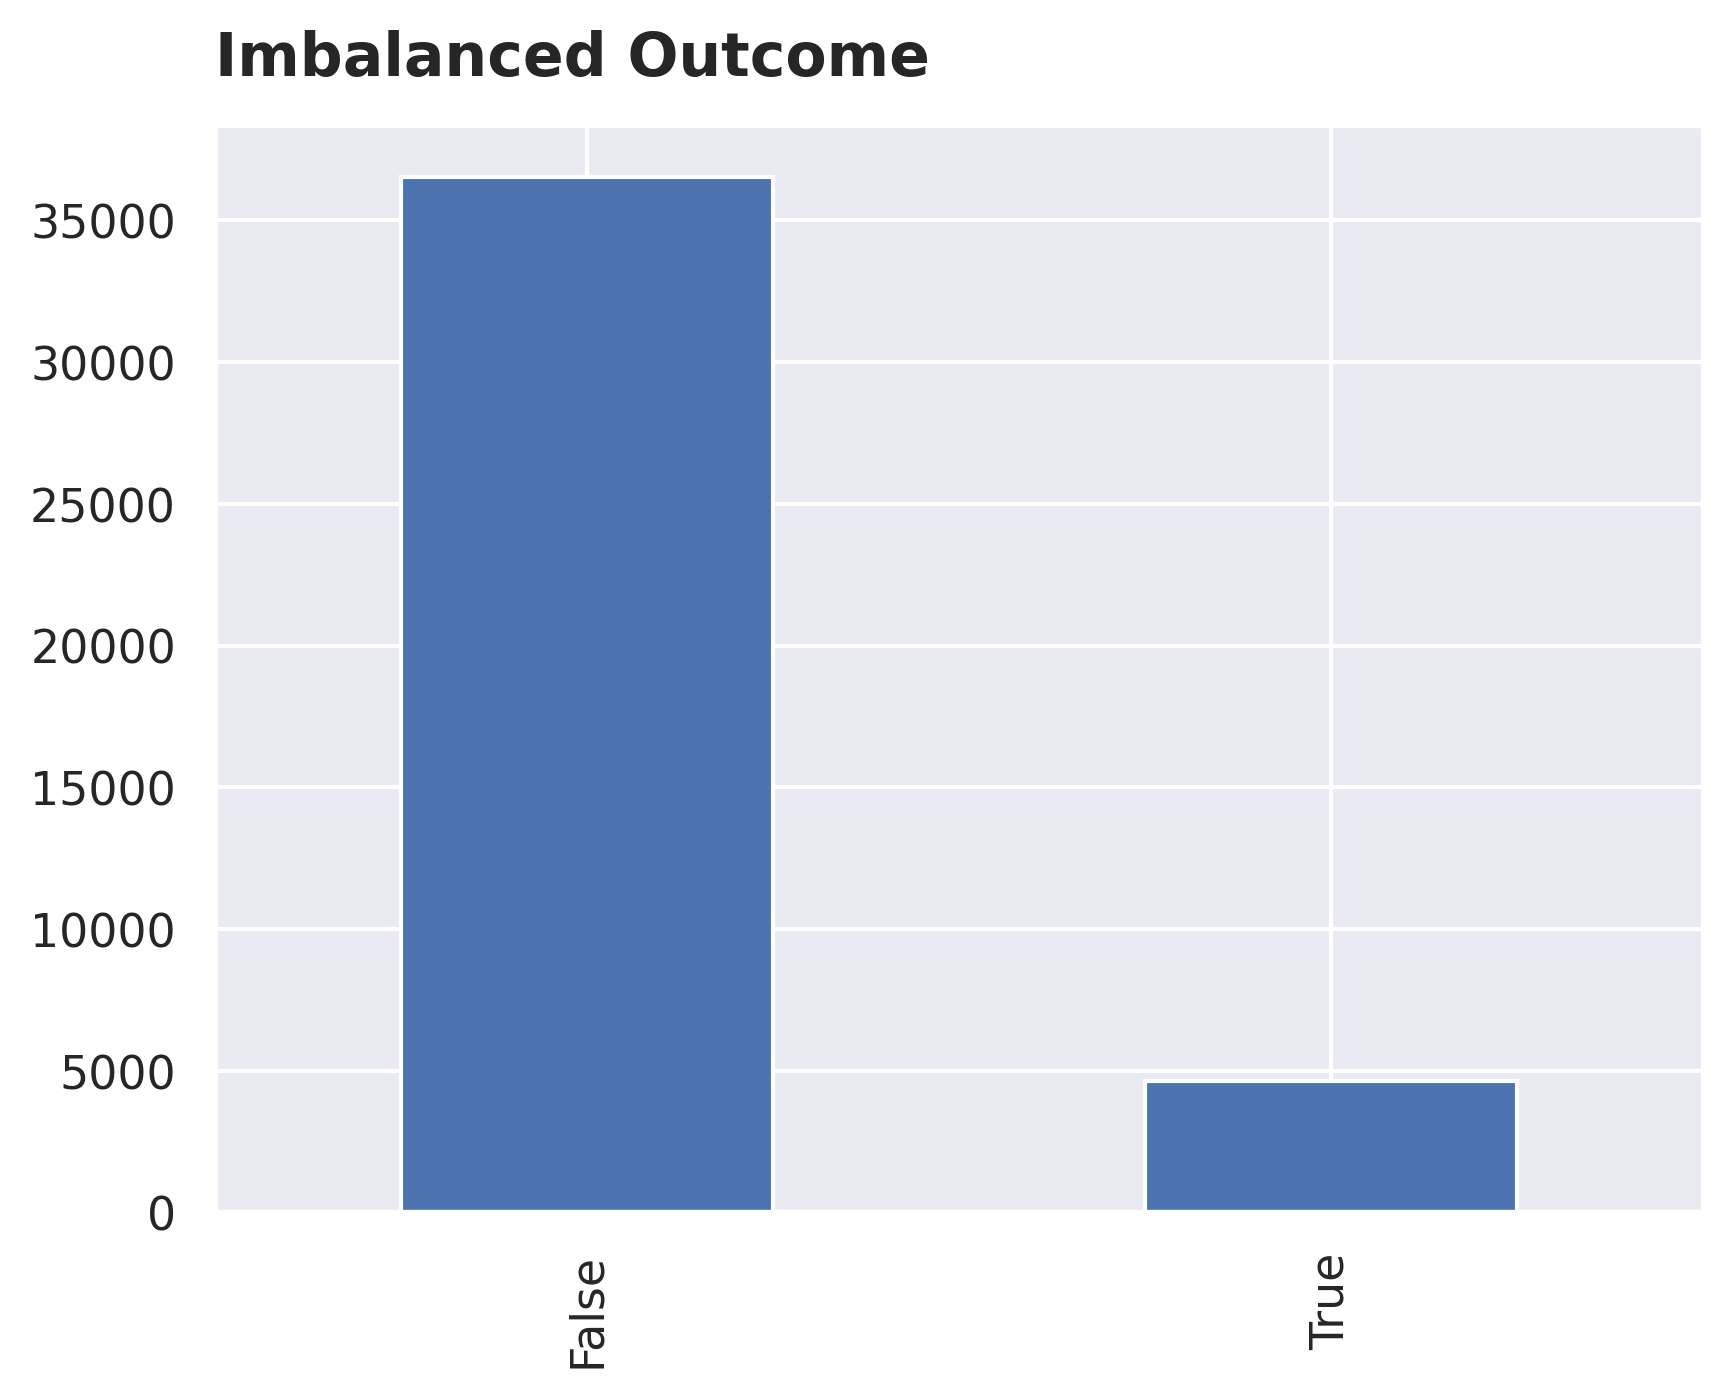

In [ ]:
y_count = bank_mkt["y"].value_counts().plot(kind = "bar", title="Imbalanced Outcome")

Using `info()` we can see that most of features concerning the client are categorical/boolean type. And some fields such as `job`, `marital`, `education`, etc. are missing.

In [ ]:
bank_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  Int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         32580 non-null  boolean 
 5   housing         40186 non-null  boolean 
 6   loan            40186 non-null  boolean 
 7   contact         41176 non-null  category
 8   month           41176 non-null  Int64   
 9   day_of_week     41176 non-null  Int64   
 10  duration        41176 non-null  Int64   
 11  campaign        41176 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41176 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

## Time-ordered Data

In [ ]:
bank_year = bank_mkt.copy()
bank_year["year"]=2008
bank_year.loc[27682:, "year"] = 2009
bank_year.loc[39118:, "year"] = 2010

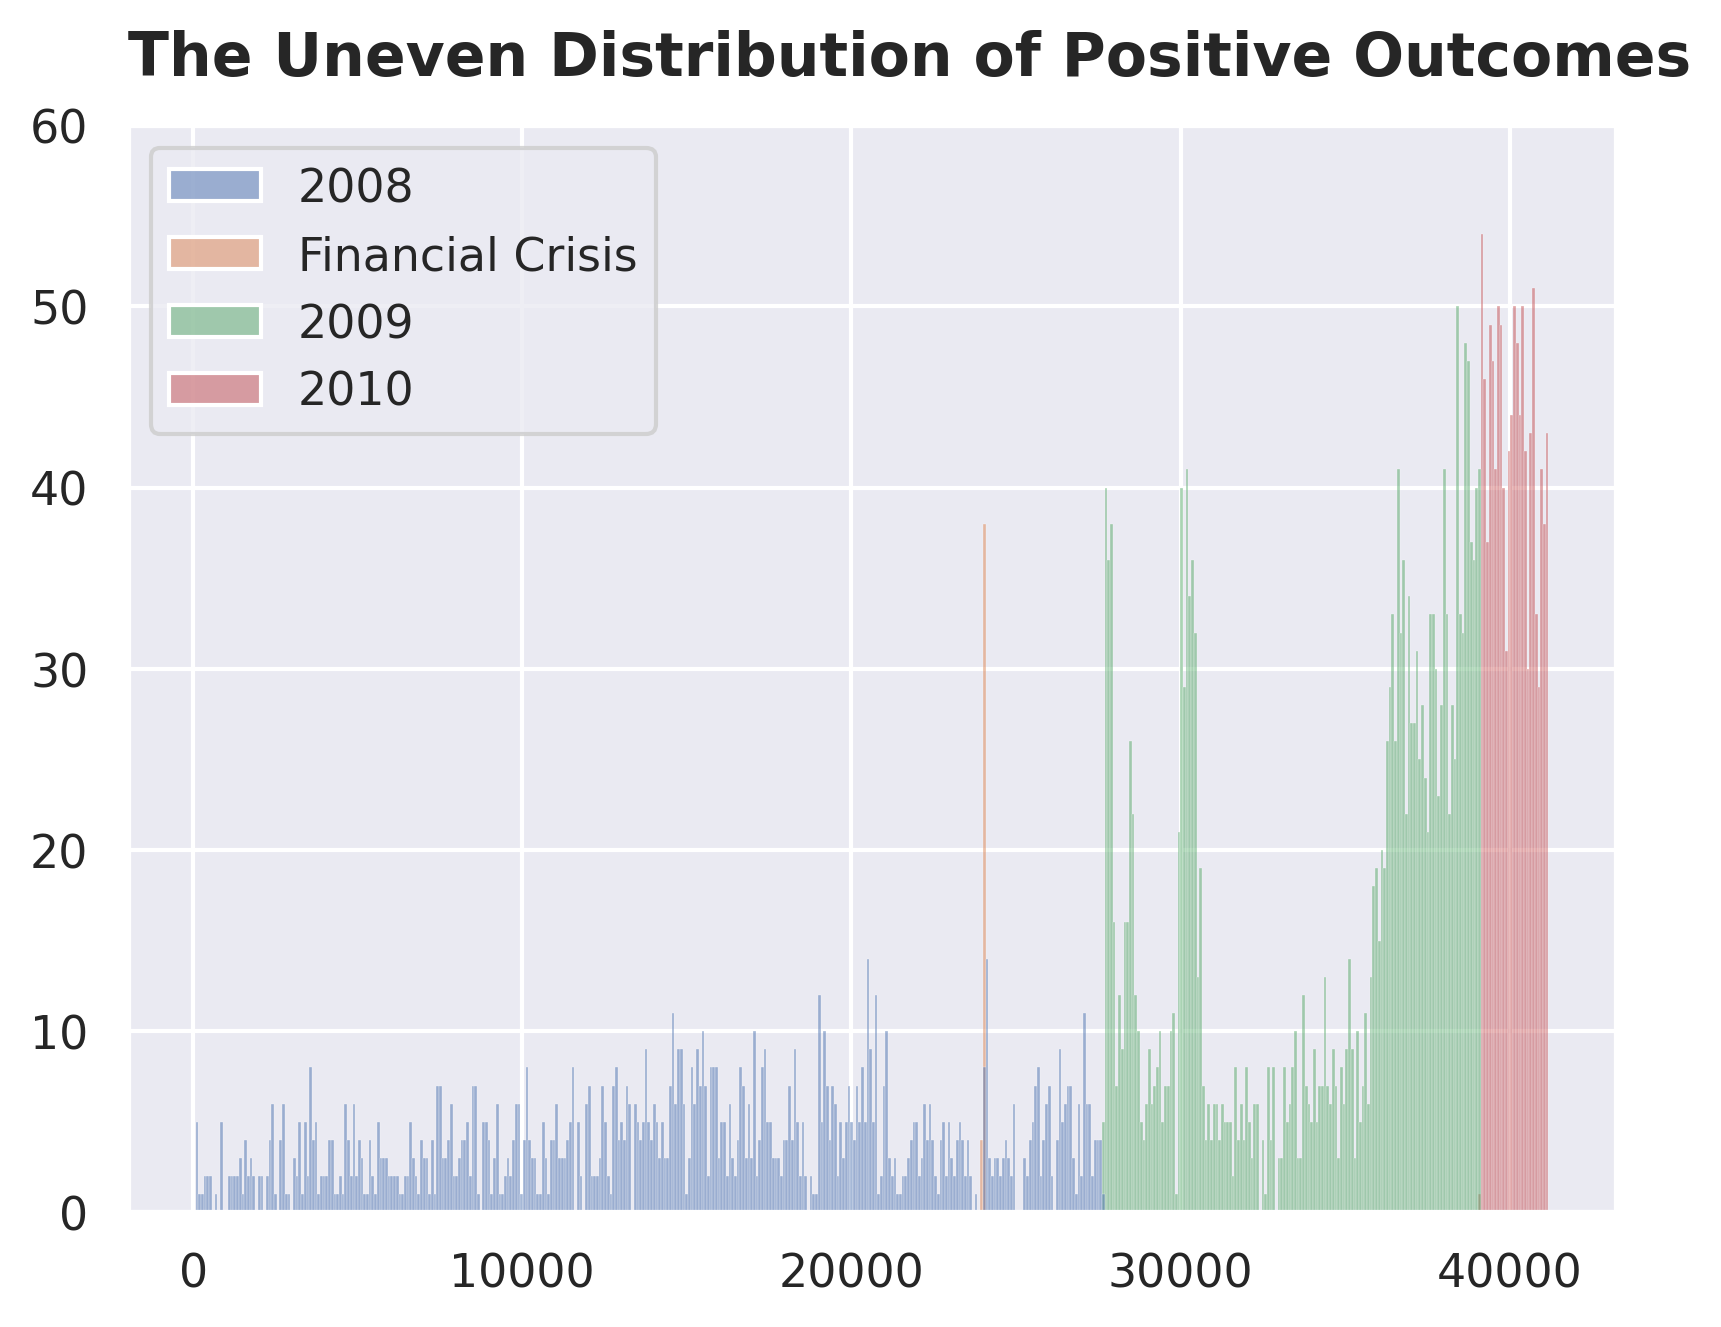

In [ ]:
p = bank_year[bank_year.y == True].reset_index()
p.loc[(p.month == 10) & (p.year==2008), "year"] = "Financial Crisis"
ax = sns.histplot(data=p, x="index", stat="count", hue="year", bins=500, palette="deep", legend=True)
ax.get_legend().set_title("")
ax.set_ylim(0,60)
ax.set(title="The Uneven Distribution of Positive Outcomes", xlabel="", ylabel="");

Oct 2008 is a special case possibly due to the financial crisis.

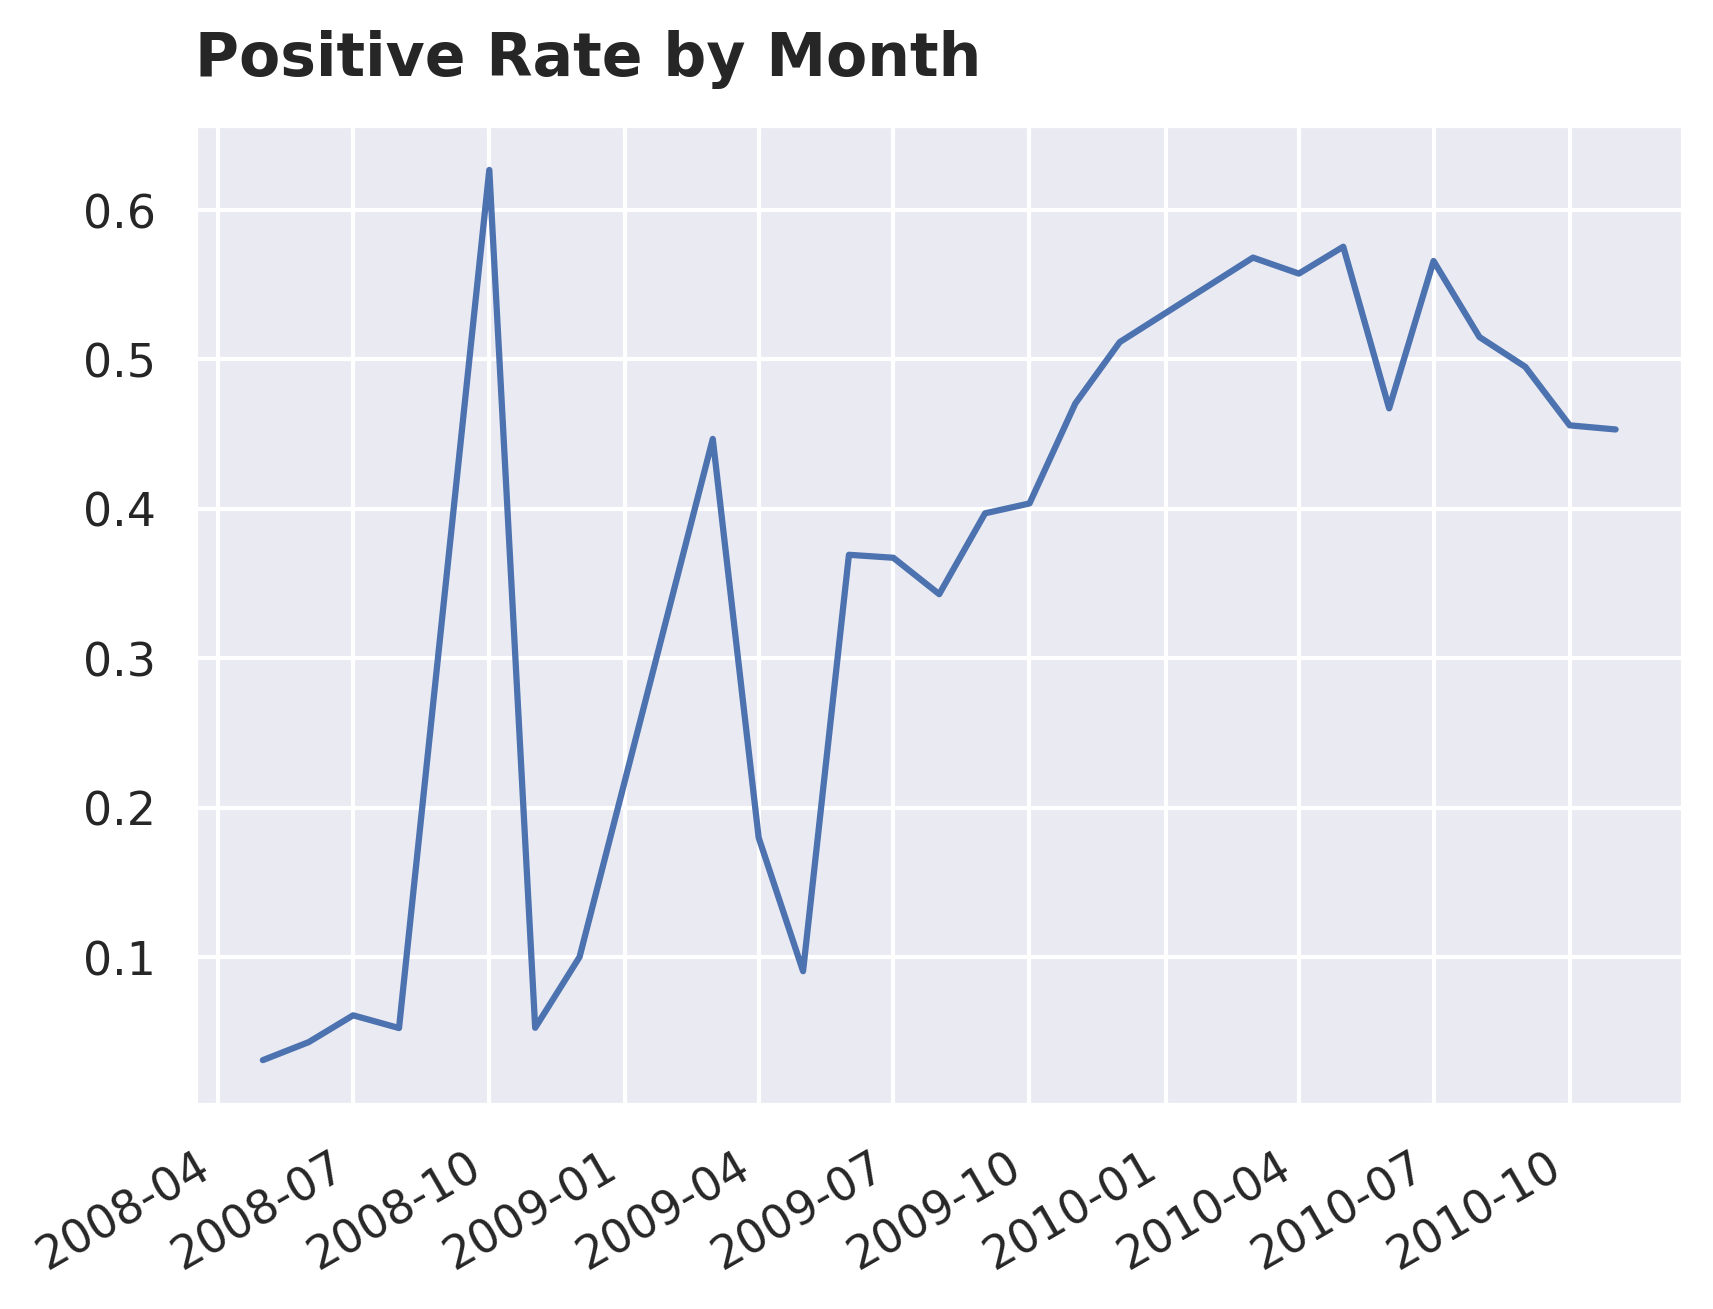

In [ ]:
bank_year["date"] = pd.to_datetime(bank_year[["month", "year"]].assign(day=1))
bank_year["y"] = bank_year["y"].astype("int")
bank_year[["date", "y"]].groupby("date").mean().plot.line(xlabel="", ylabel="", title="Positive Rate by Month", legend=False);

### Missing values

By checking the number of missing values, we can see nearly all client do not have `pdays` and `poutcome`. 20% of the clients do not have information of `default`.

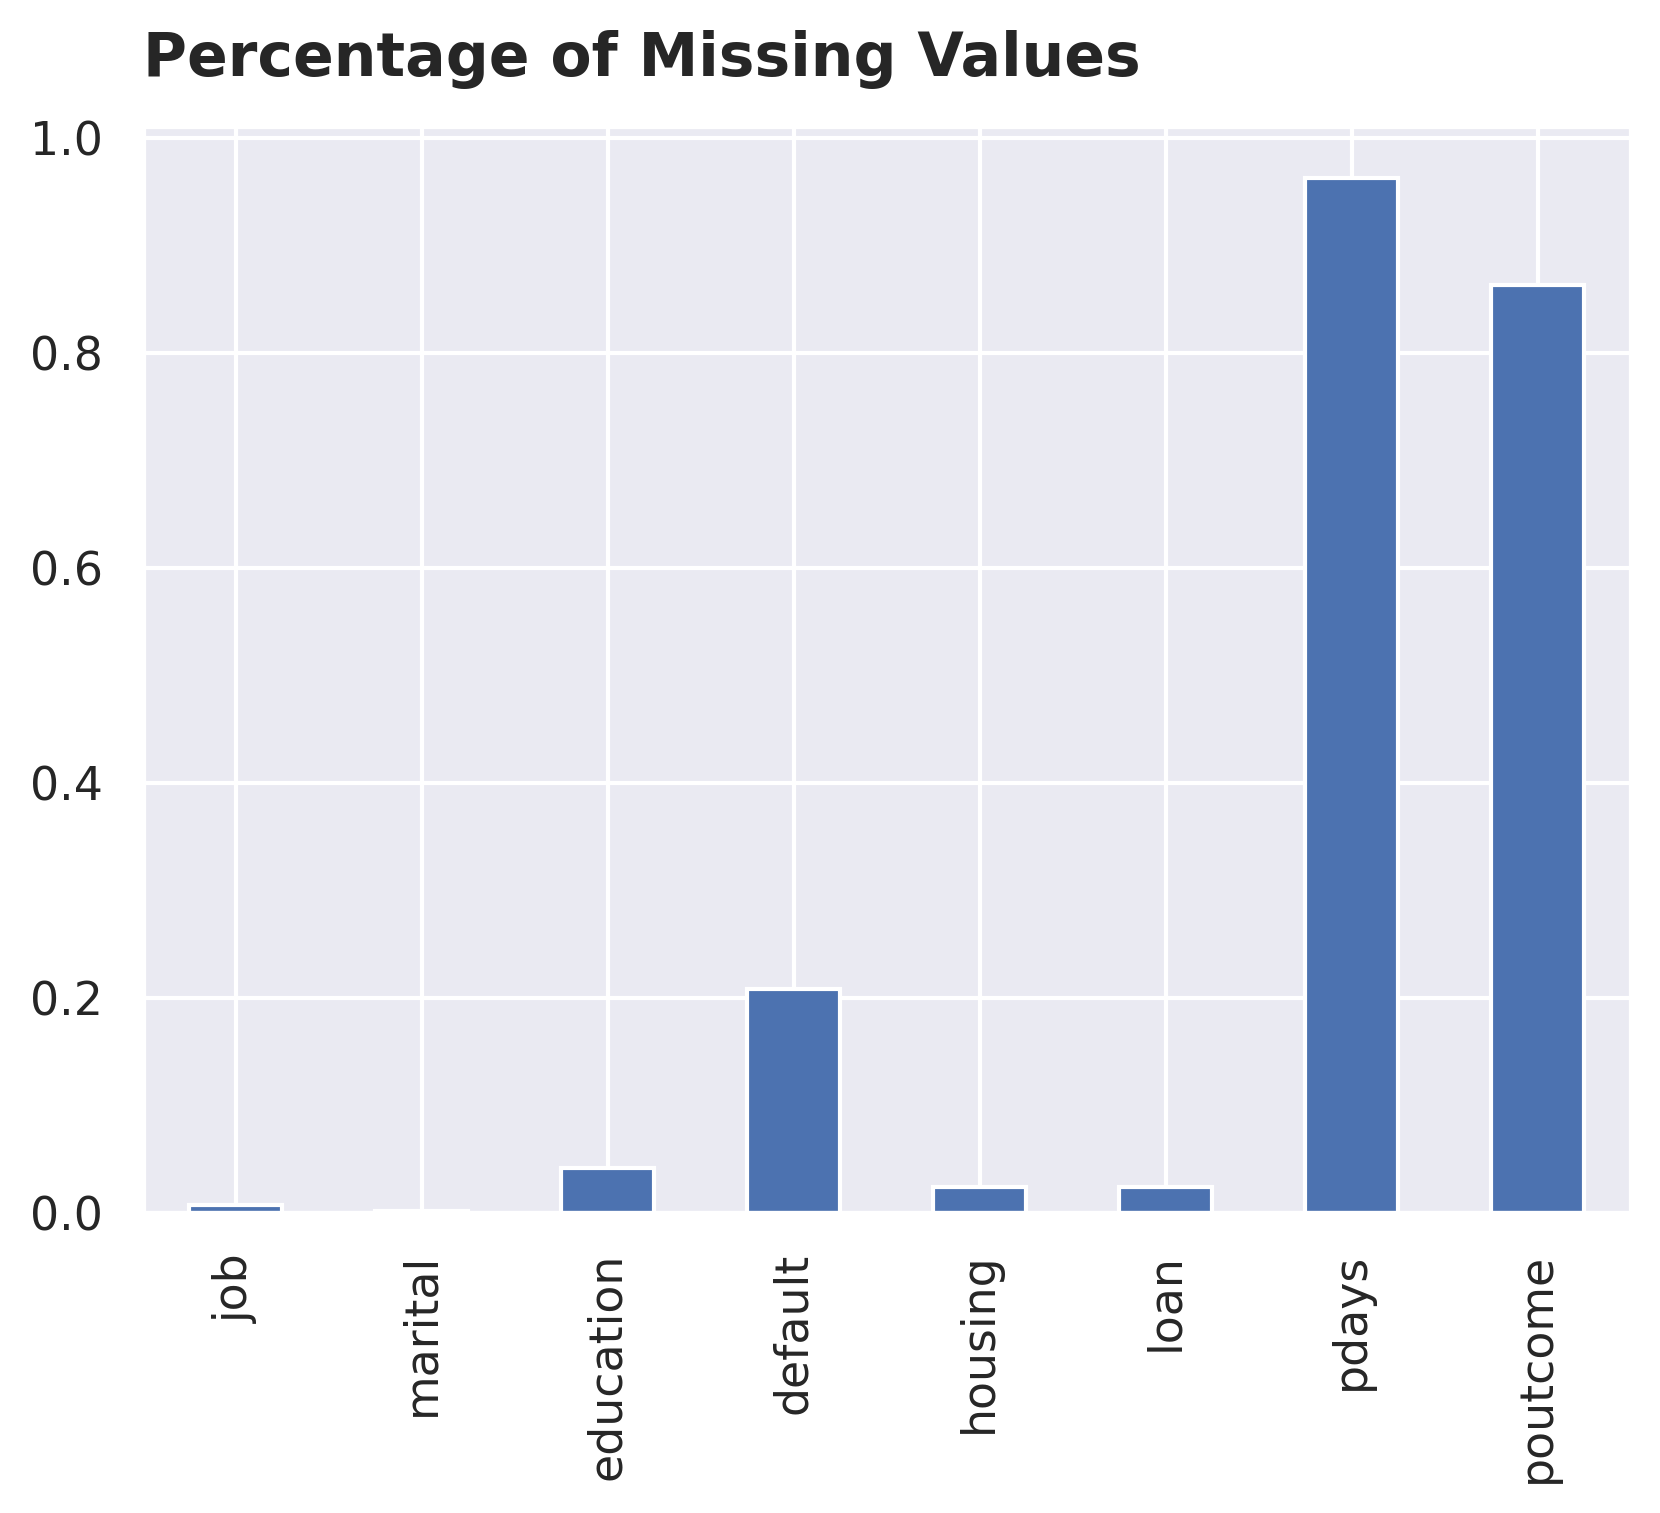

In [ ]:
na = bank_mkt.isna().sum()
na_nonzero = na[na != 0]
na_perc = na_nonzero/bank_mkt.y.count()
na_bar = na_perc.plot.bar(title="Percentage of Missing Values")

### Client Data

Let's start with basic client data.

Most of the clients's age are between 32 to 47 while there are some outlier cases beyond 70. This may imply that we should choose standardization for scaling since it's more tolerant for outliers.

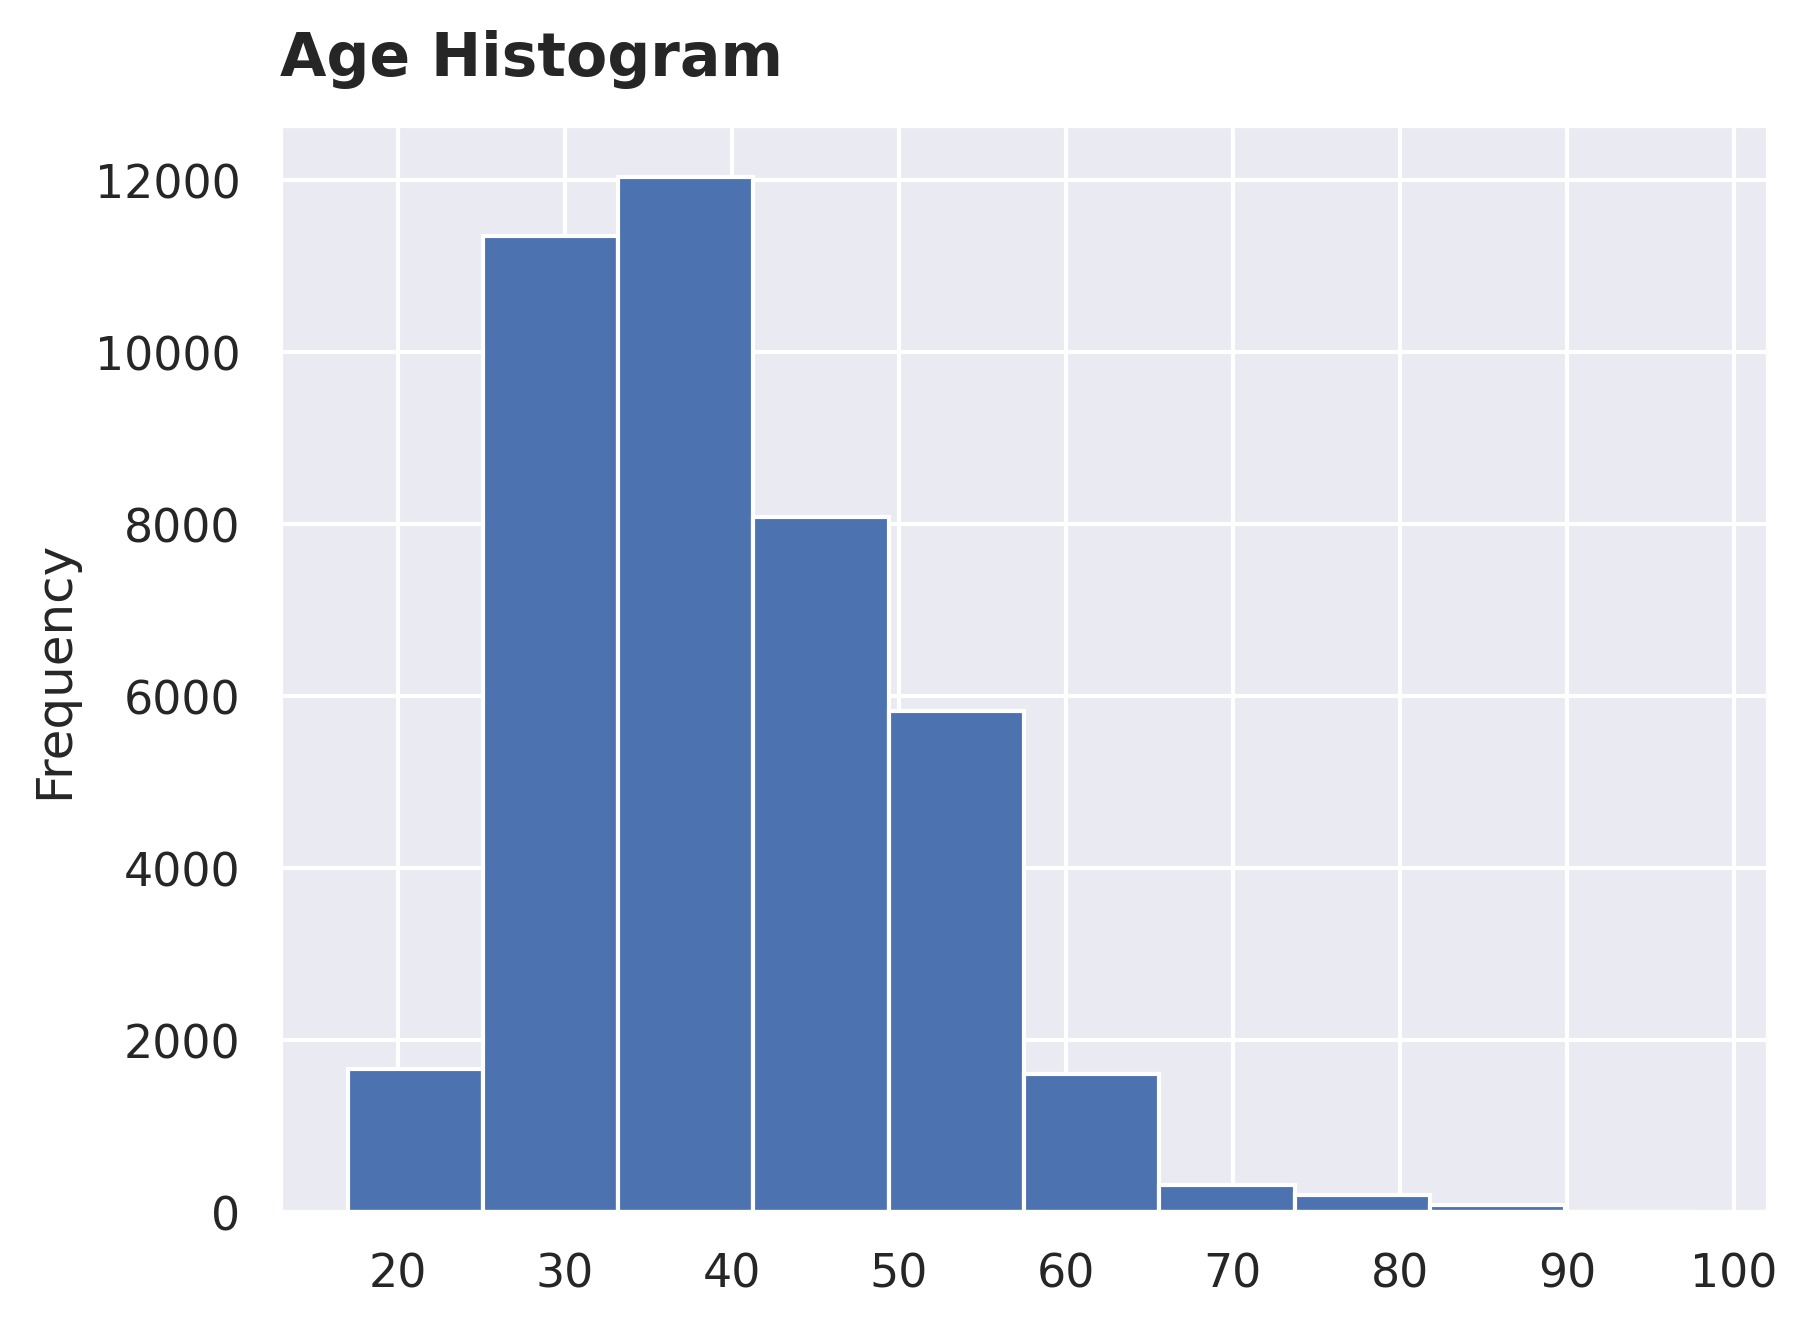

In [ ]:
age_hist = bank_mkt["age"].plot.hist(title="Age Histogram")

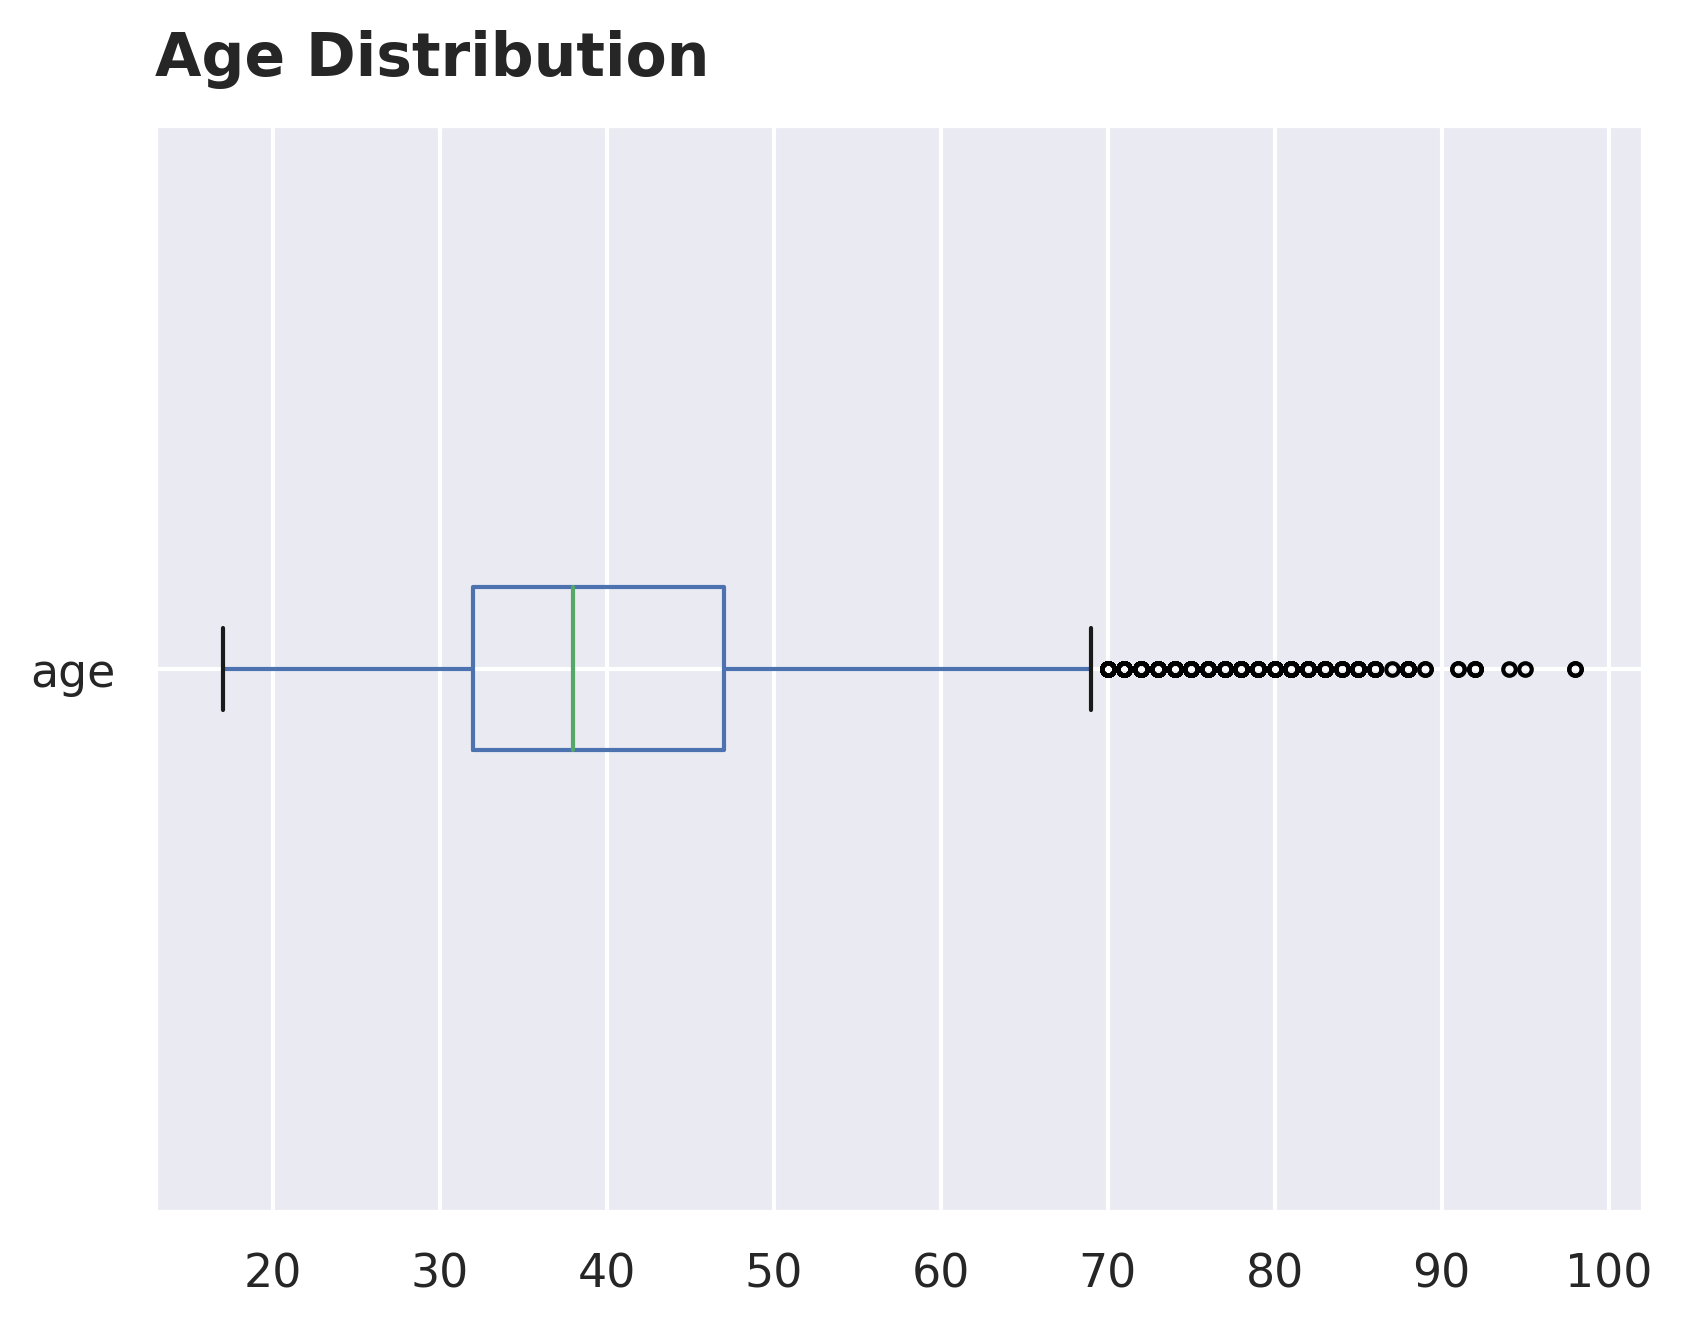

In [ ]:
age_box = bank_mkt["age"].plot.box(vert=False, sym=".", title="Age Distribution")

From the graph below we can see that the age distribution in the true outcome group has lower median age but is more skewed toward an slightly older population.

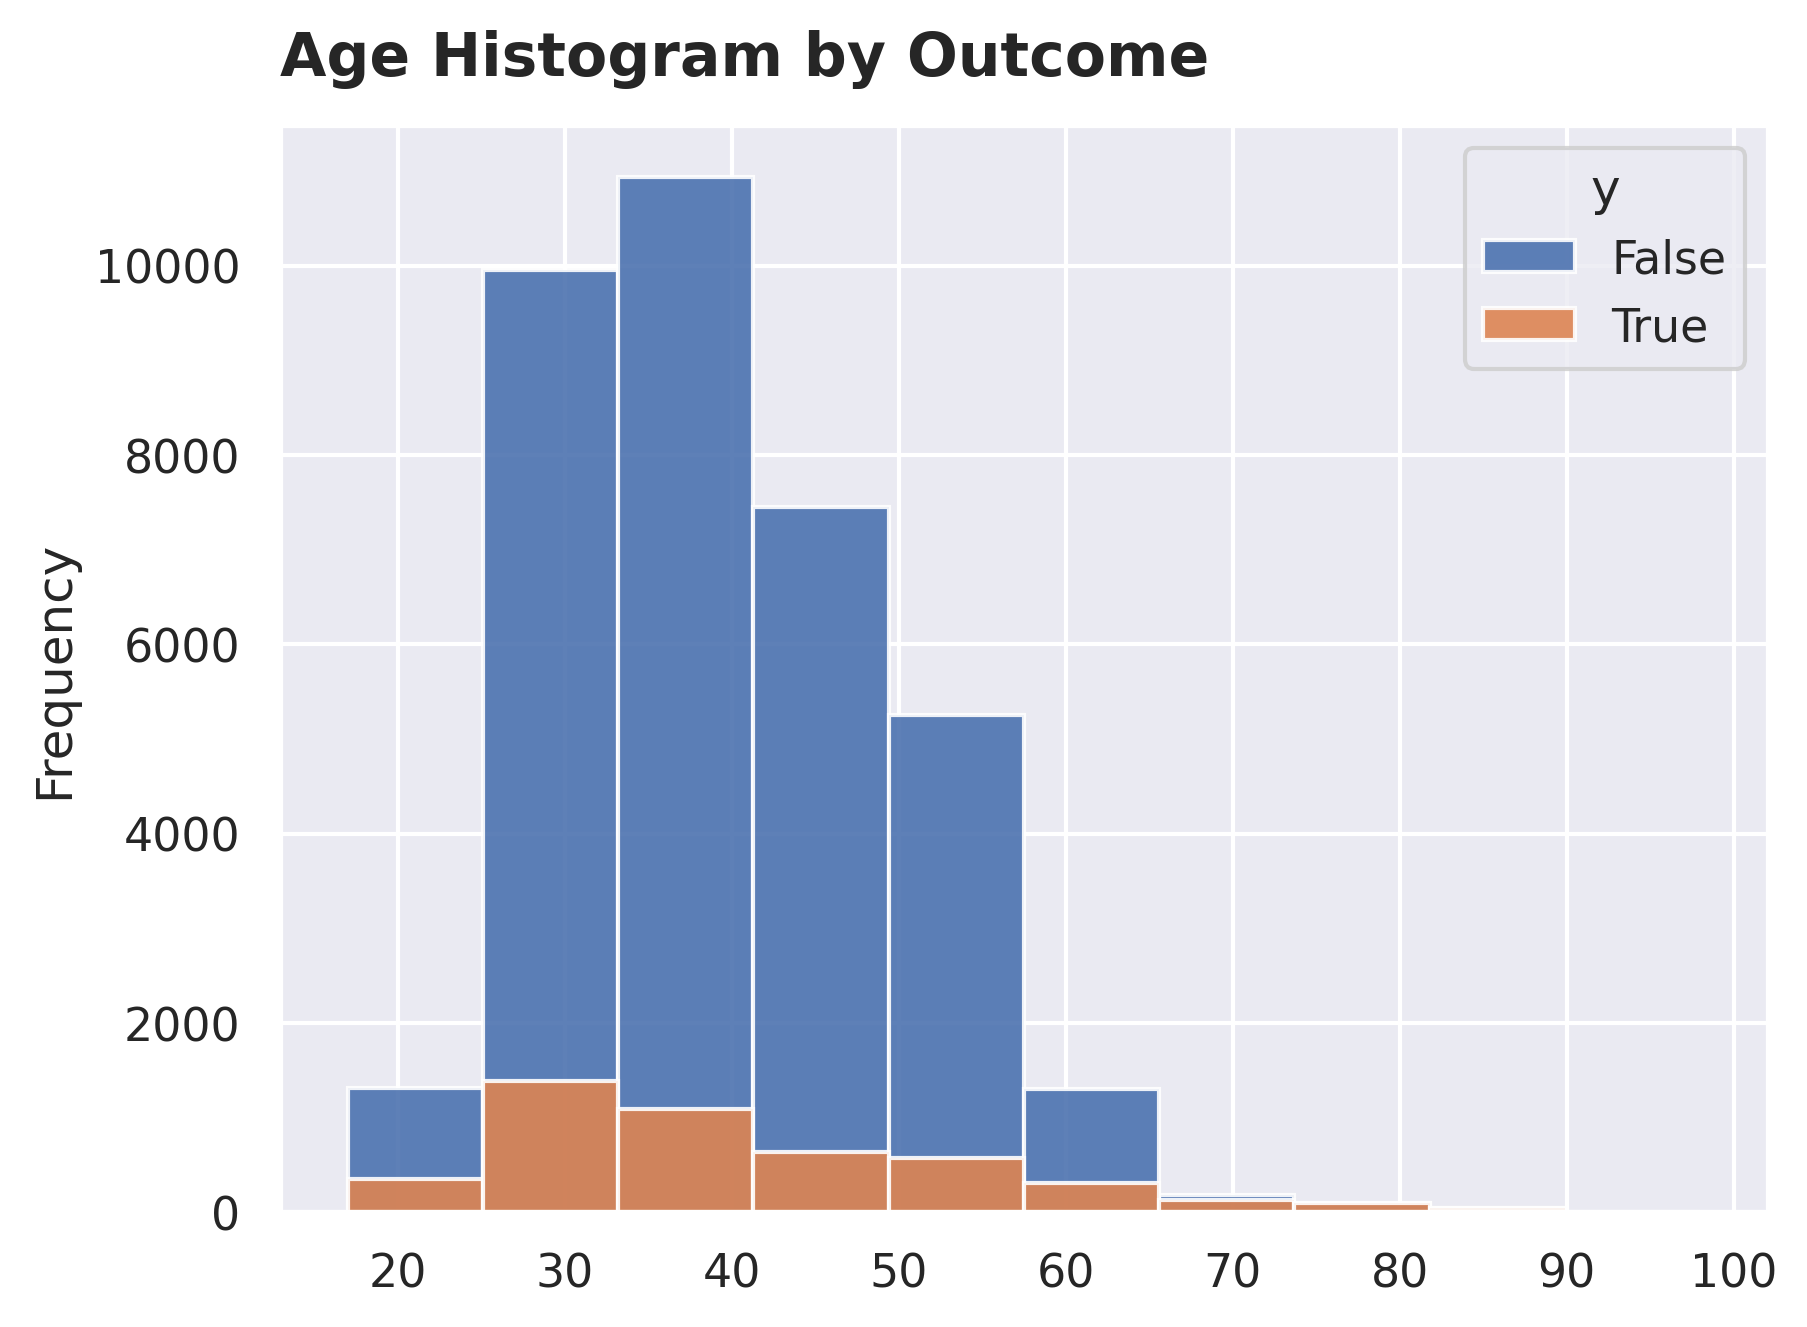

In [ ]:
age_y = bank_mkt[["age", "y"]].pivot(columns="y", values="age")
age_hist_outcome = age_y.plot.hist(alpha=0.9, legend=True, title="Age Histogram by Outcome")

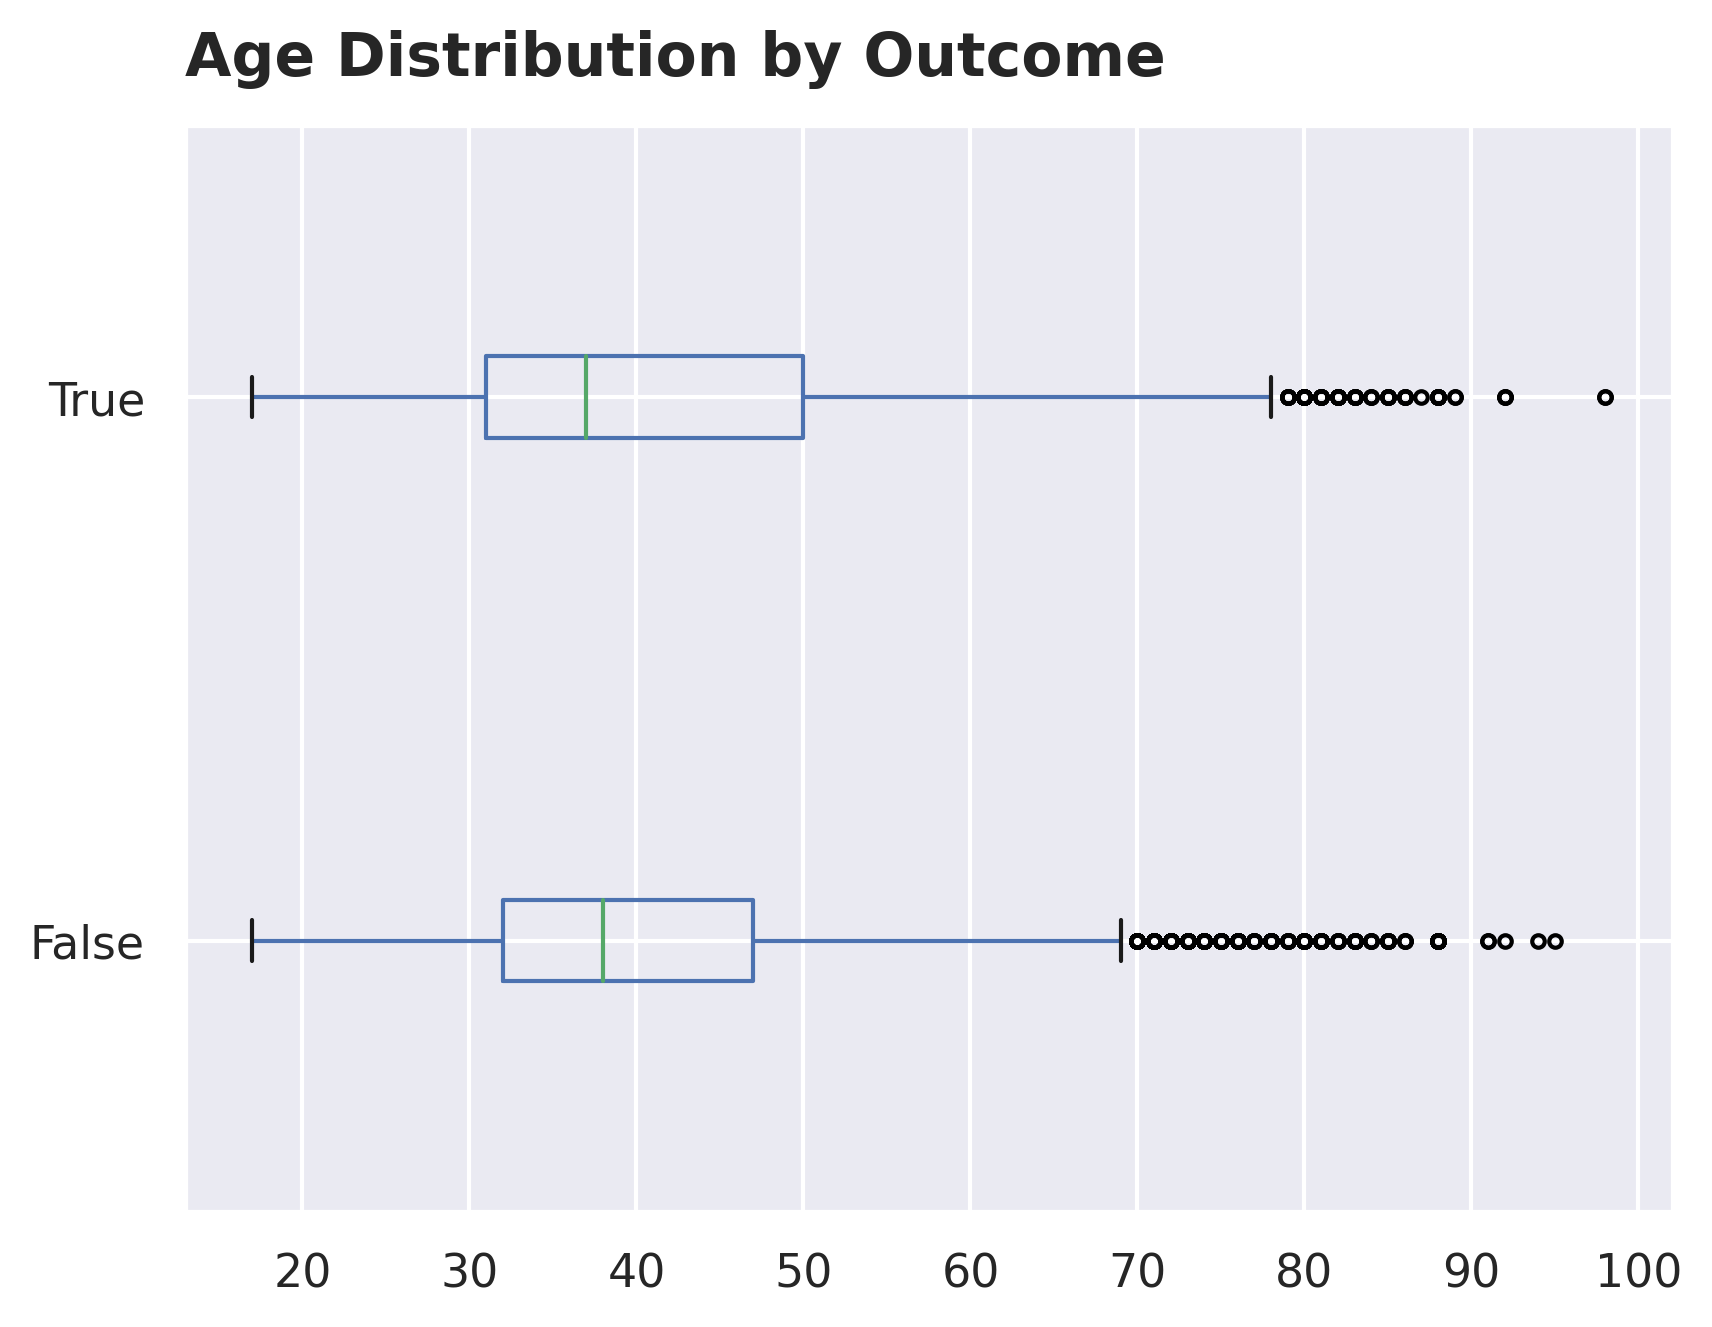

In [ ]:
age_box_outcome = age_y.plot.box(vert=False, sym=".", title="Age Distribution by Outcome")

We can also inspect the relationship between age and other categorical values.

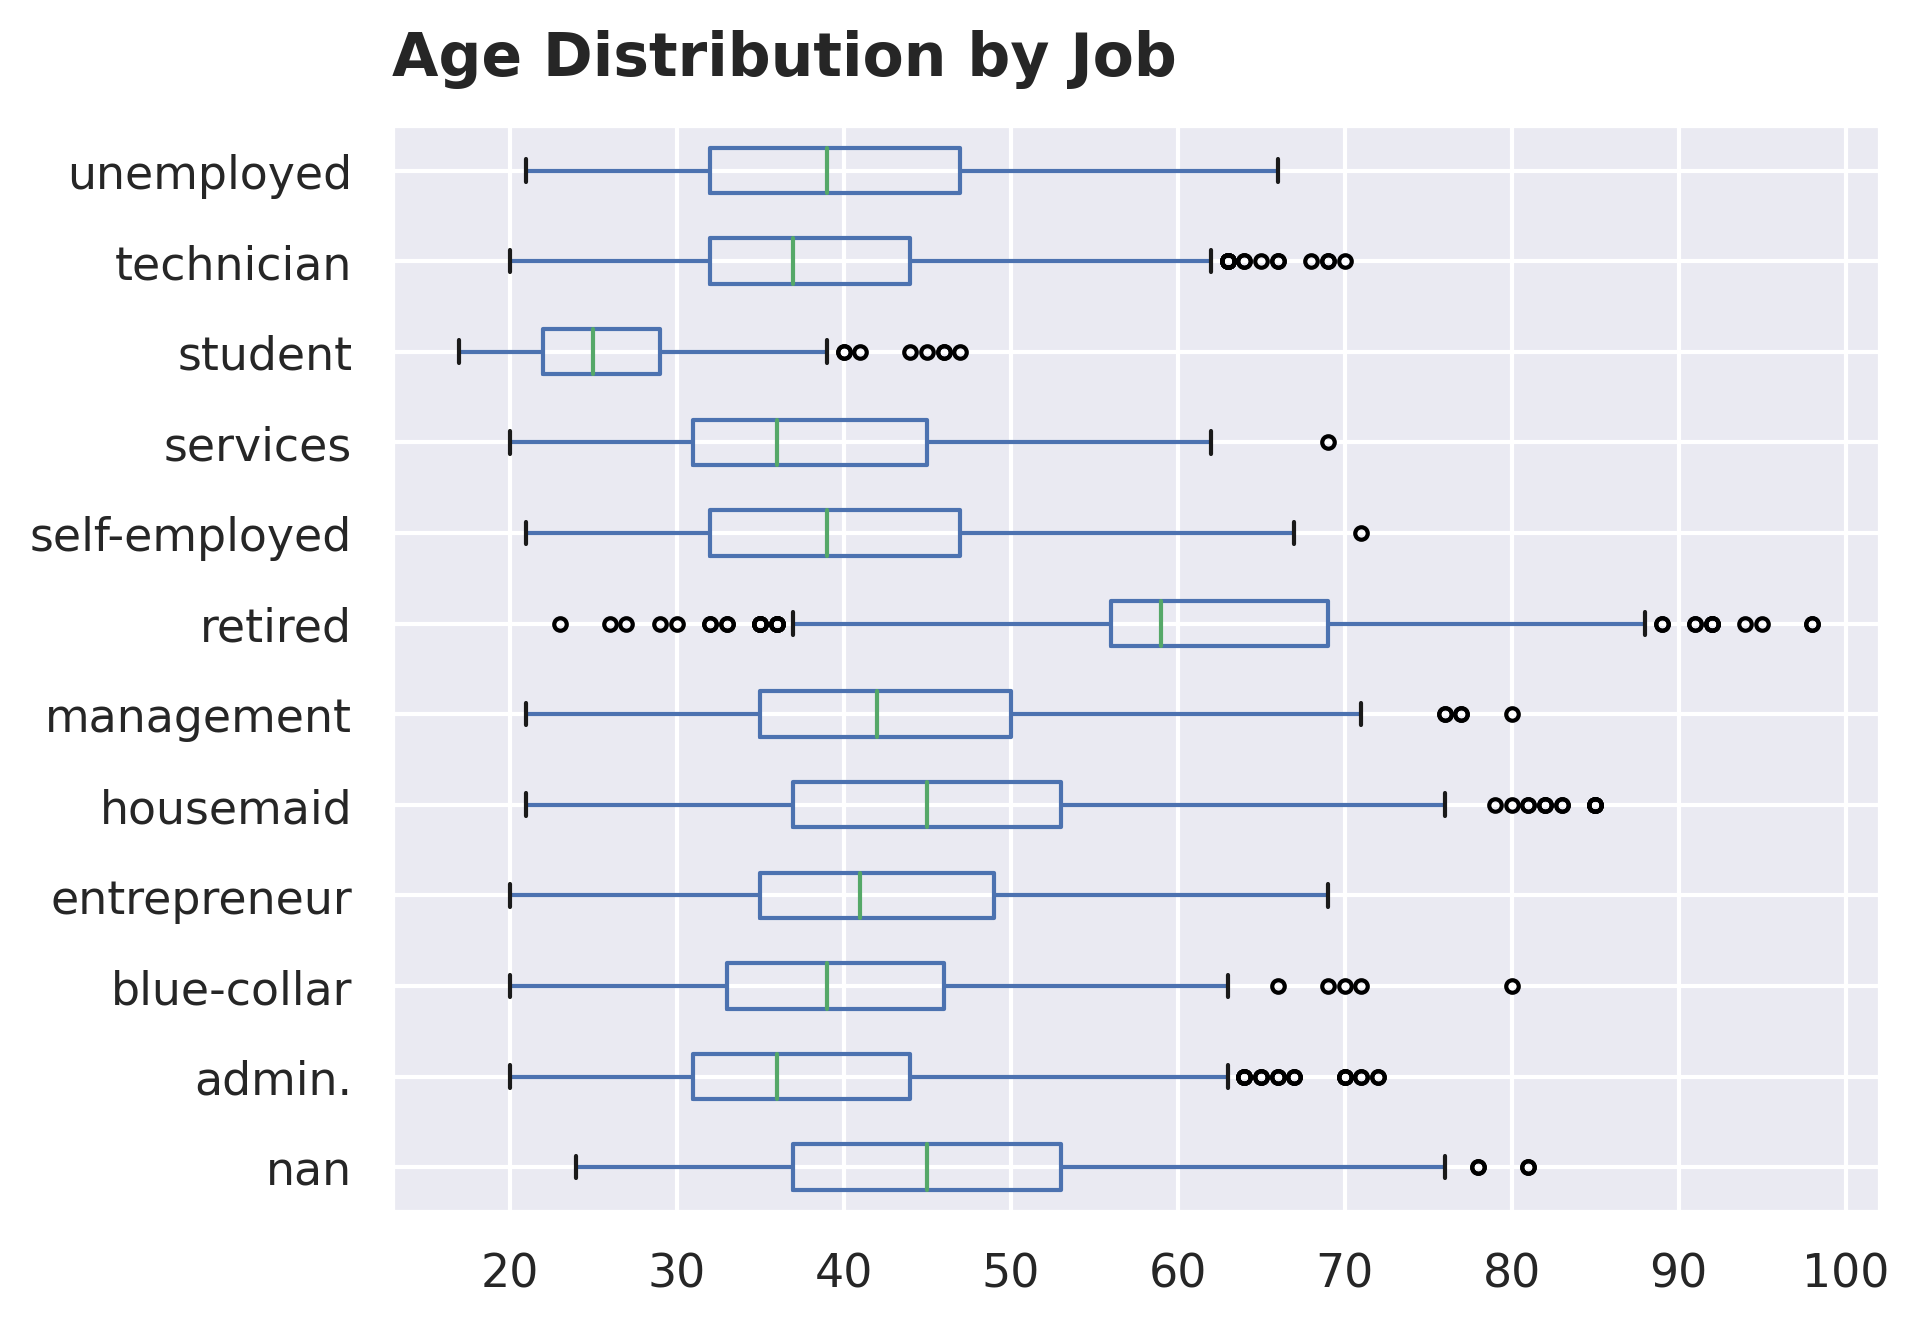

In [ ]:
age_job = bank_mkt[["age", "job"]].pivot(columns="job", values="age")
age_job_box = age_job.plot.box(vert=False, sym=".", title="Age Distribution by Job")

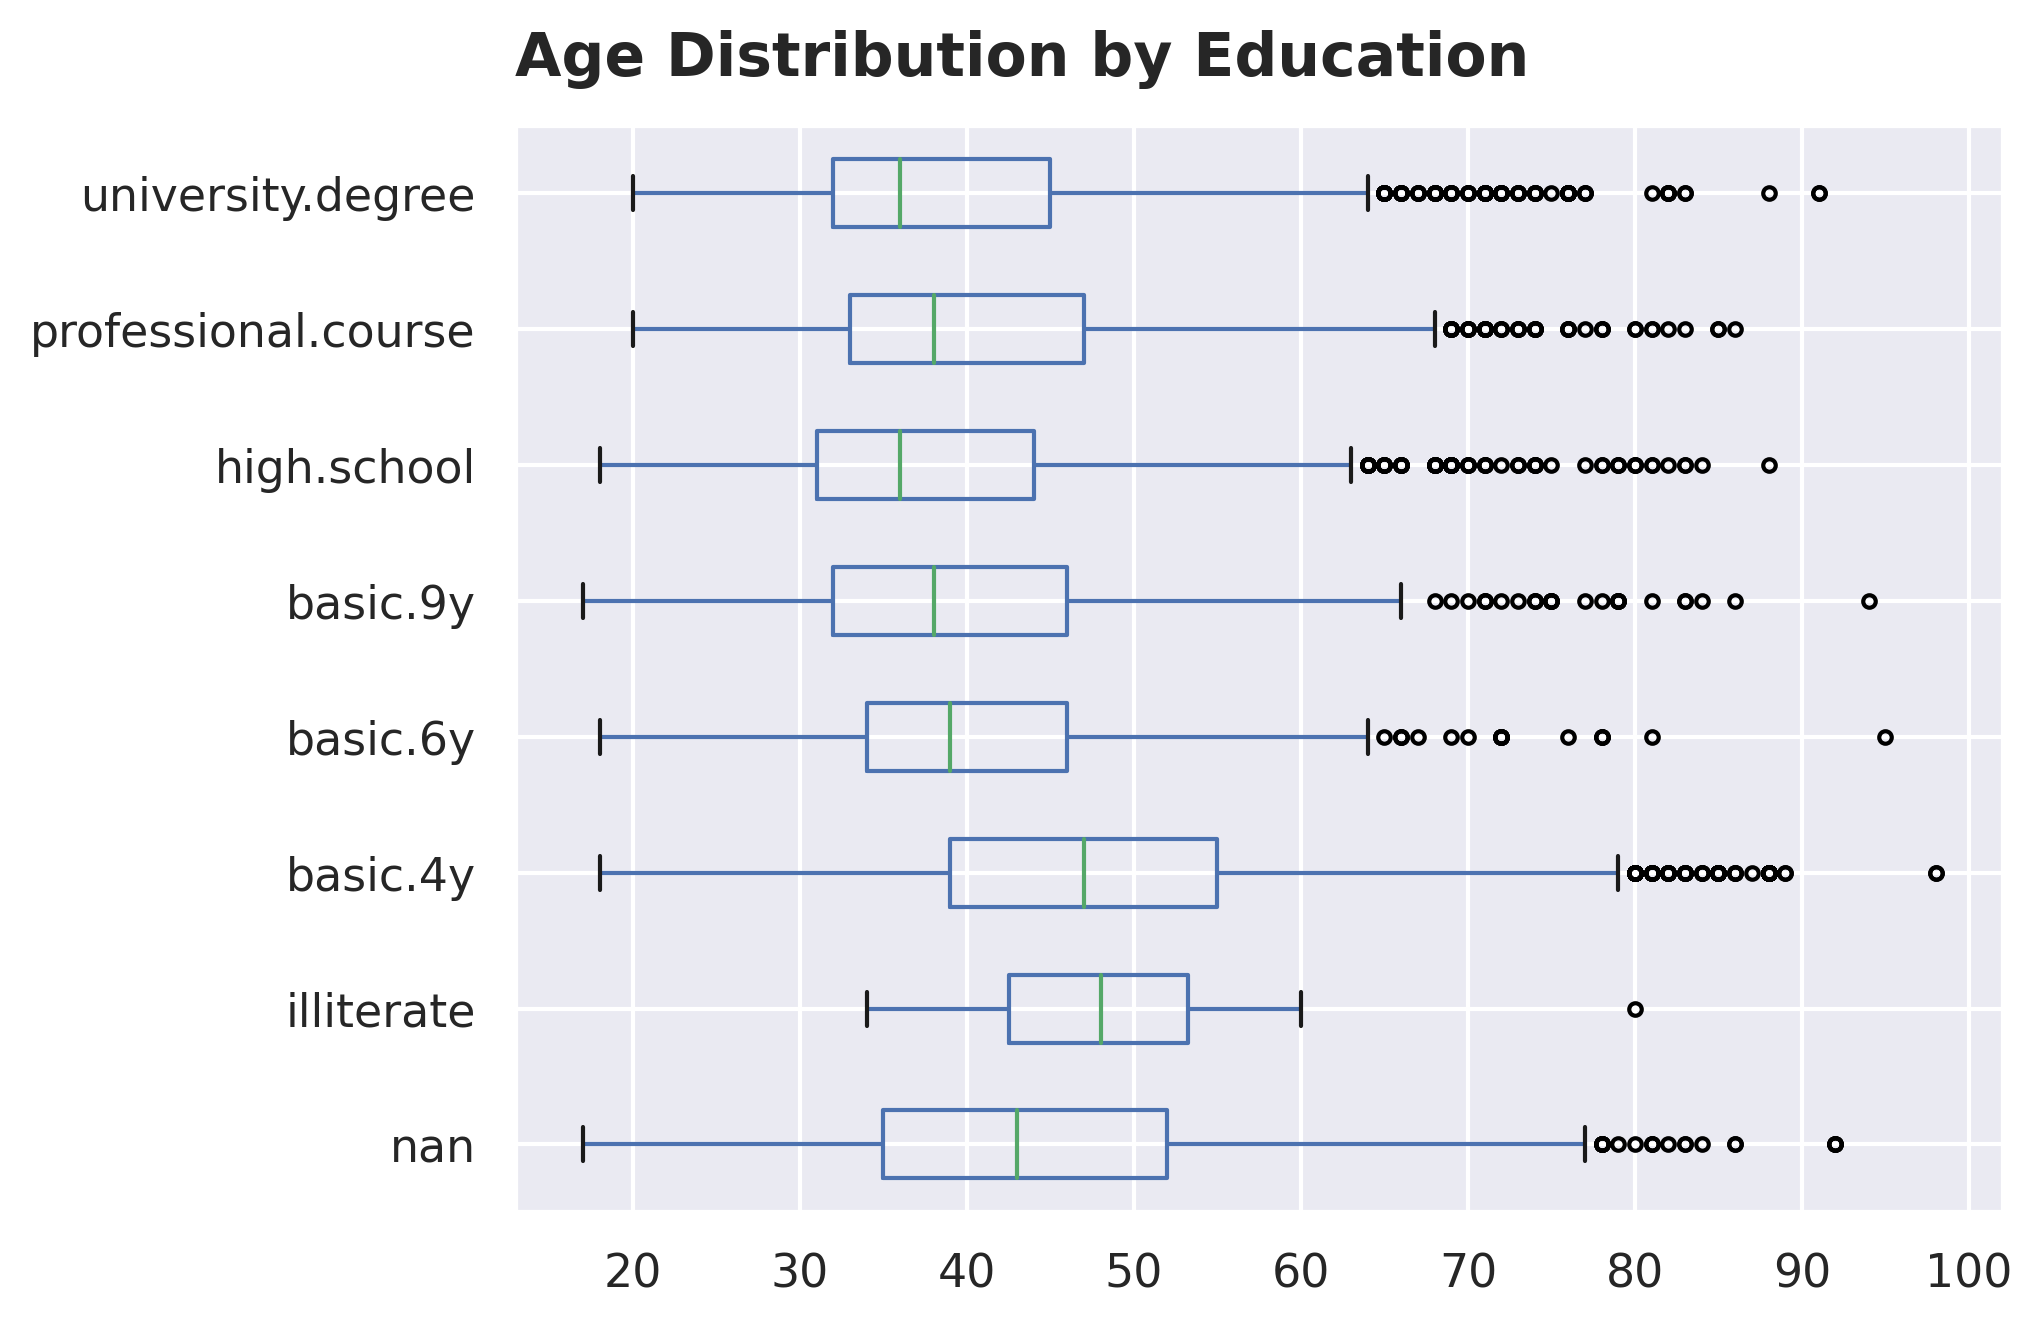

In [ ]:
age_education = bank_mkt[["age", "education"]].pivot(columns="education", values="age")
age_education_box = age_education.plot.box(vert=False, sym=".", title="Age Distribution by Education")

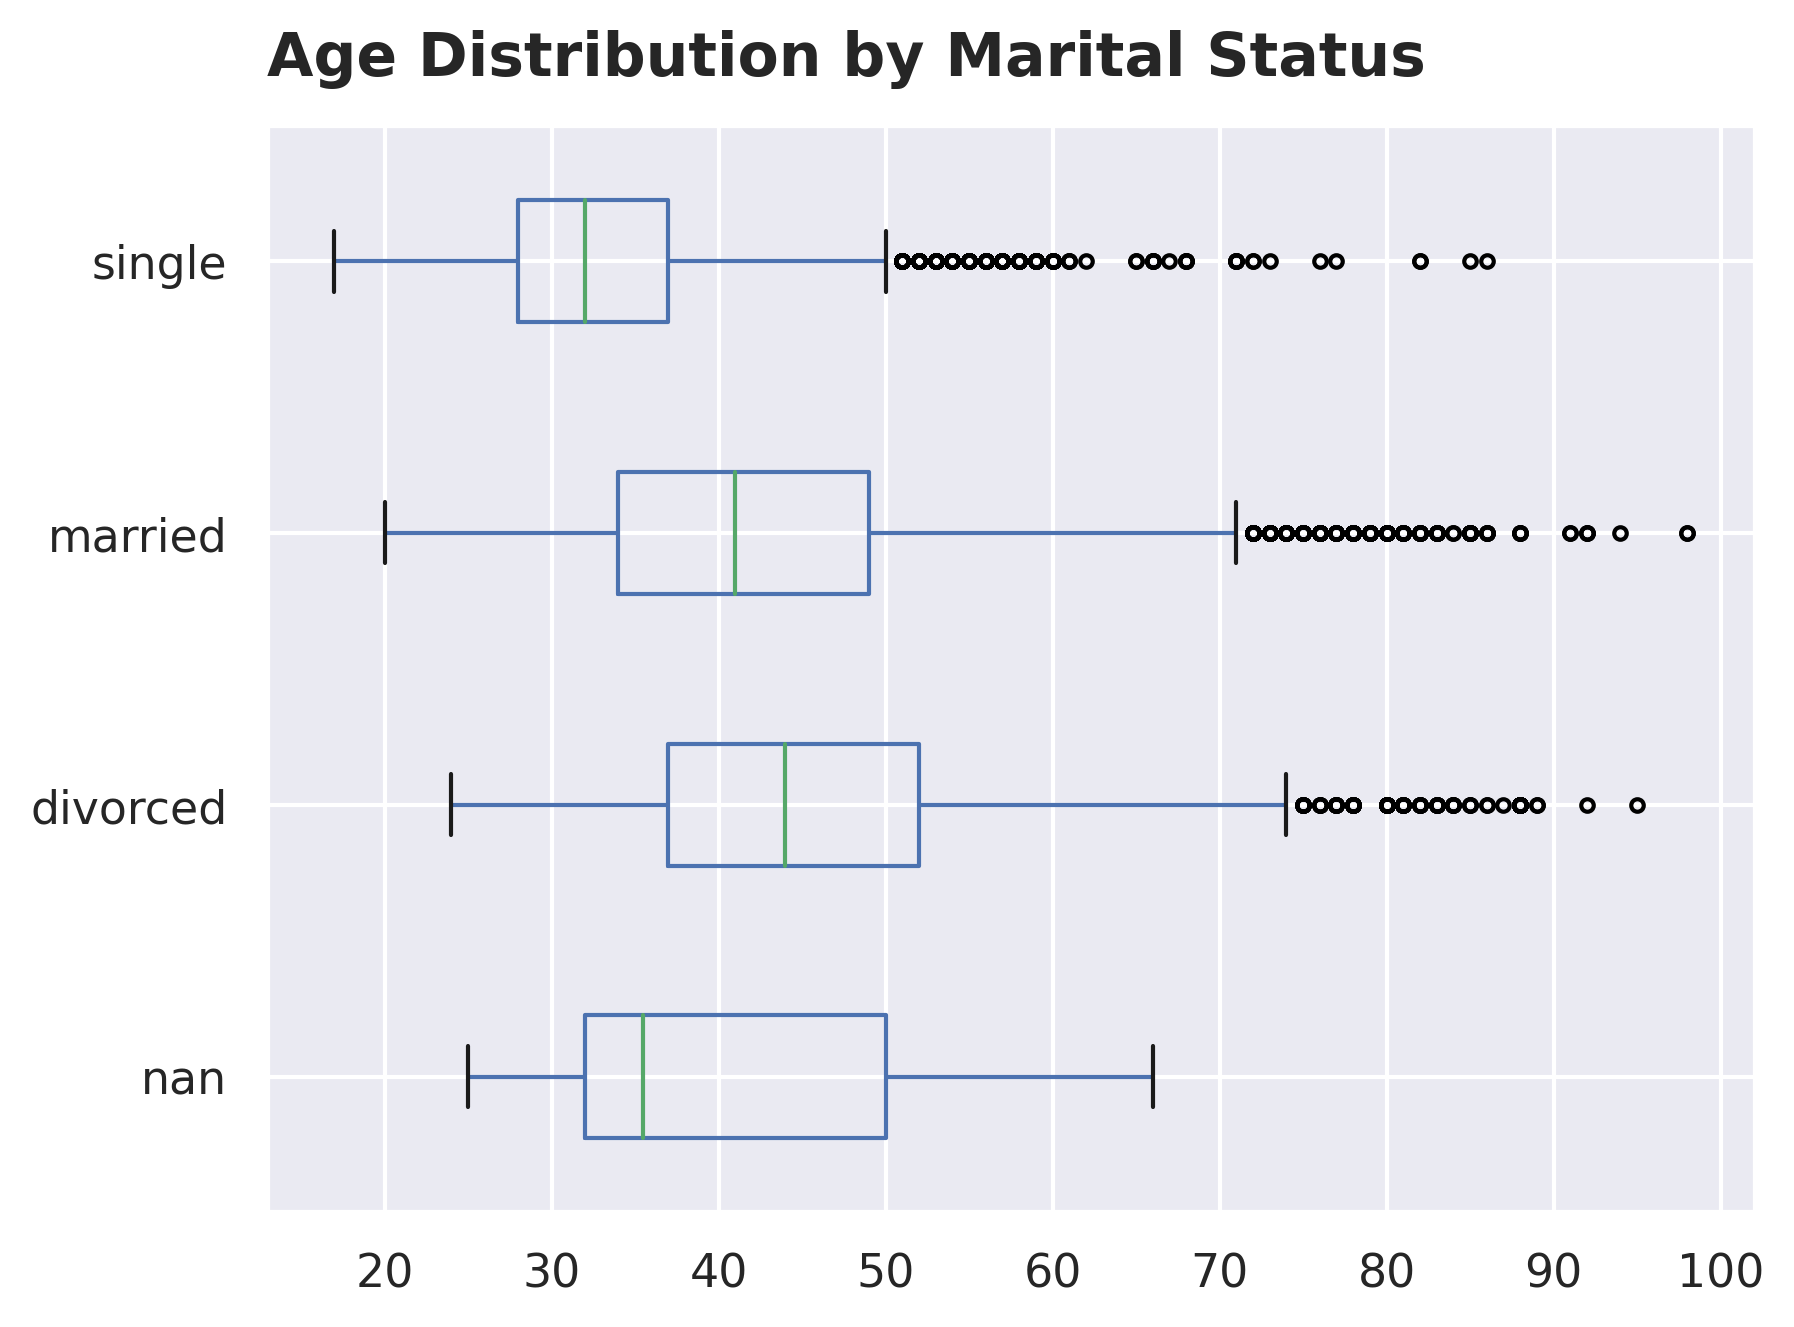

In [ ]:
age_marital = bank_mkt[["age", "marital"]].pivot(columns="marital", values="age")
age_marital_box = age_marital.plot.box(vert=False, sym=".", title="Age Distribution by Marital Status")

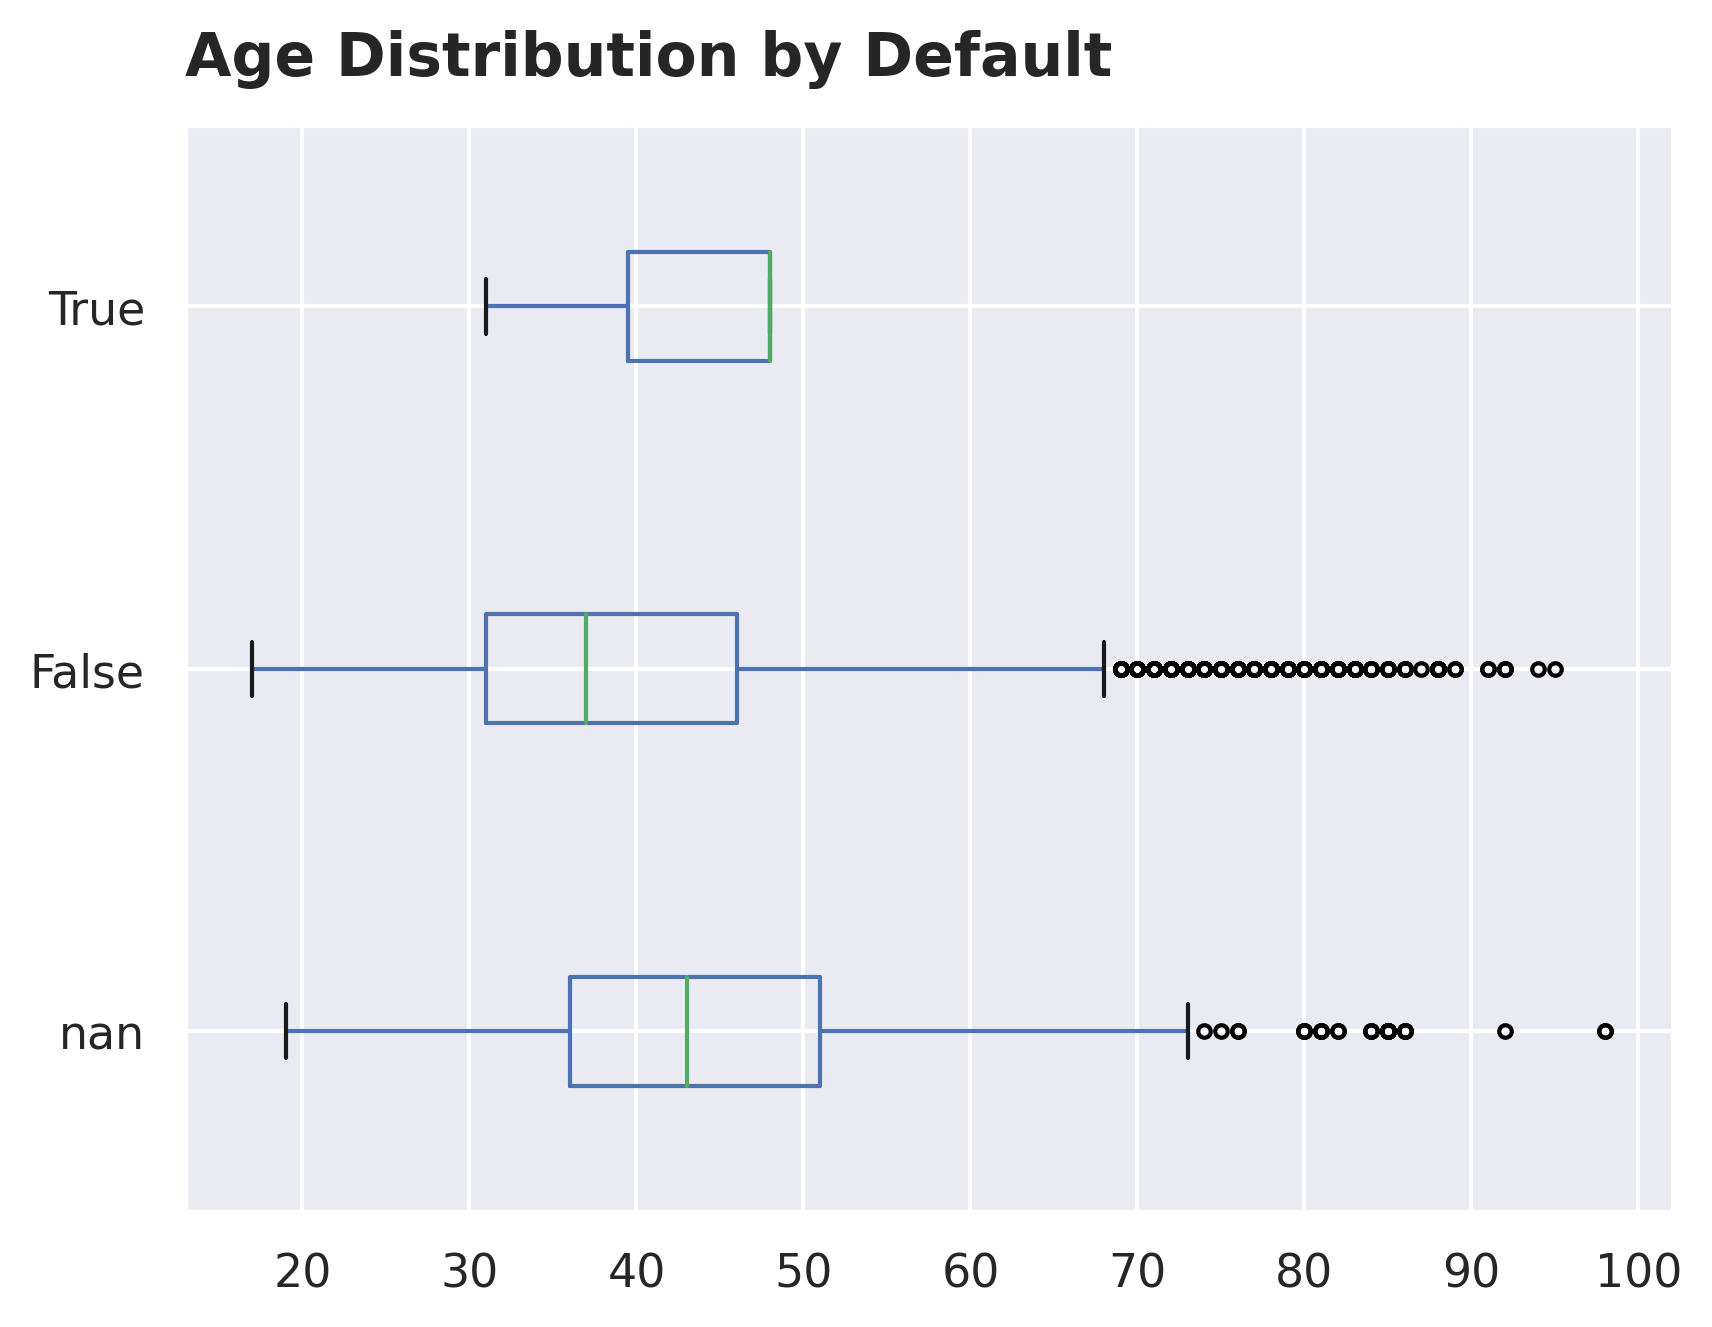

In [ ]:
age_default = bank_mkt[["age", "default"]].pivot(columns="default", values="age")
age_default_box = age_default.plot.box(vert=False, sym=".", title="Age Distribution by Default")

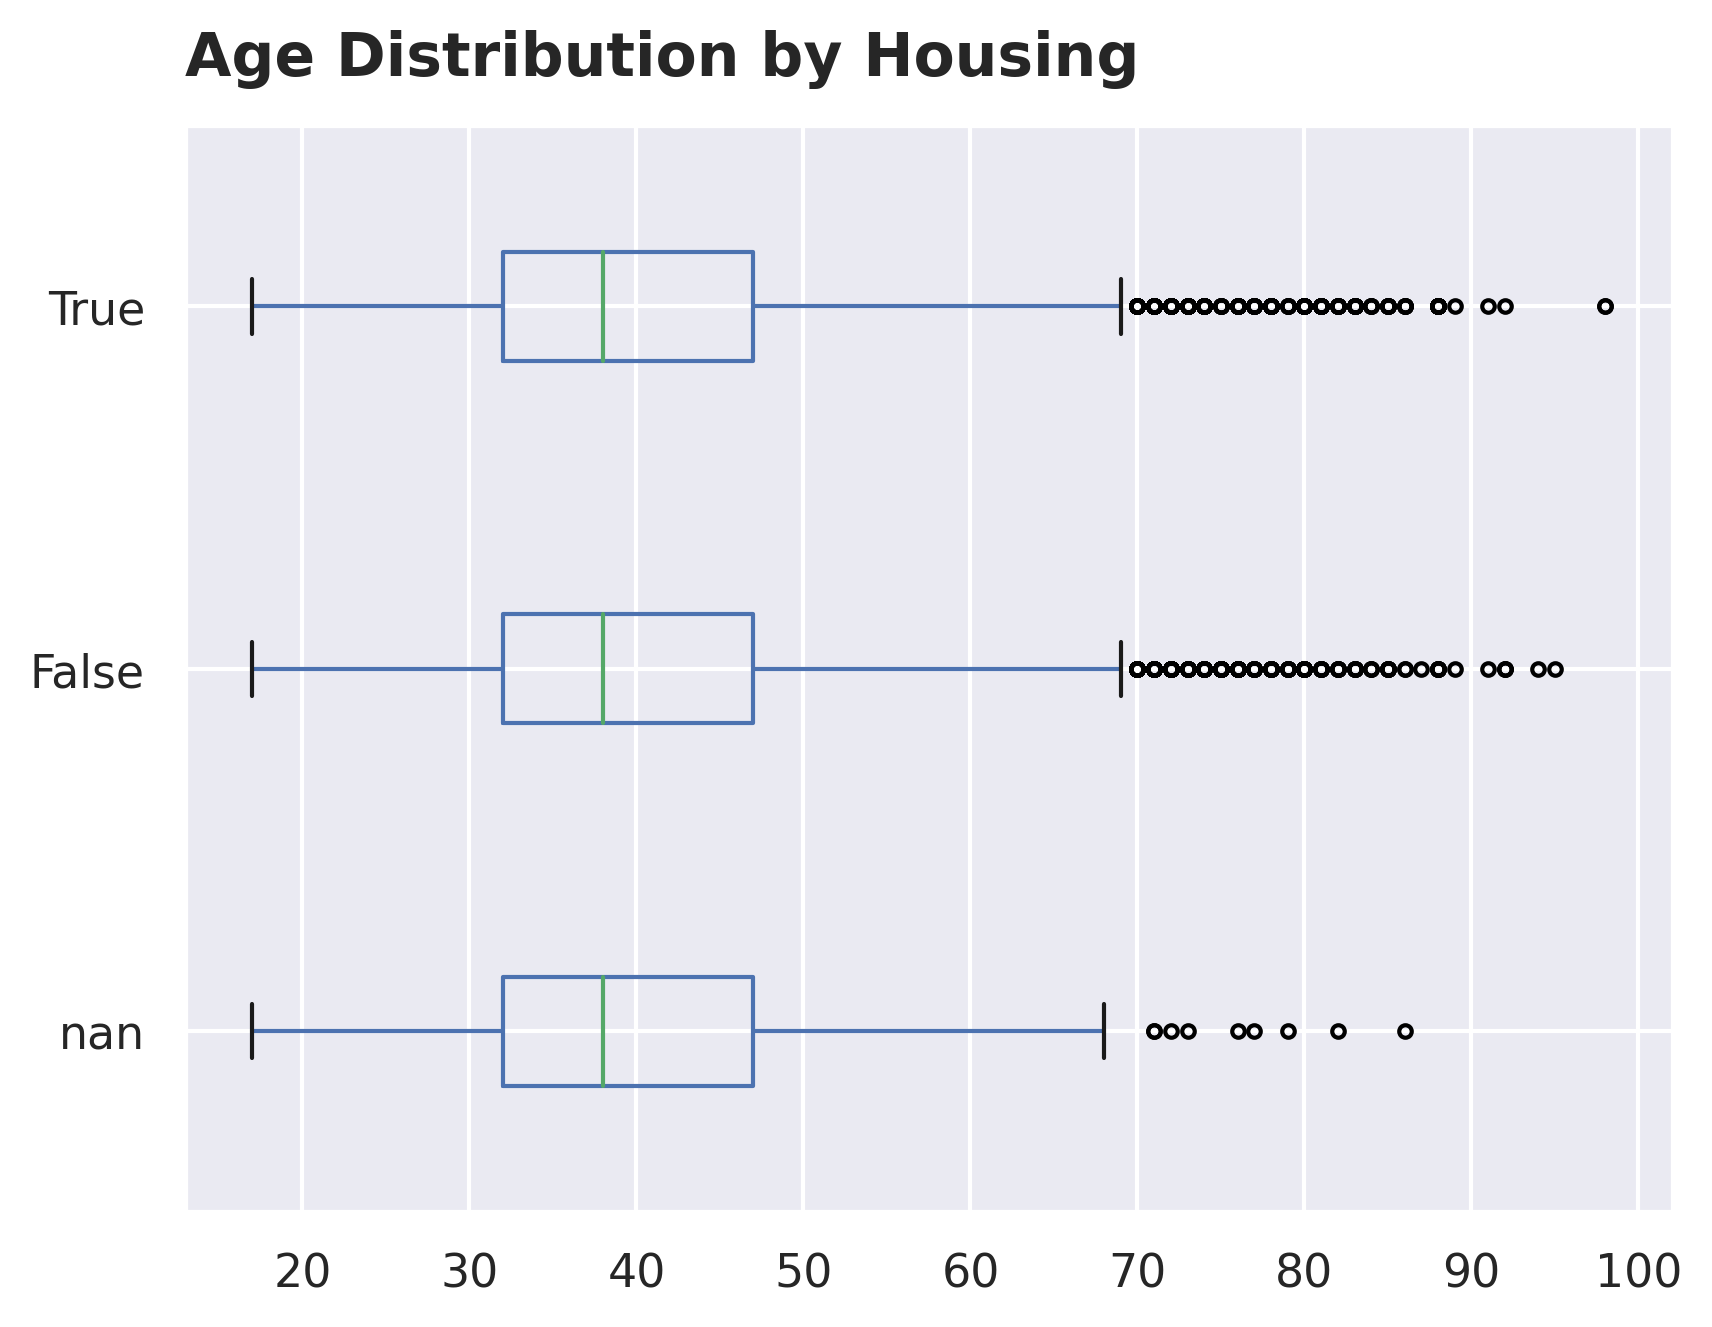

In [ ]:
age_housing = bank_mkt[["age", "housing"]].pivot(columns="housing", values="age")
age_housing_box = age_housing.plot.box(vert=False, sym=".", title="Age Distribution by Housing")

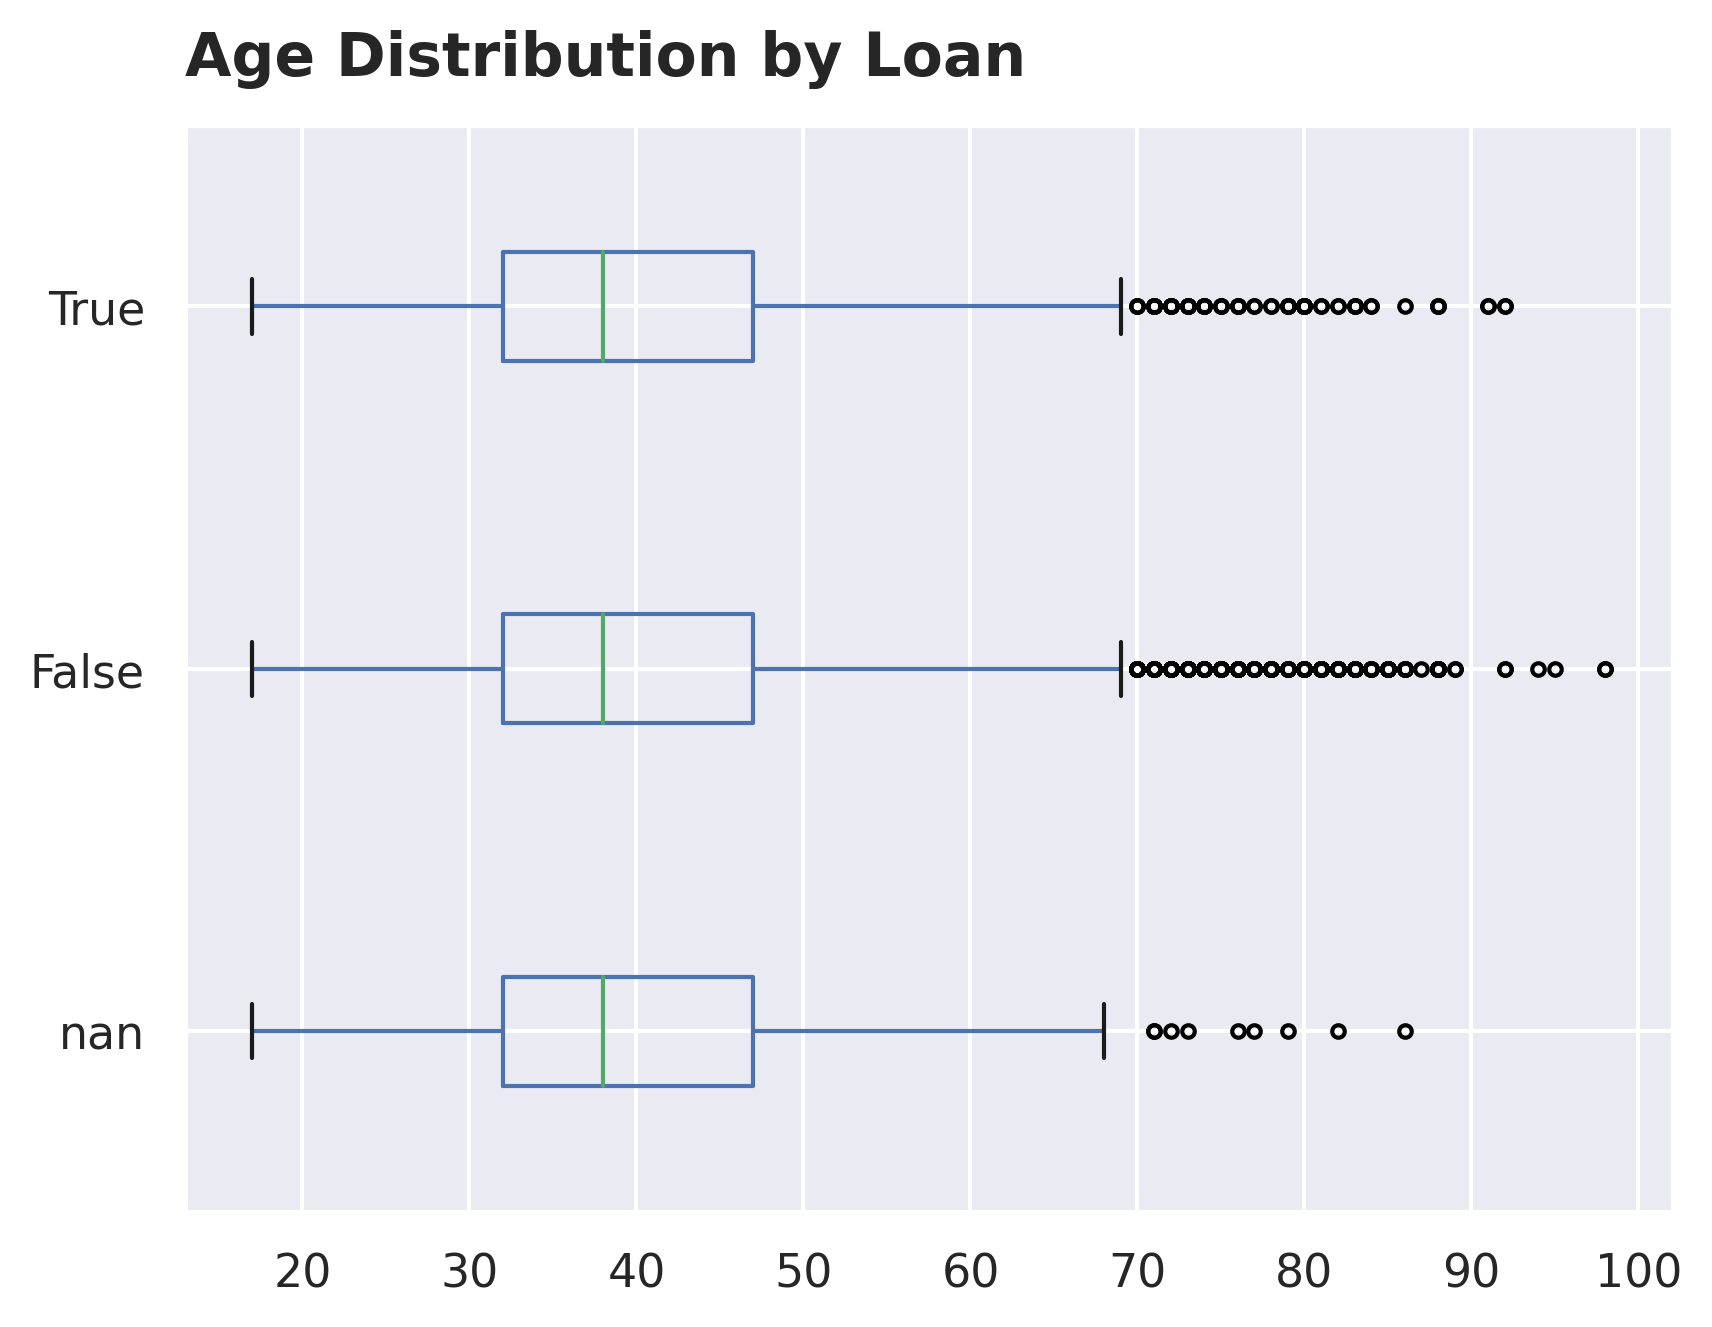

In [ ]:
age_loan = bank_mkt[["age", "loan"]].pivot(columns="loan", values="age")
age_loan_box = age_loan.plot.box(vert=False, sym=".", title="Age Distribution by Loan")

We can then turn to job, eductaion and other categorical data to see their relationship to the outcome.

In [ ]:
def explore_cat(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]):
        df[feature] = df[feature].cat.add_categories('unknown')
        df[feature] = df[feature].fillna("unknown")
    feature_true = df[[feature, "y"]].groupby([feature]).sum().y.rename("True")
    feature_total = df[[feature, "y"]].groupby([feature]).count().y.rename("Total")
    feature_false = feature_total - feature_true
    feature_false = feature_false.rename("False")
    feature_true_rate = feature_true / feature_total
    feature_true_rate = feature_true_rate.rename("True Percentage")
    explore_df = pd.concat([feature_true, feature_false, feature_total, feature_true_rate], axis=1).reset_index()
    return explore_df

In [ ]:
def cat_outcome(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]) and df[feature].isna().sum() > 0:
        df[feature] = df[feature].cat.add_categories("unknown")
        df[feature] = df[feature].fillna("unknown")
    title = feature.title().replace("_", " ").replace("Of", "of")
    f, axs = plt.subplots(1, 2, figsize=(8.6, 4.8), sharey=True, gridspec_kw=dict(wspace=0.04, width_ratios=[5, 2]))
    ax0 = df["y"].groupby(df[feature], dropna=False).value_counts(normalize=True).unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[0], title=f"Outcome Percentage and Total by {title}")
    ax1 = df["y"].groupby(df[feature], dropna=False).value_counts().unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[1])

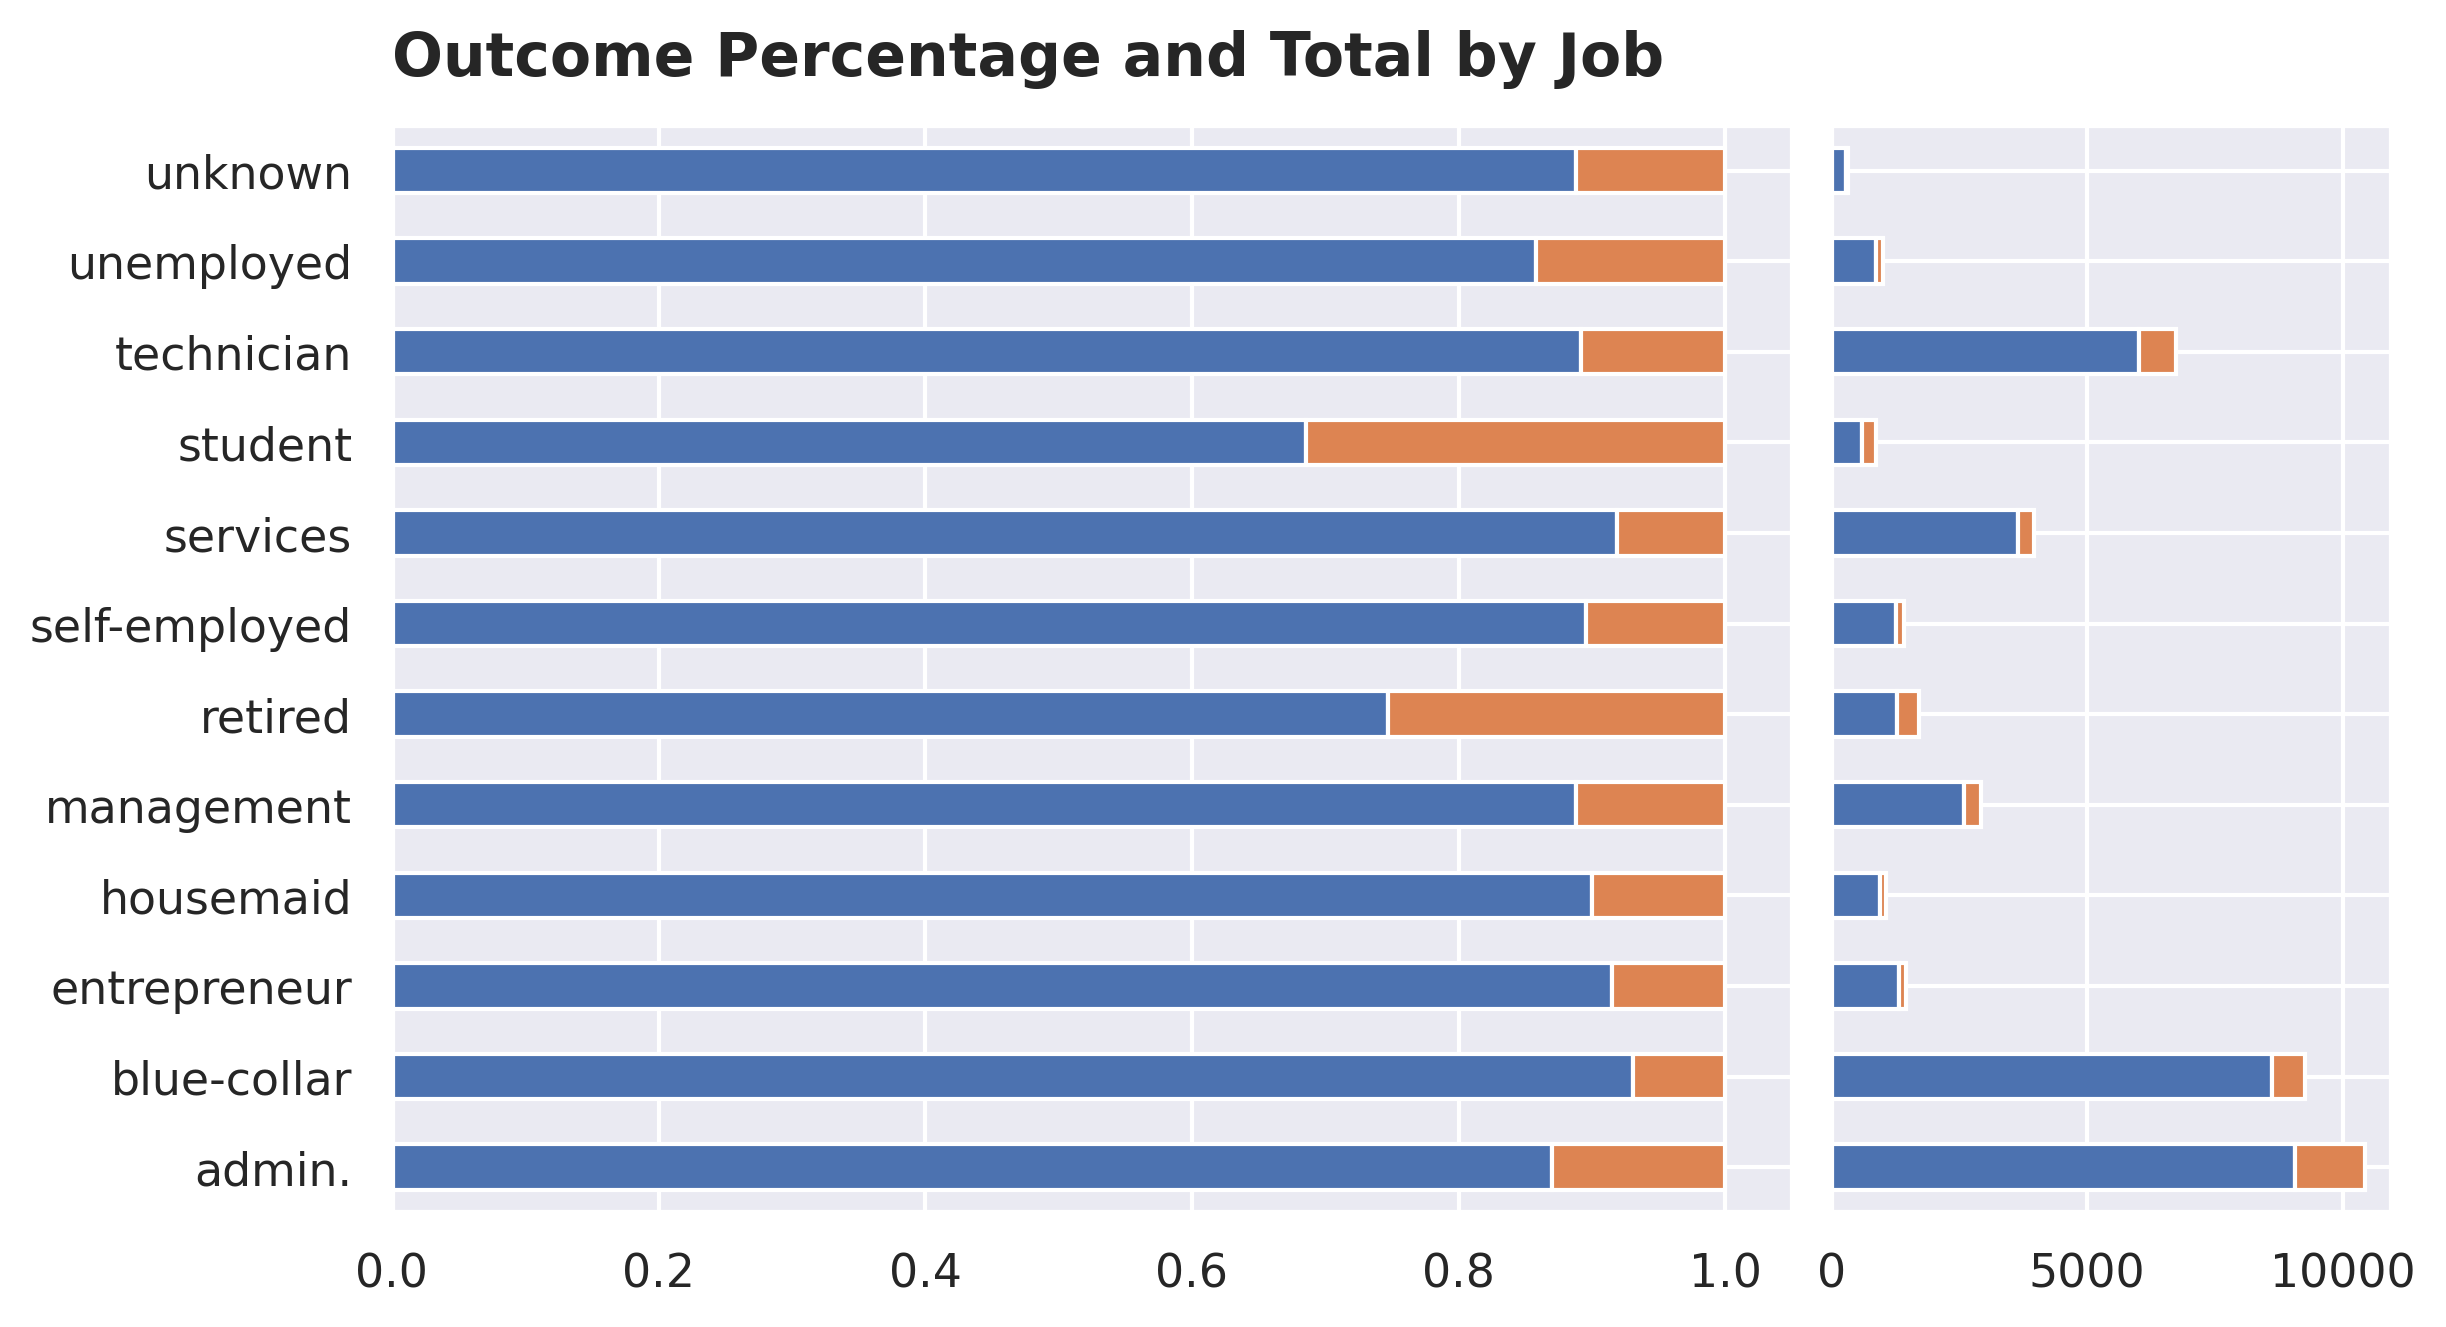

In [ ]:
job_outcome = cat_outcome(bank_mkt, "job")

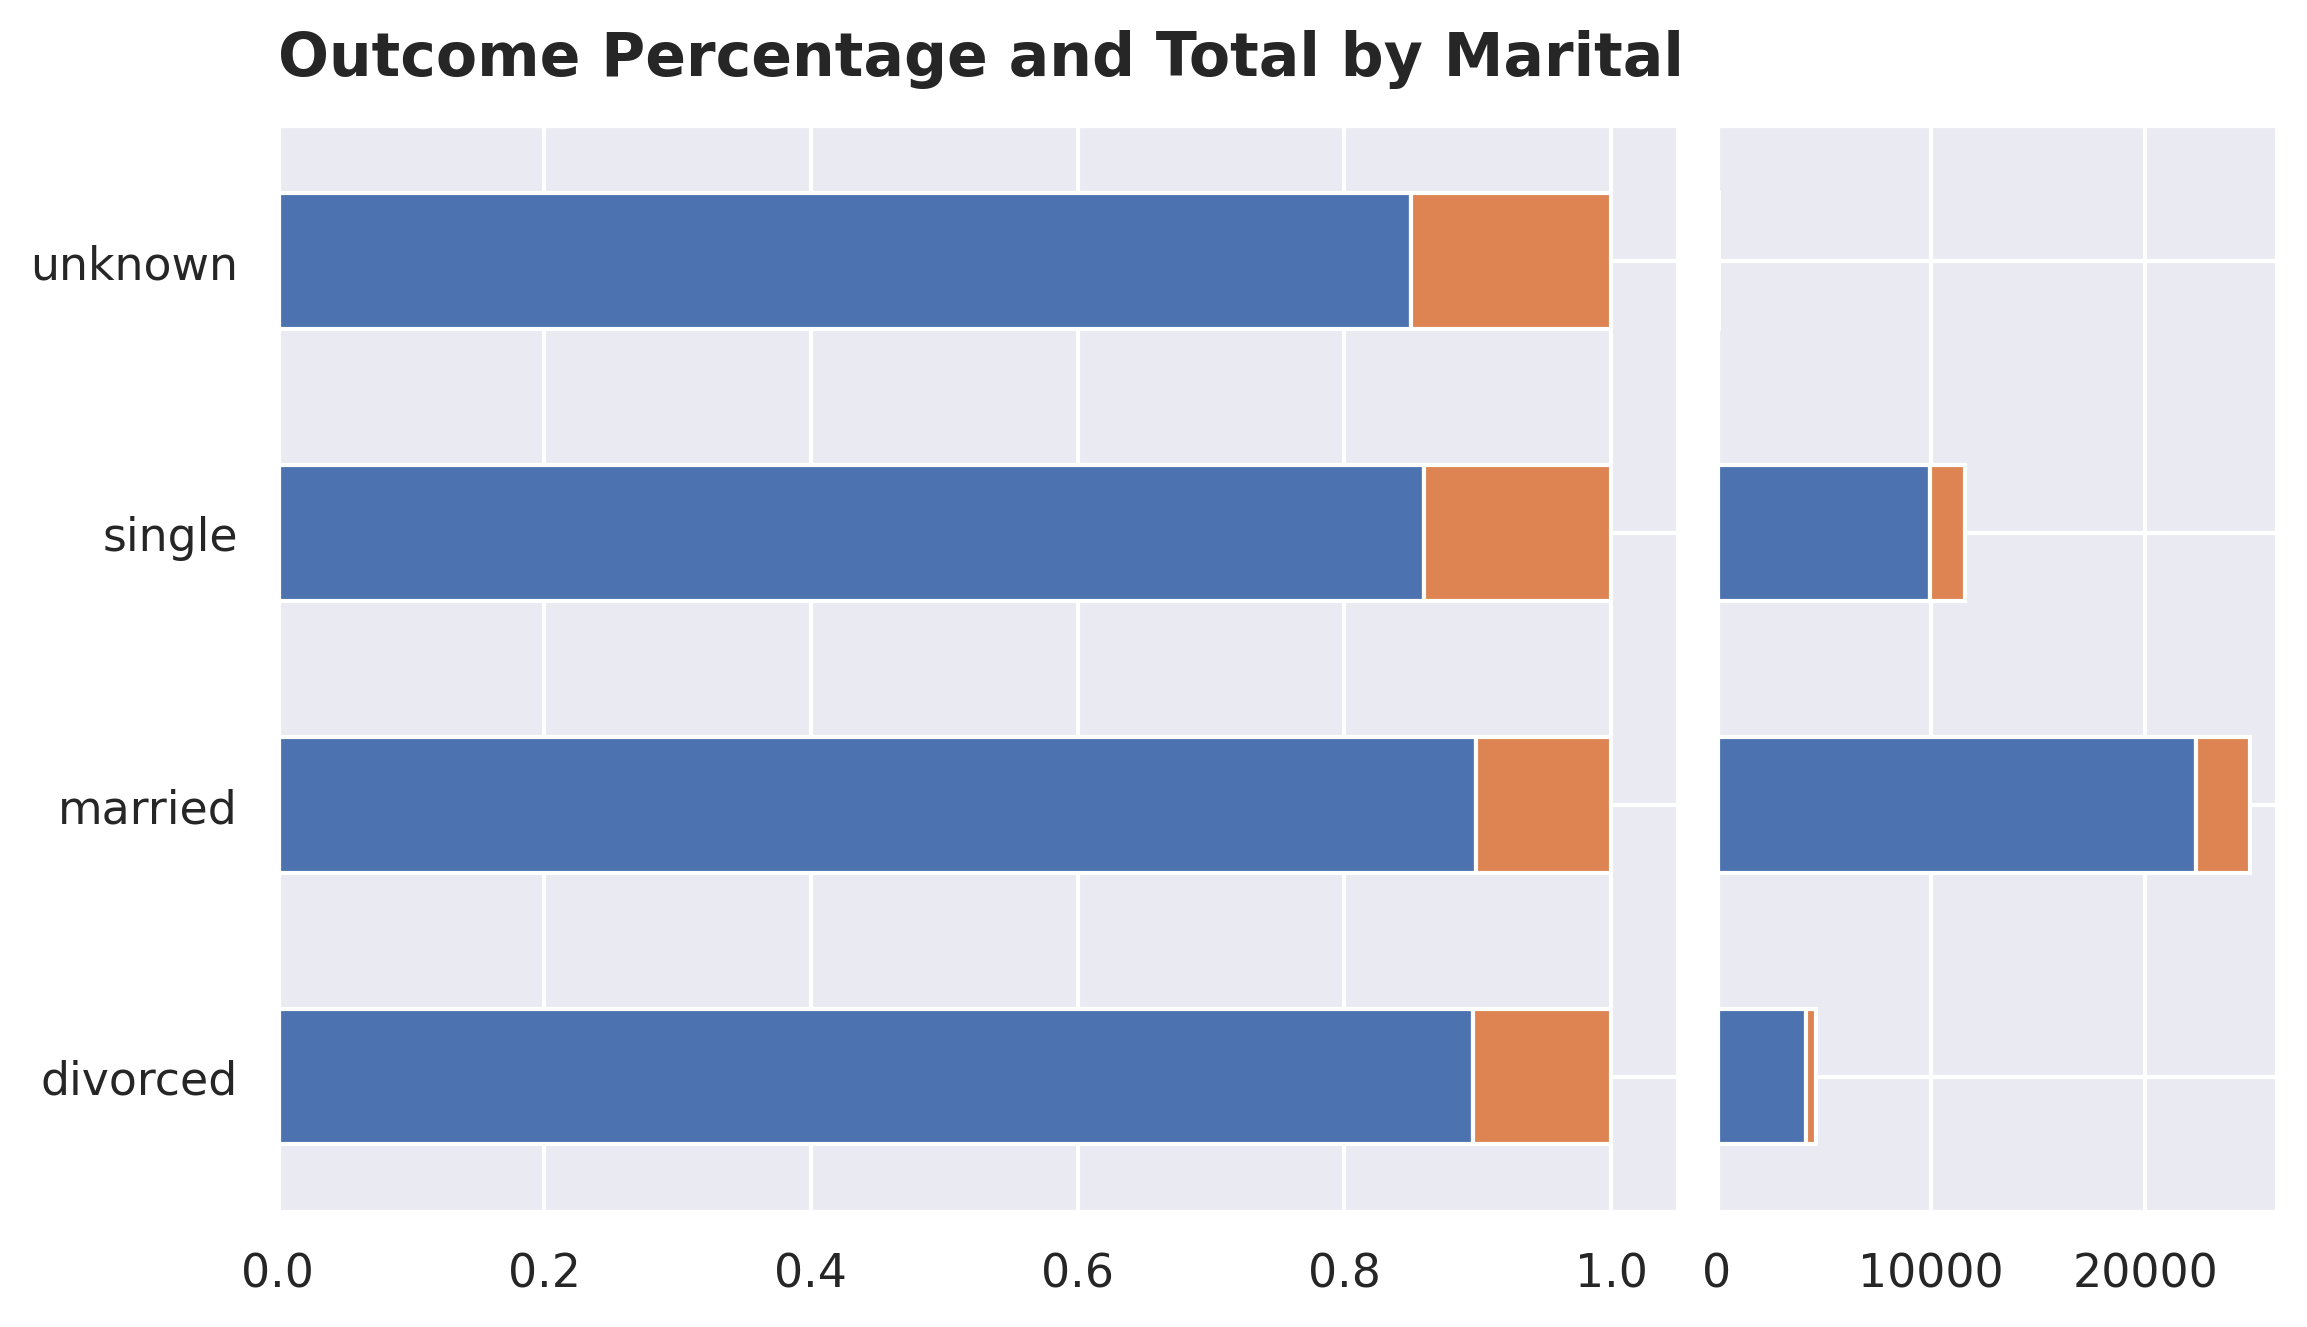

In [ ]:
marital_outcome = cat_outcome(bank_mkt, "marital")

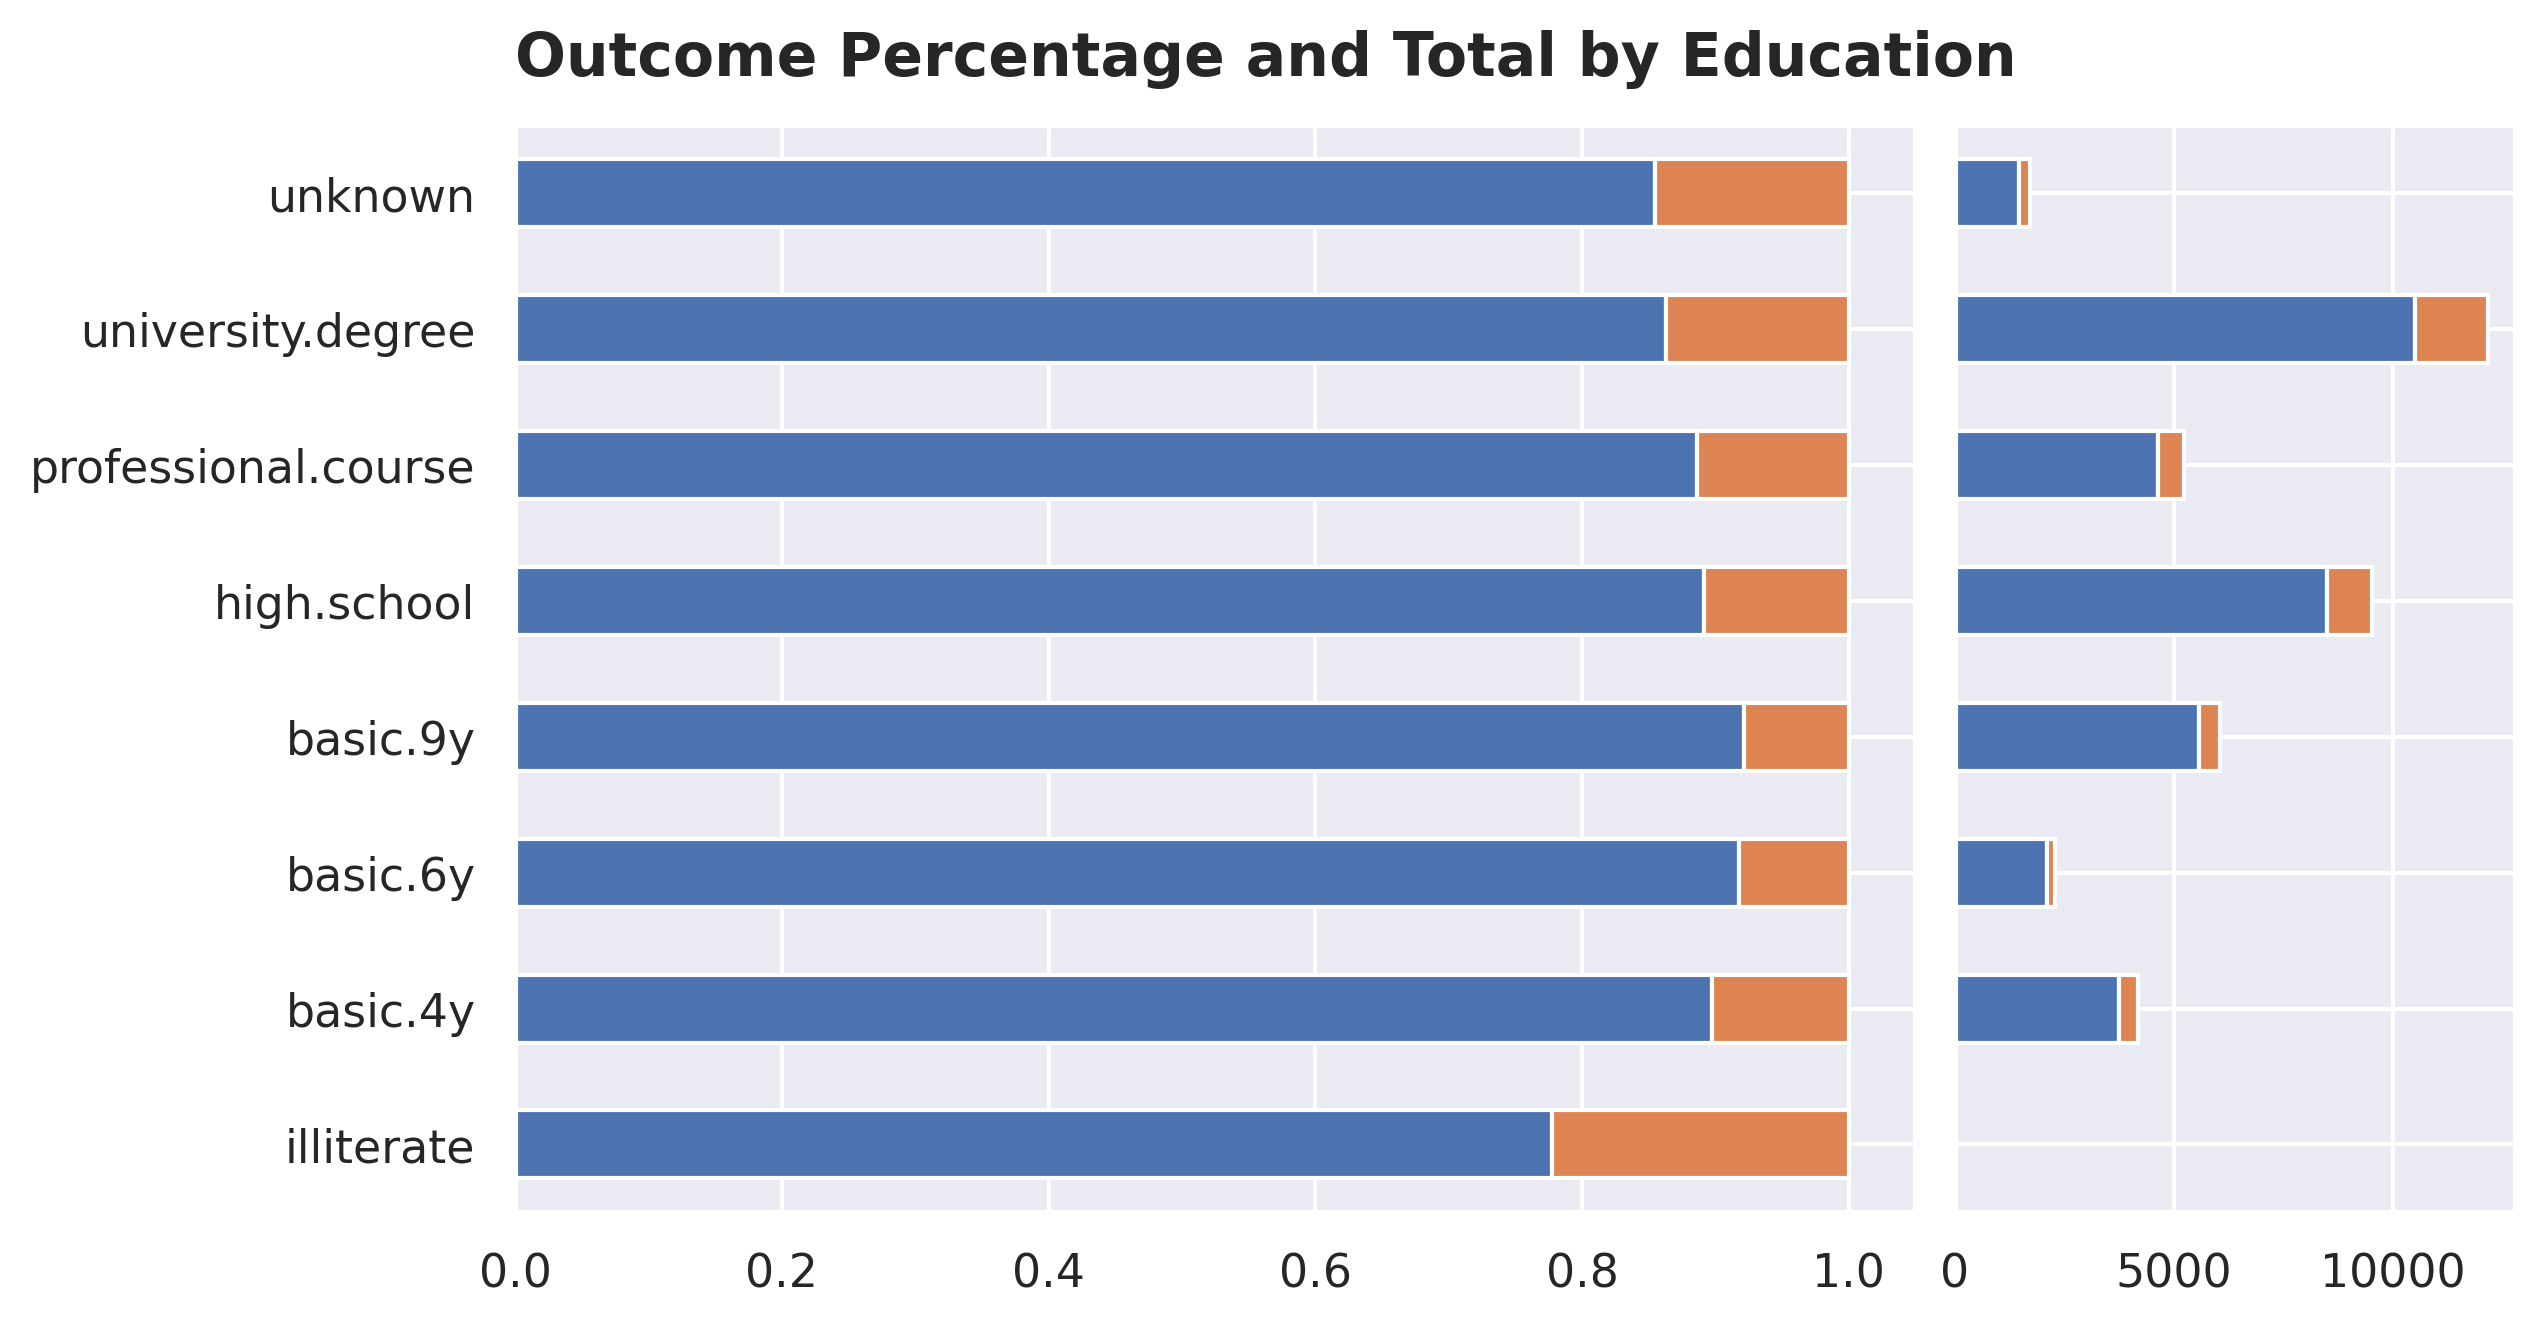

In [ ]:
education_outcome = cat_outcome(bank_mkt, "education")

In [ ]:
bank_mkt["default"].value_counts()

False    32577
True         3
Name: default, dtype: Int64

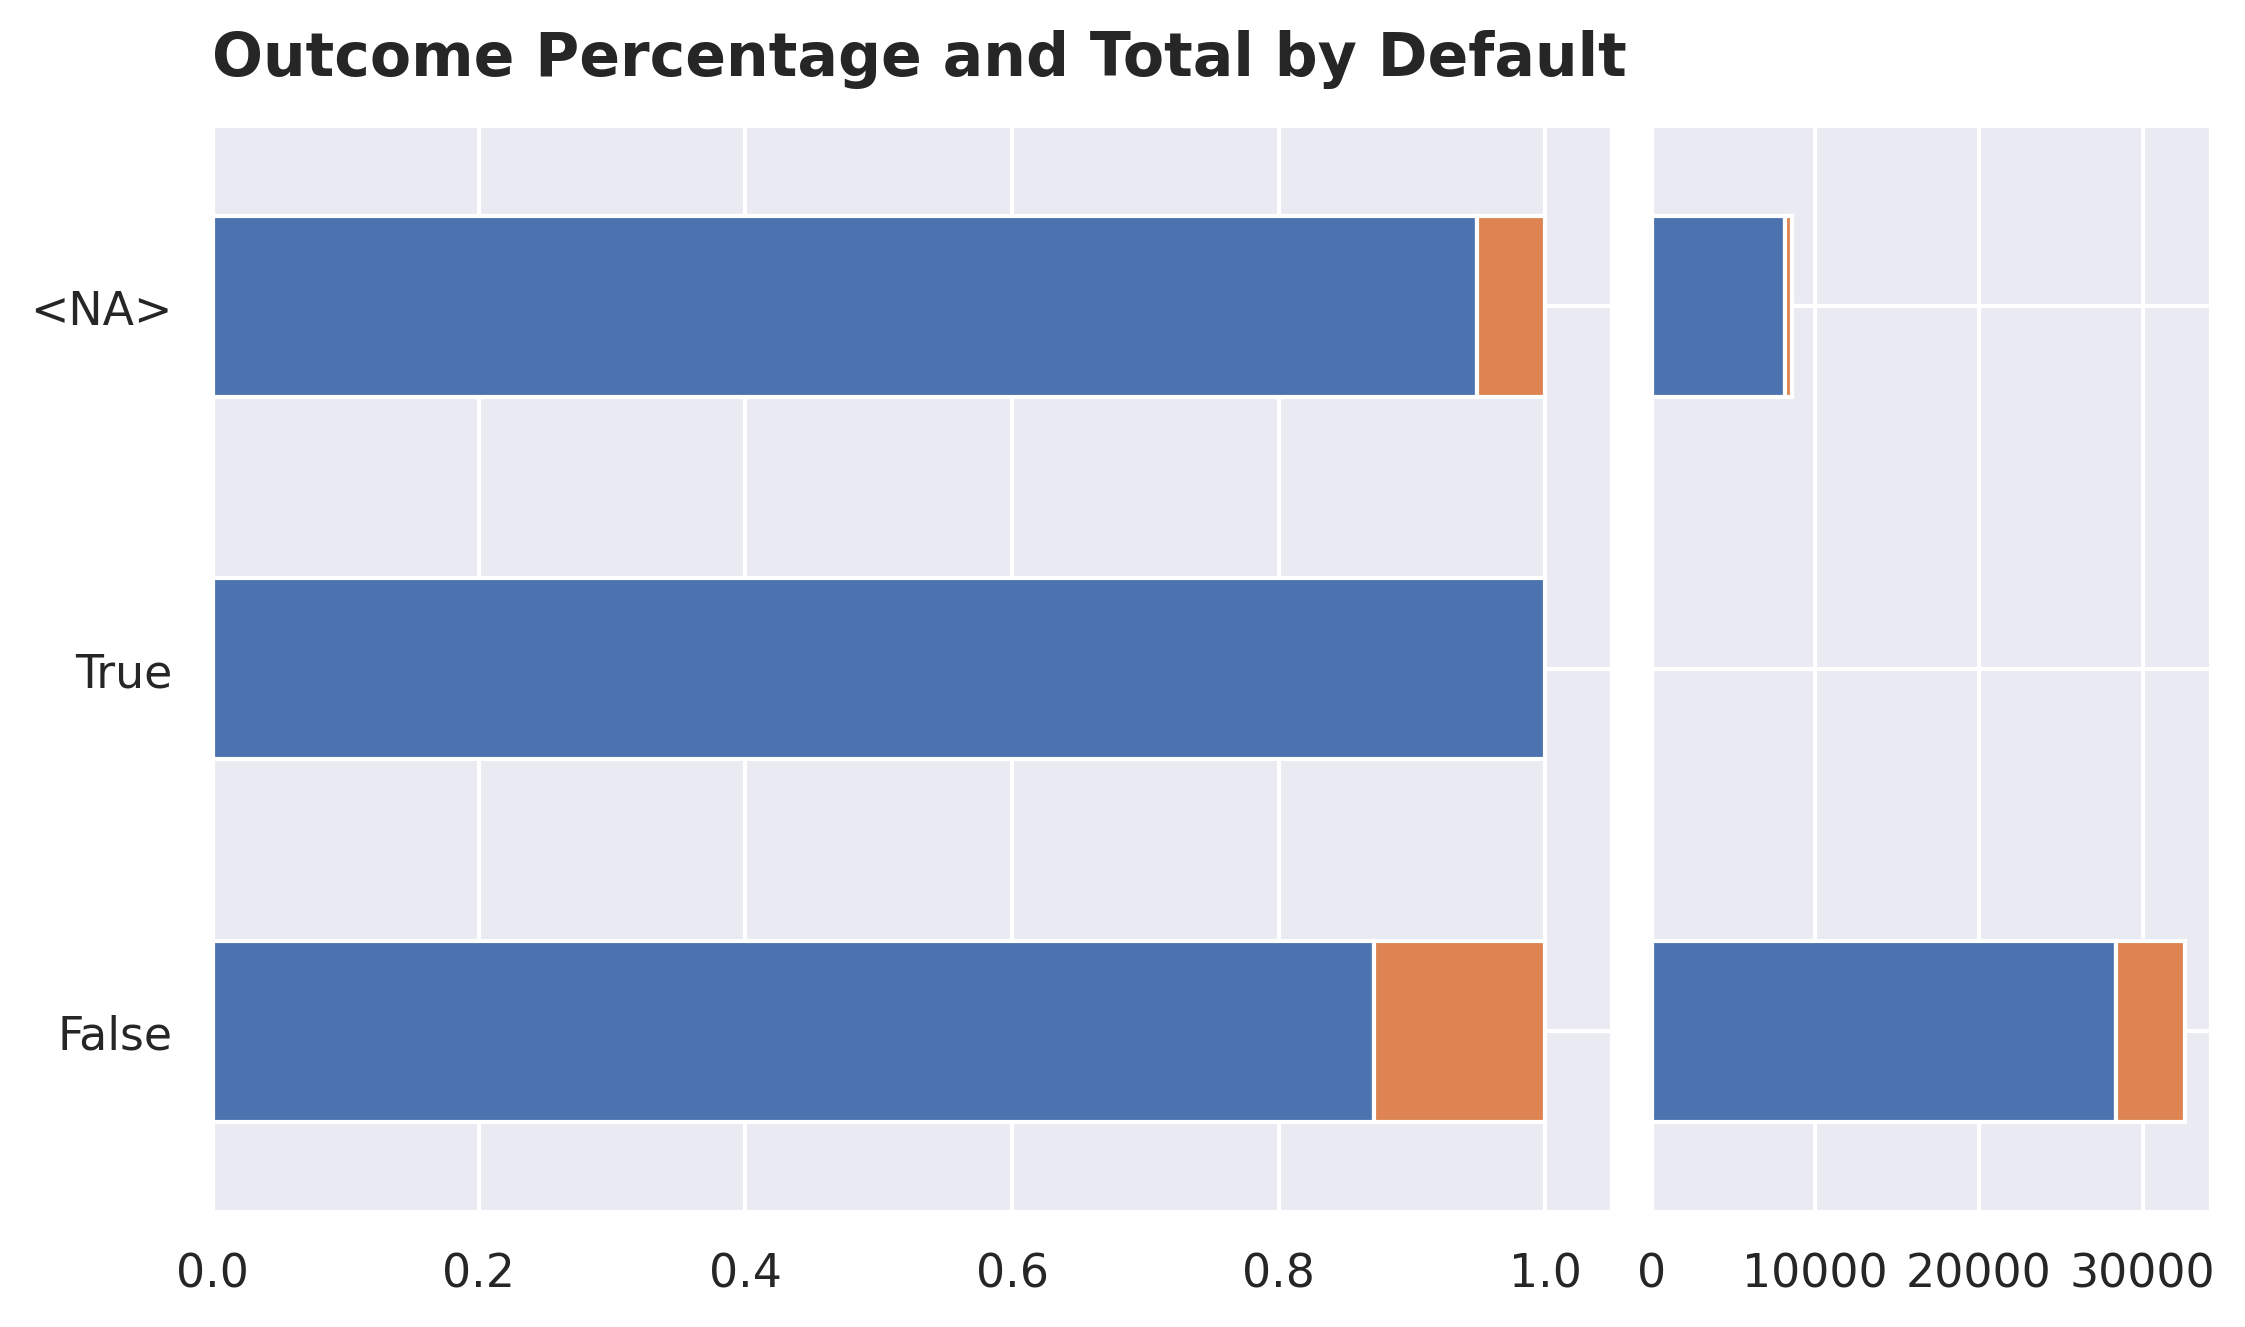

In [ ]:
default_outcome = cat_outcome(bank_mkt, "default")

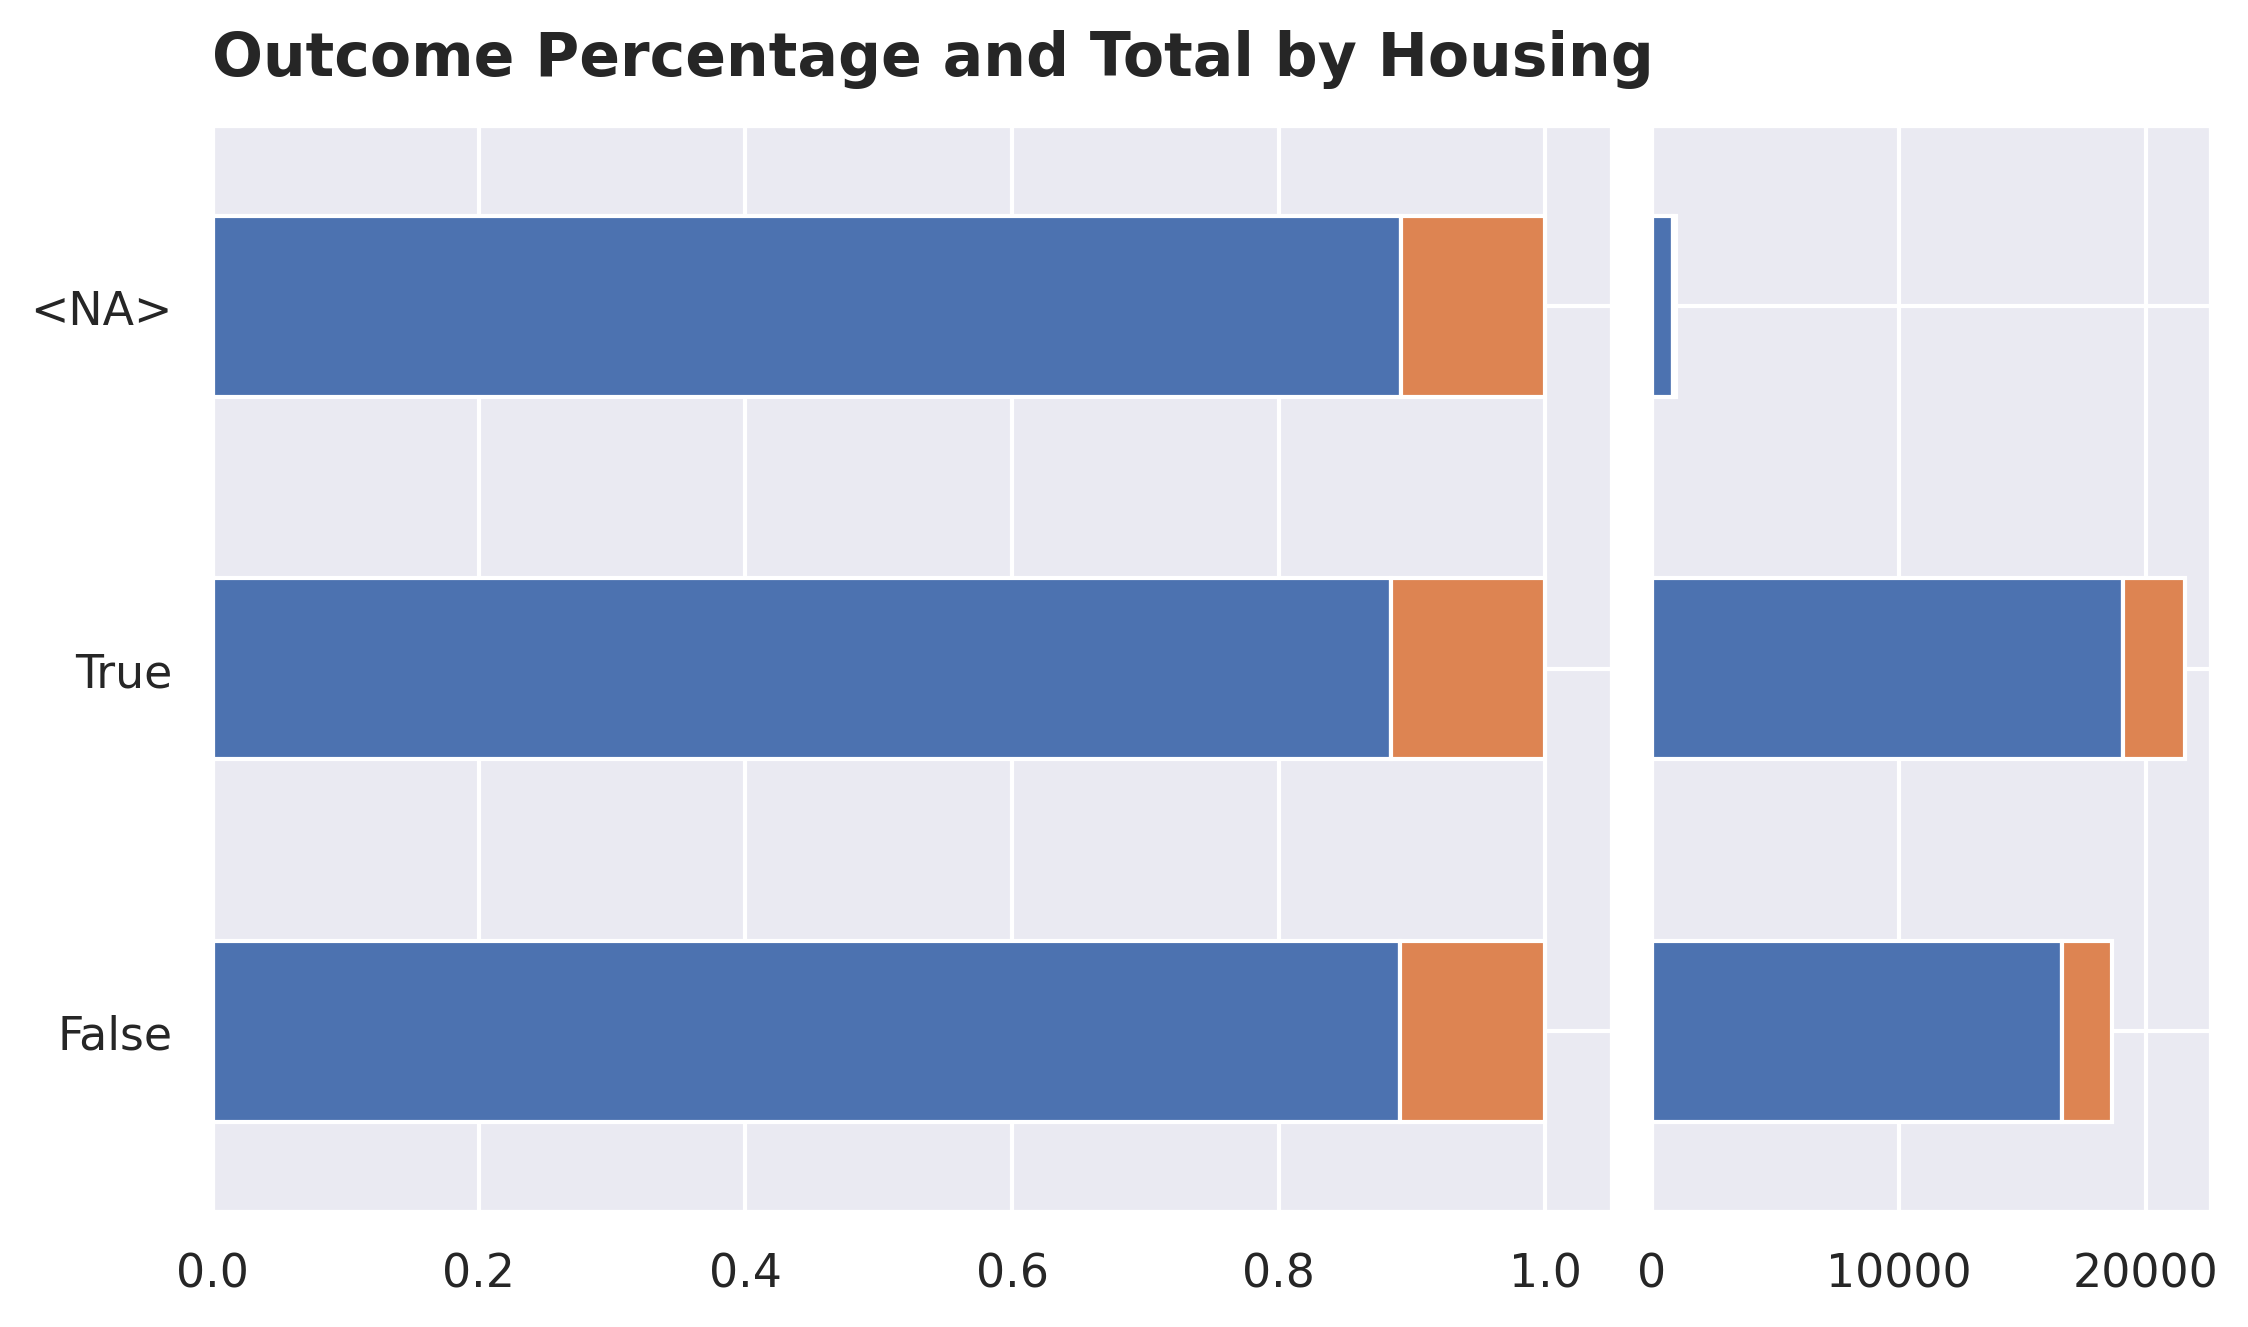

In [ ]:
housing_outcome = cat_outcome(bank_mkt, "housing")

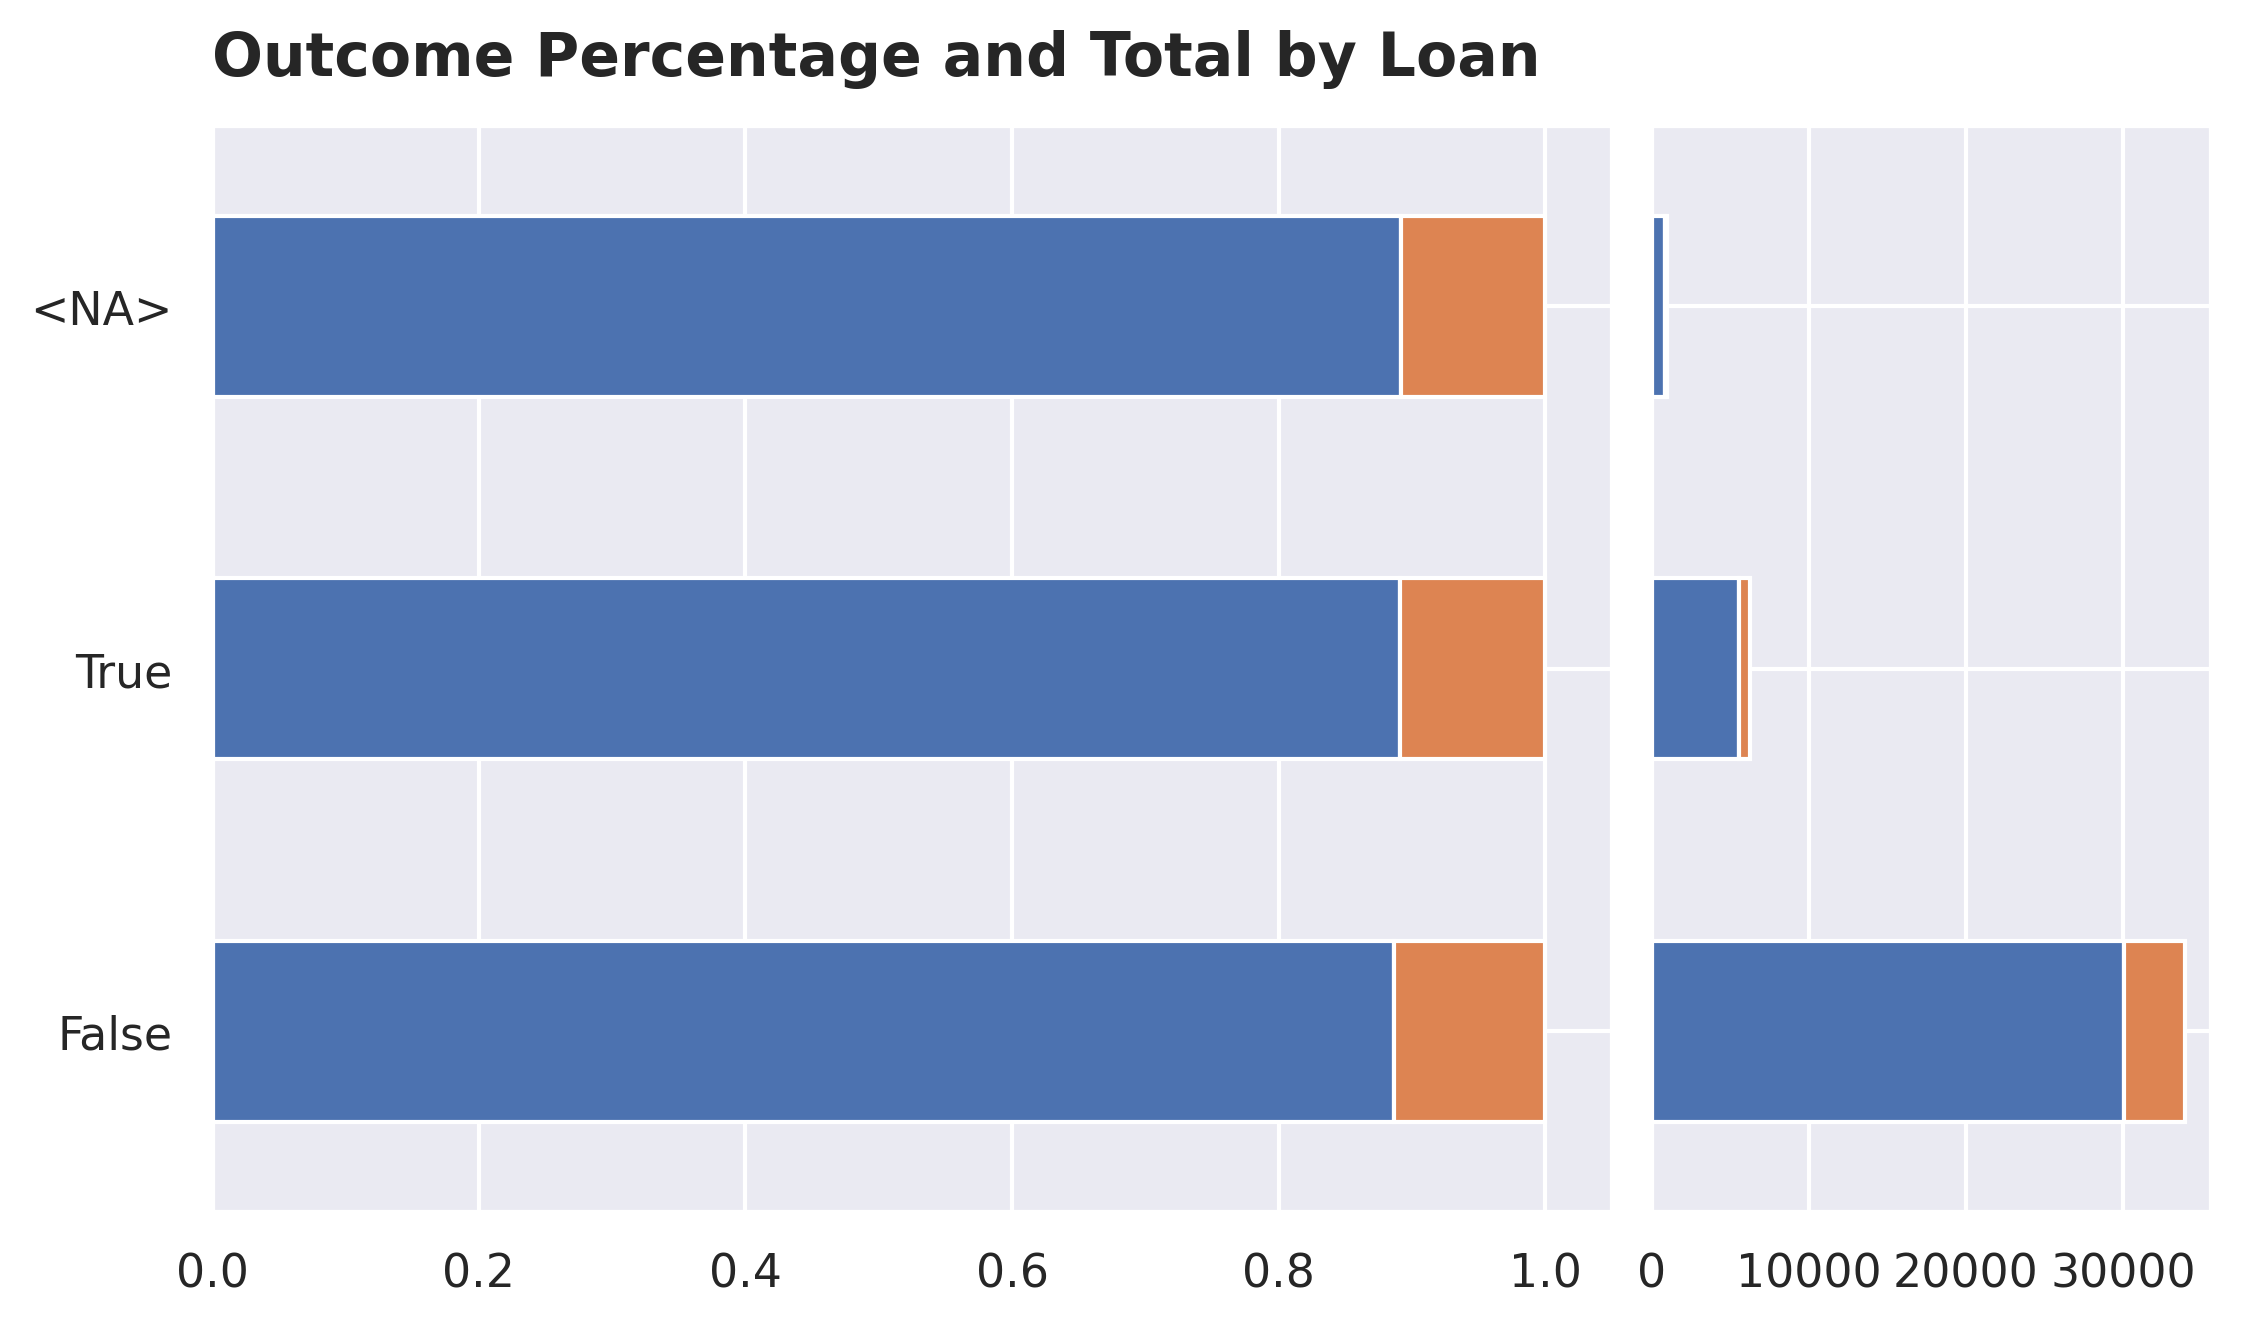

In [ ]:
loan_outcome = cat_outcome(bank_mkt, "loan")

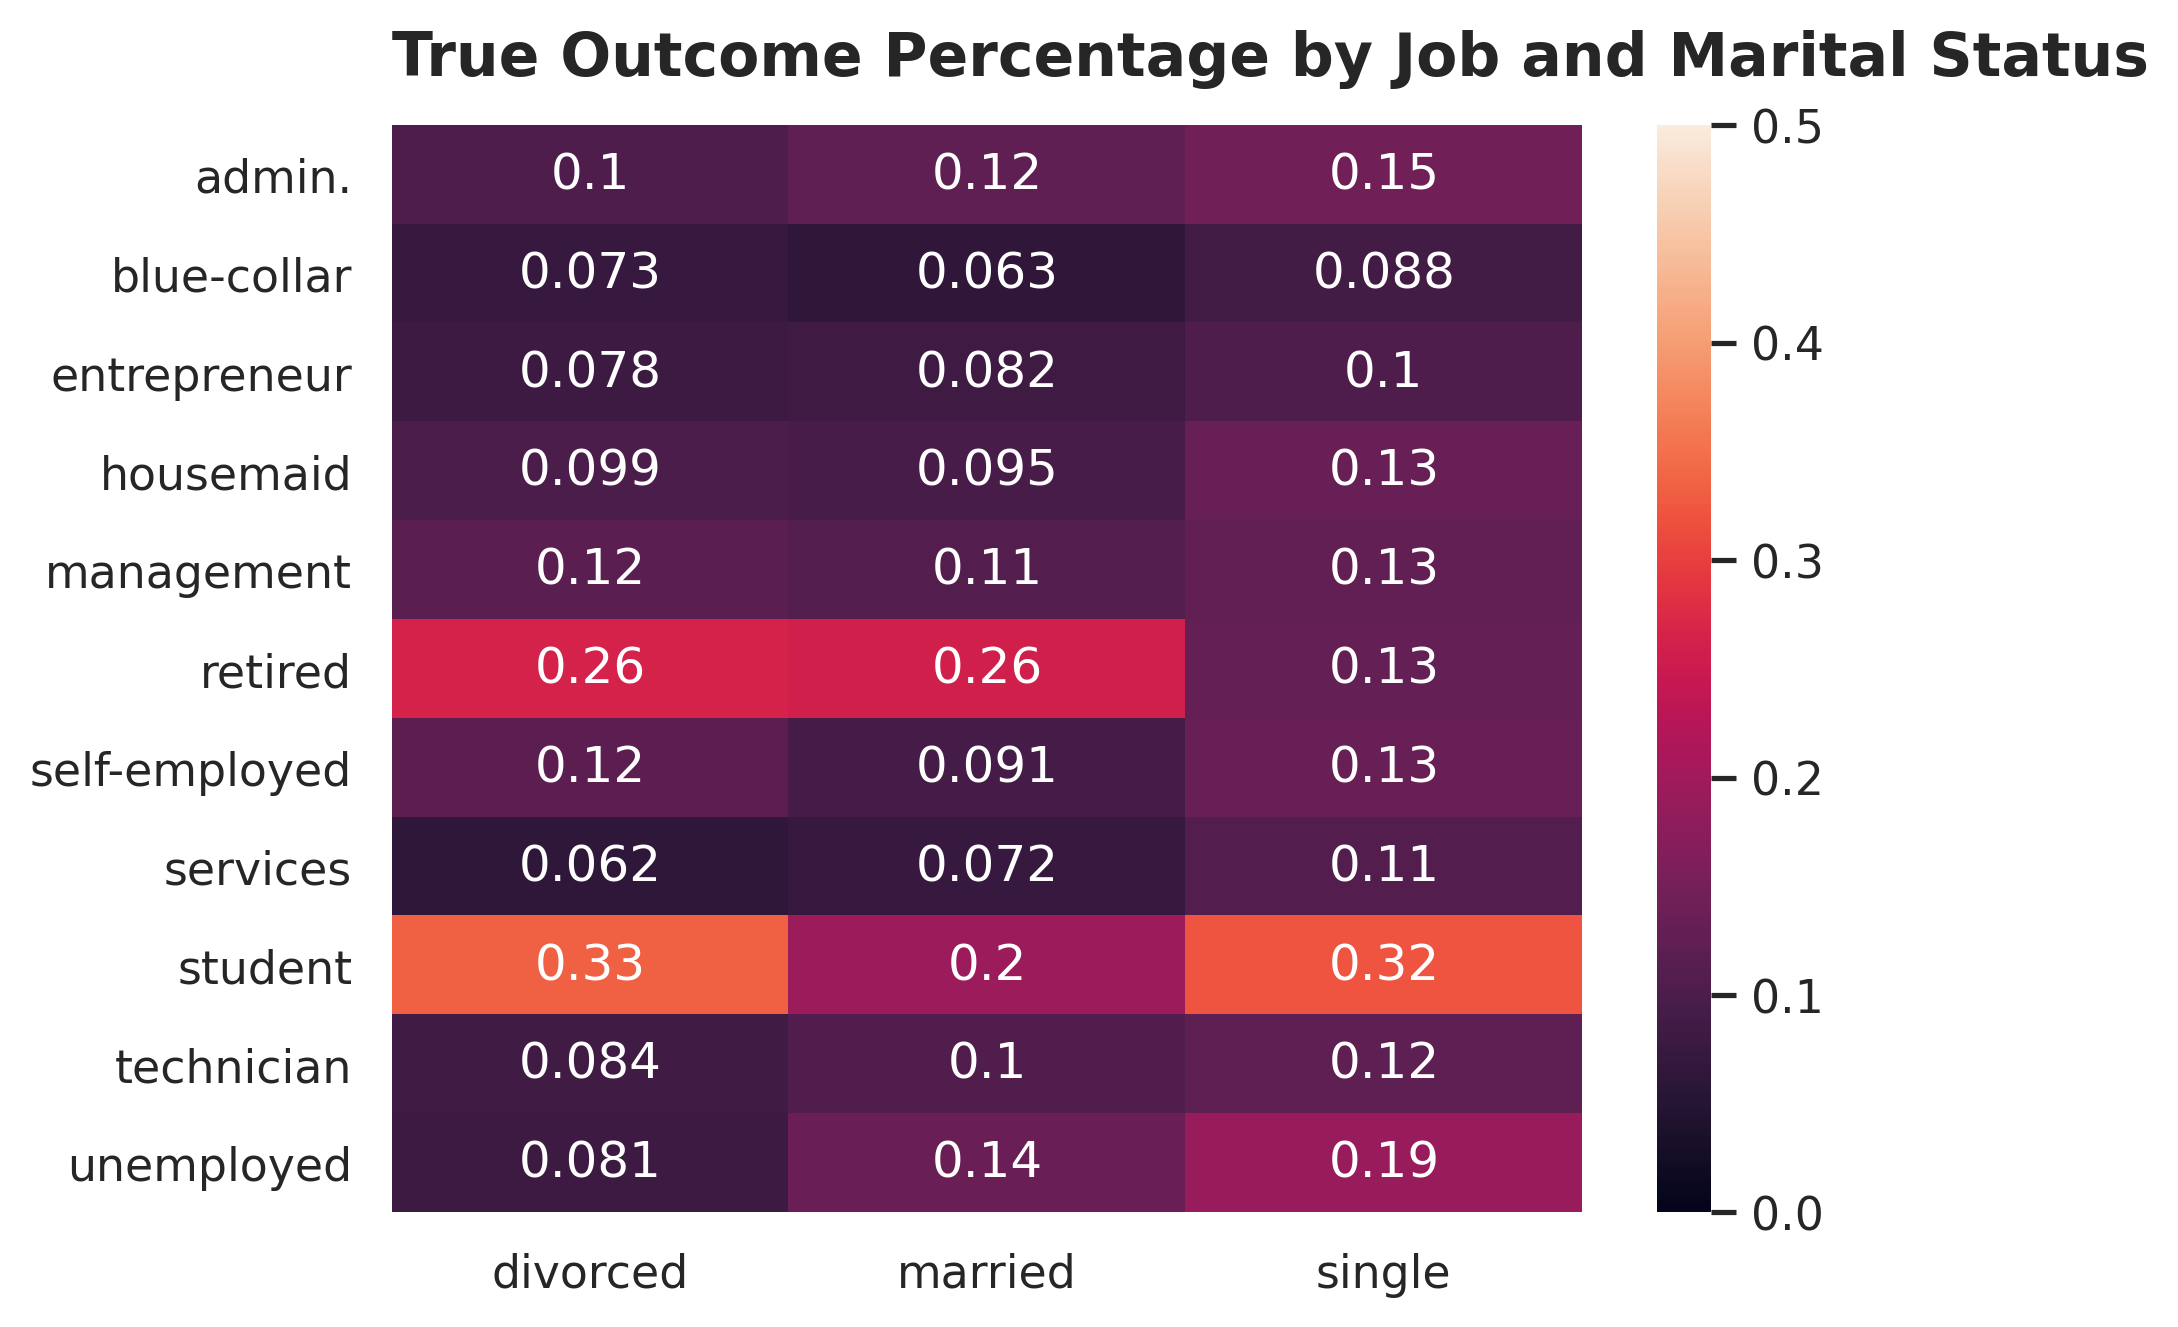

In [ ]:
job_marital_total = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).count().y.unstack()
job_marital_true = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).sum().y.unstack()
job_marital_rate = job_marital_true / job_marital_total
job_marital_rate = job_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_marital_heatmap = sns.heatmap(data=job_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Marital Status")

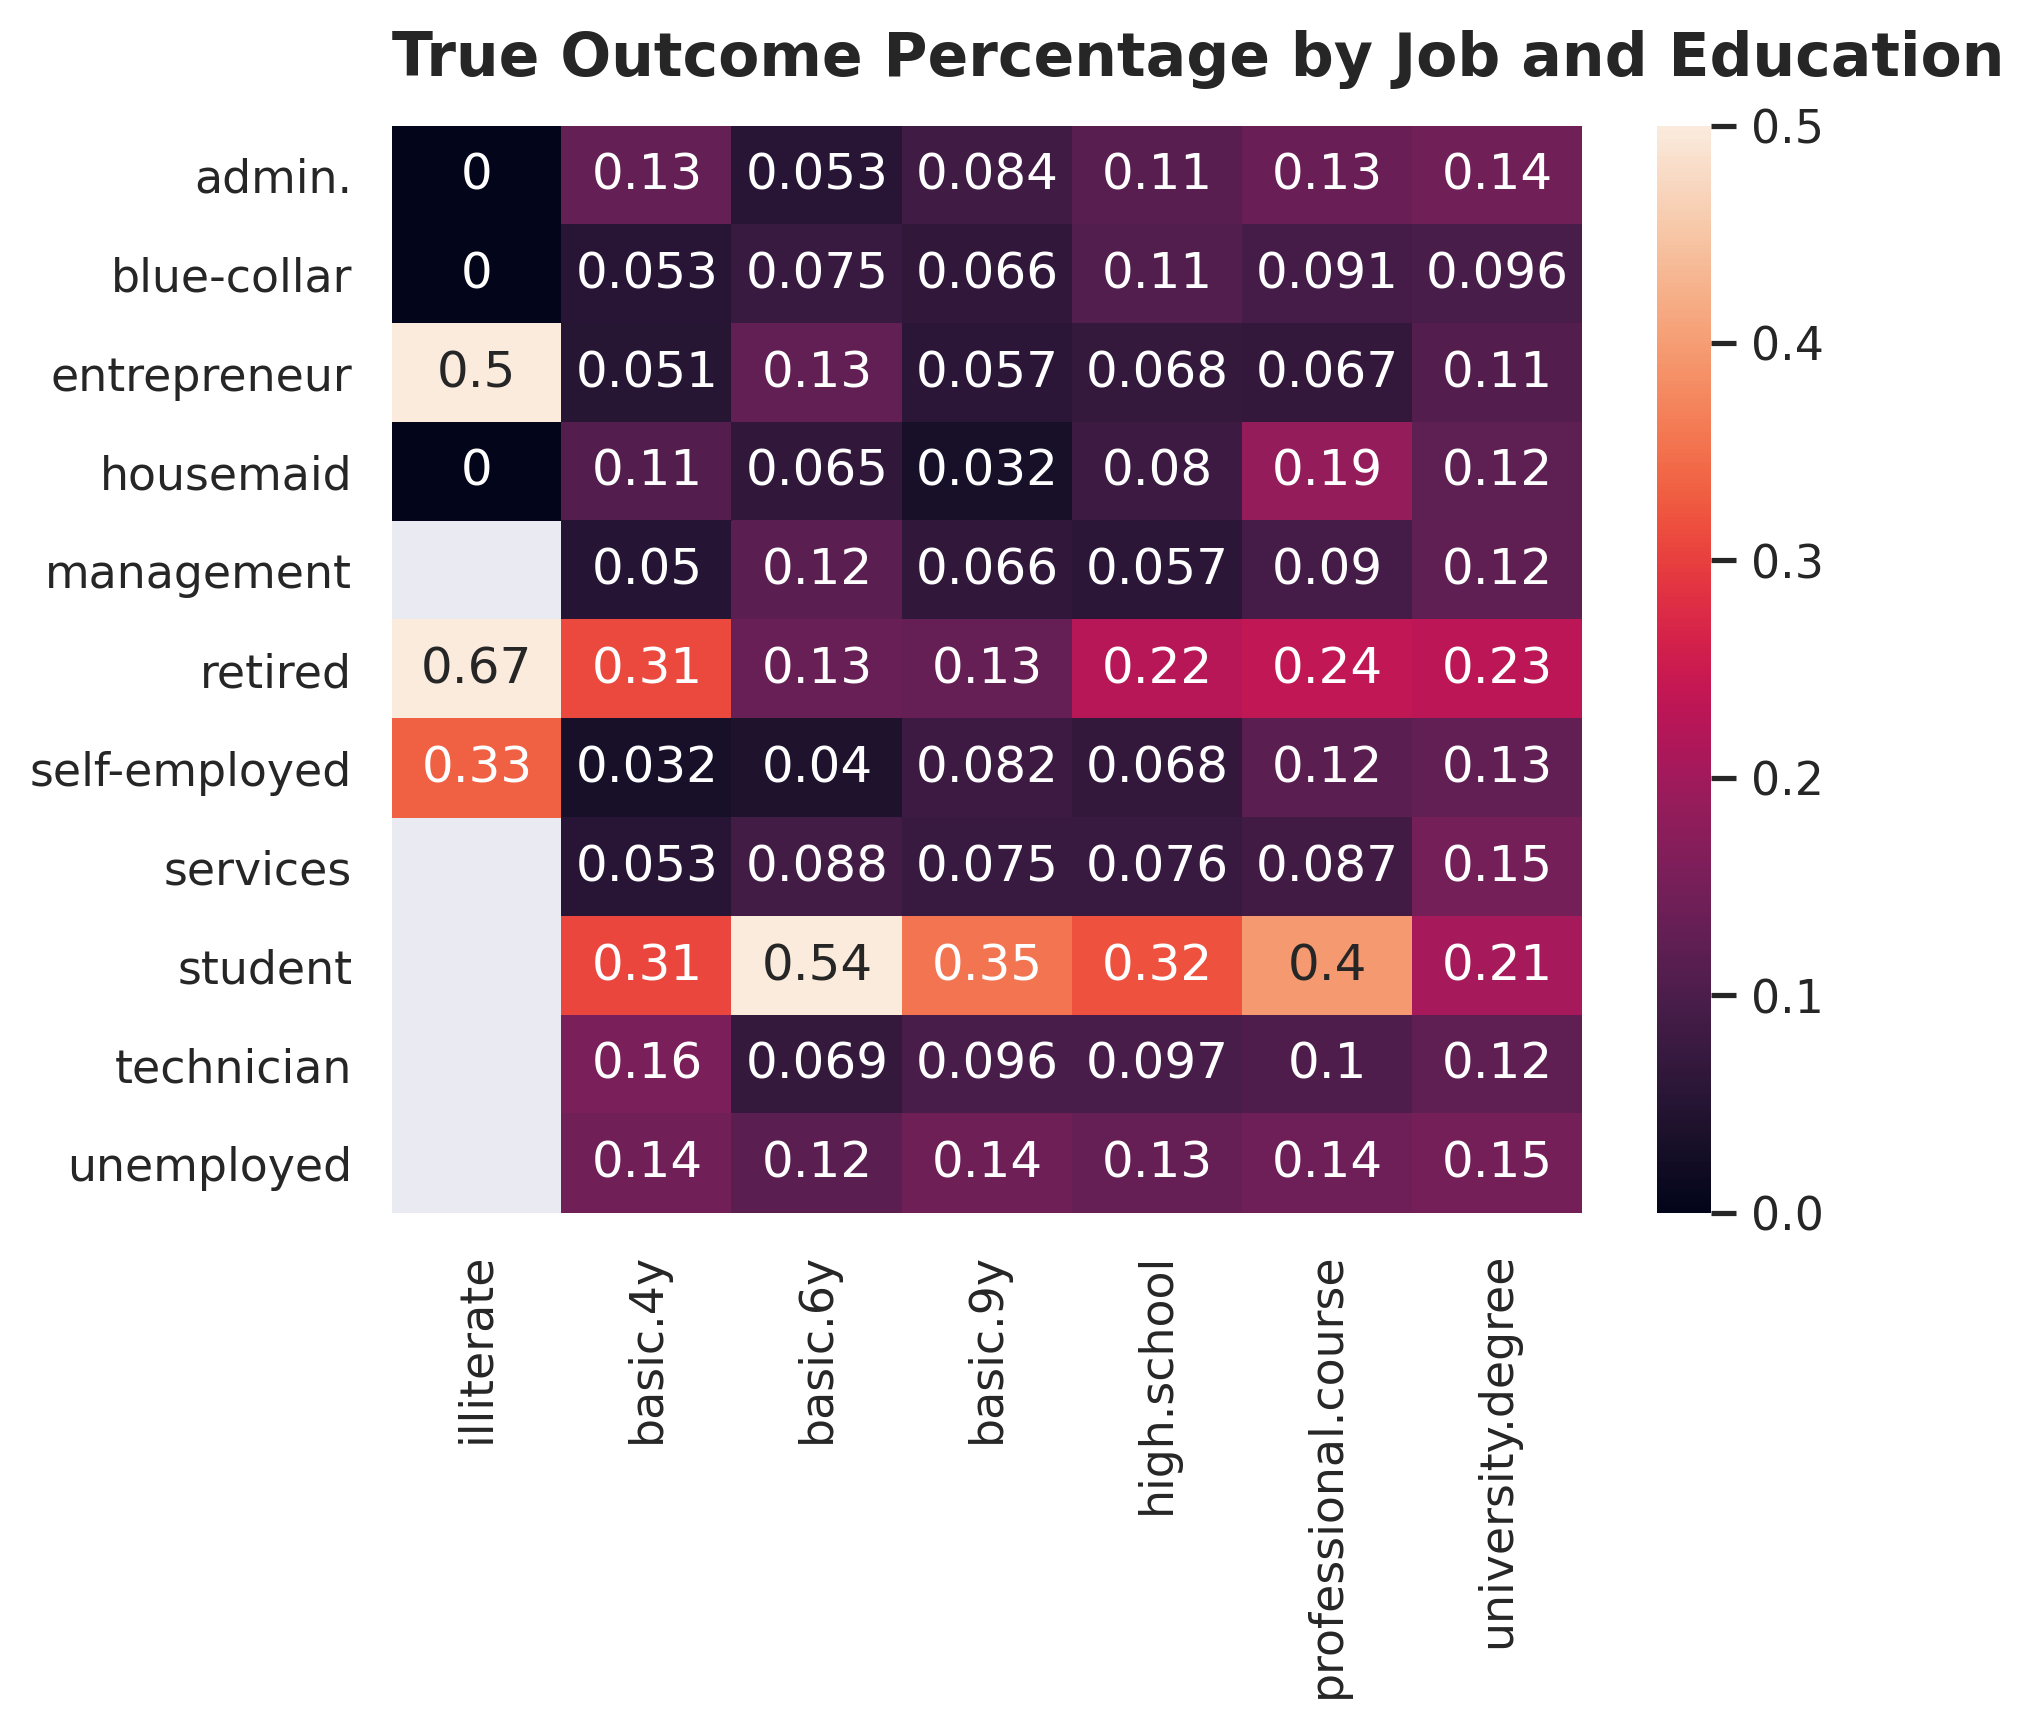

In [ ]:
job_education_total = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).count().y.unstack()
job_education_true = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).sum().y.unstack()
job_education_rate = job_education_true / job_education_total
job_education_rate = job_education_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_education_heatmap = sns.heatmap(data=job_education_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Education")

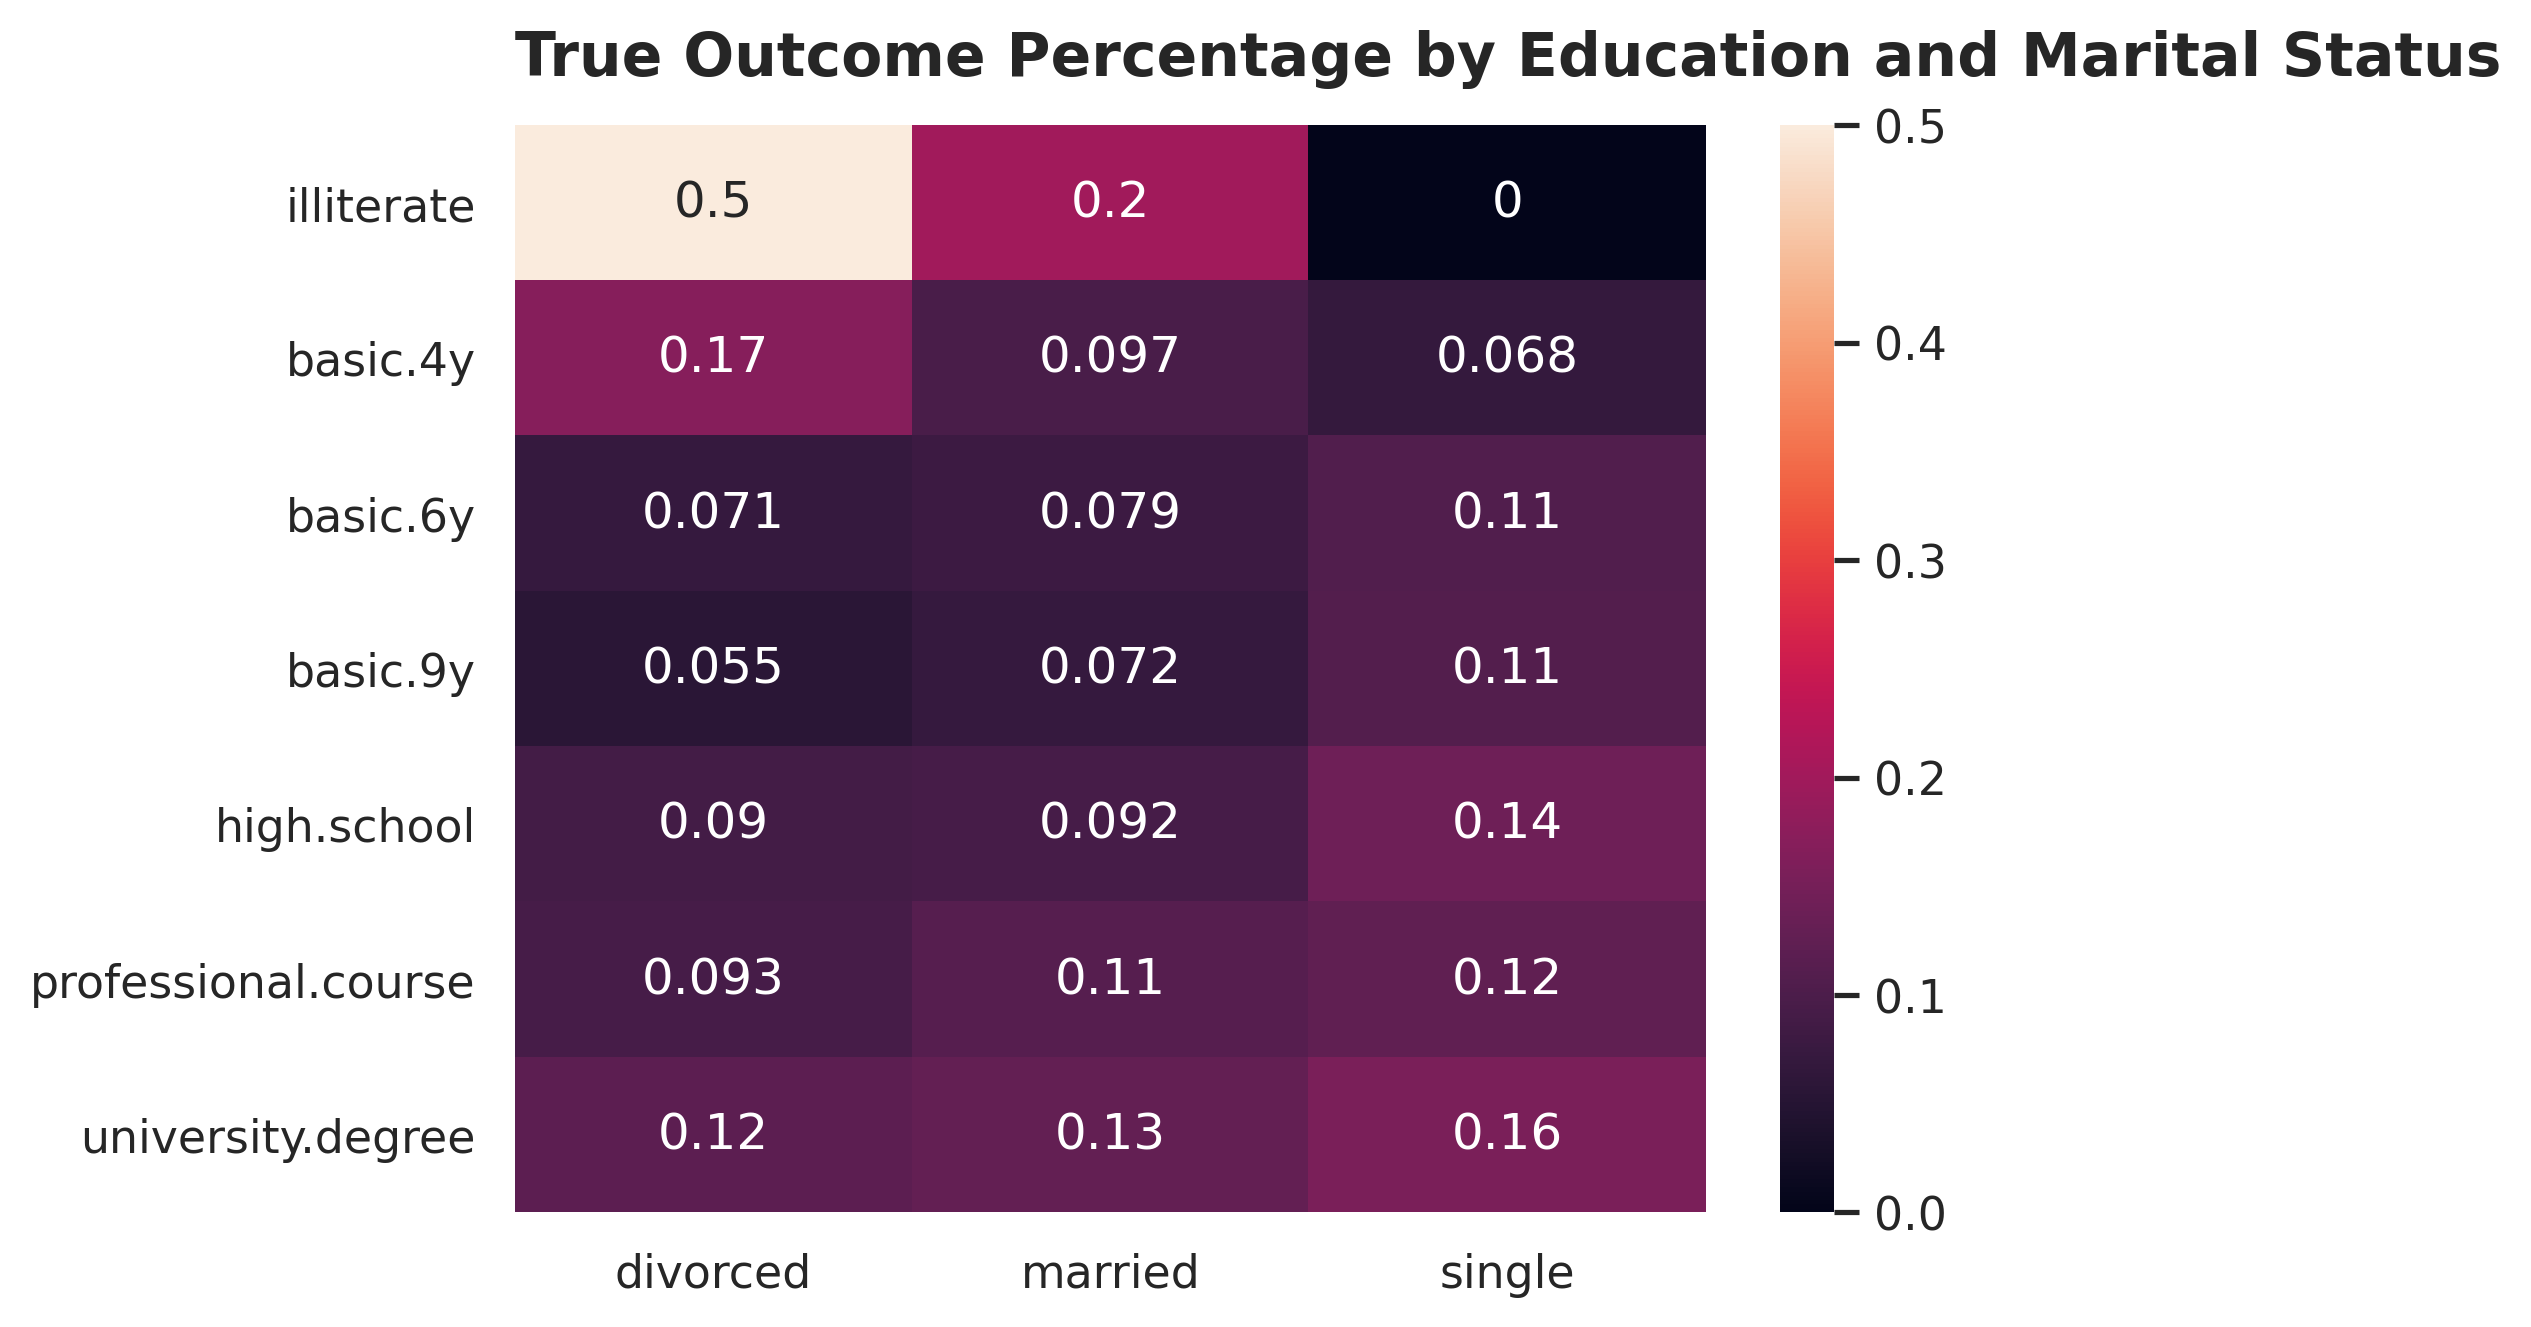

In [ ]:
education_marital_total = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).count().y.unstack()
education_marital_true = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).sum().y.unstack()
education_marital_rate = education_marital_true / education_marital_total
education_marital_rate = education_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
education_marital_heatmap = sns.heatmap(data=education_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Education and Marital Status")

### Current Campaign

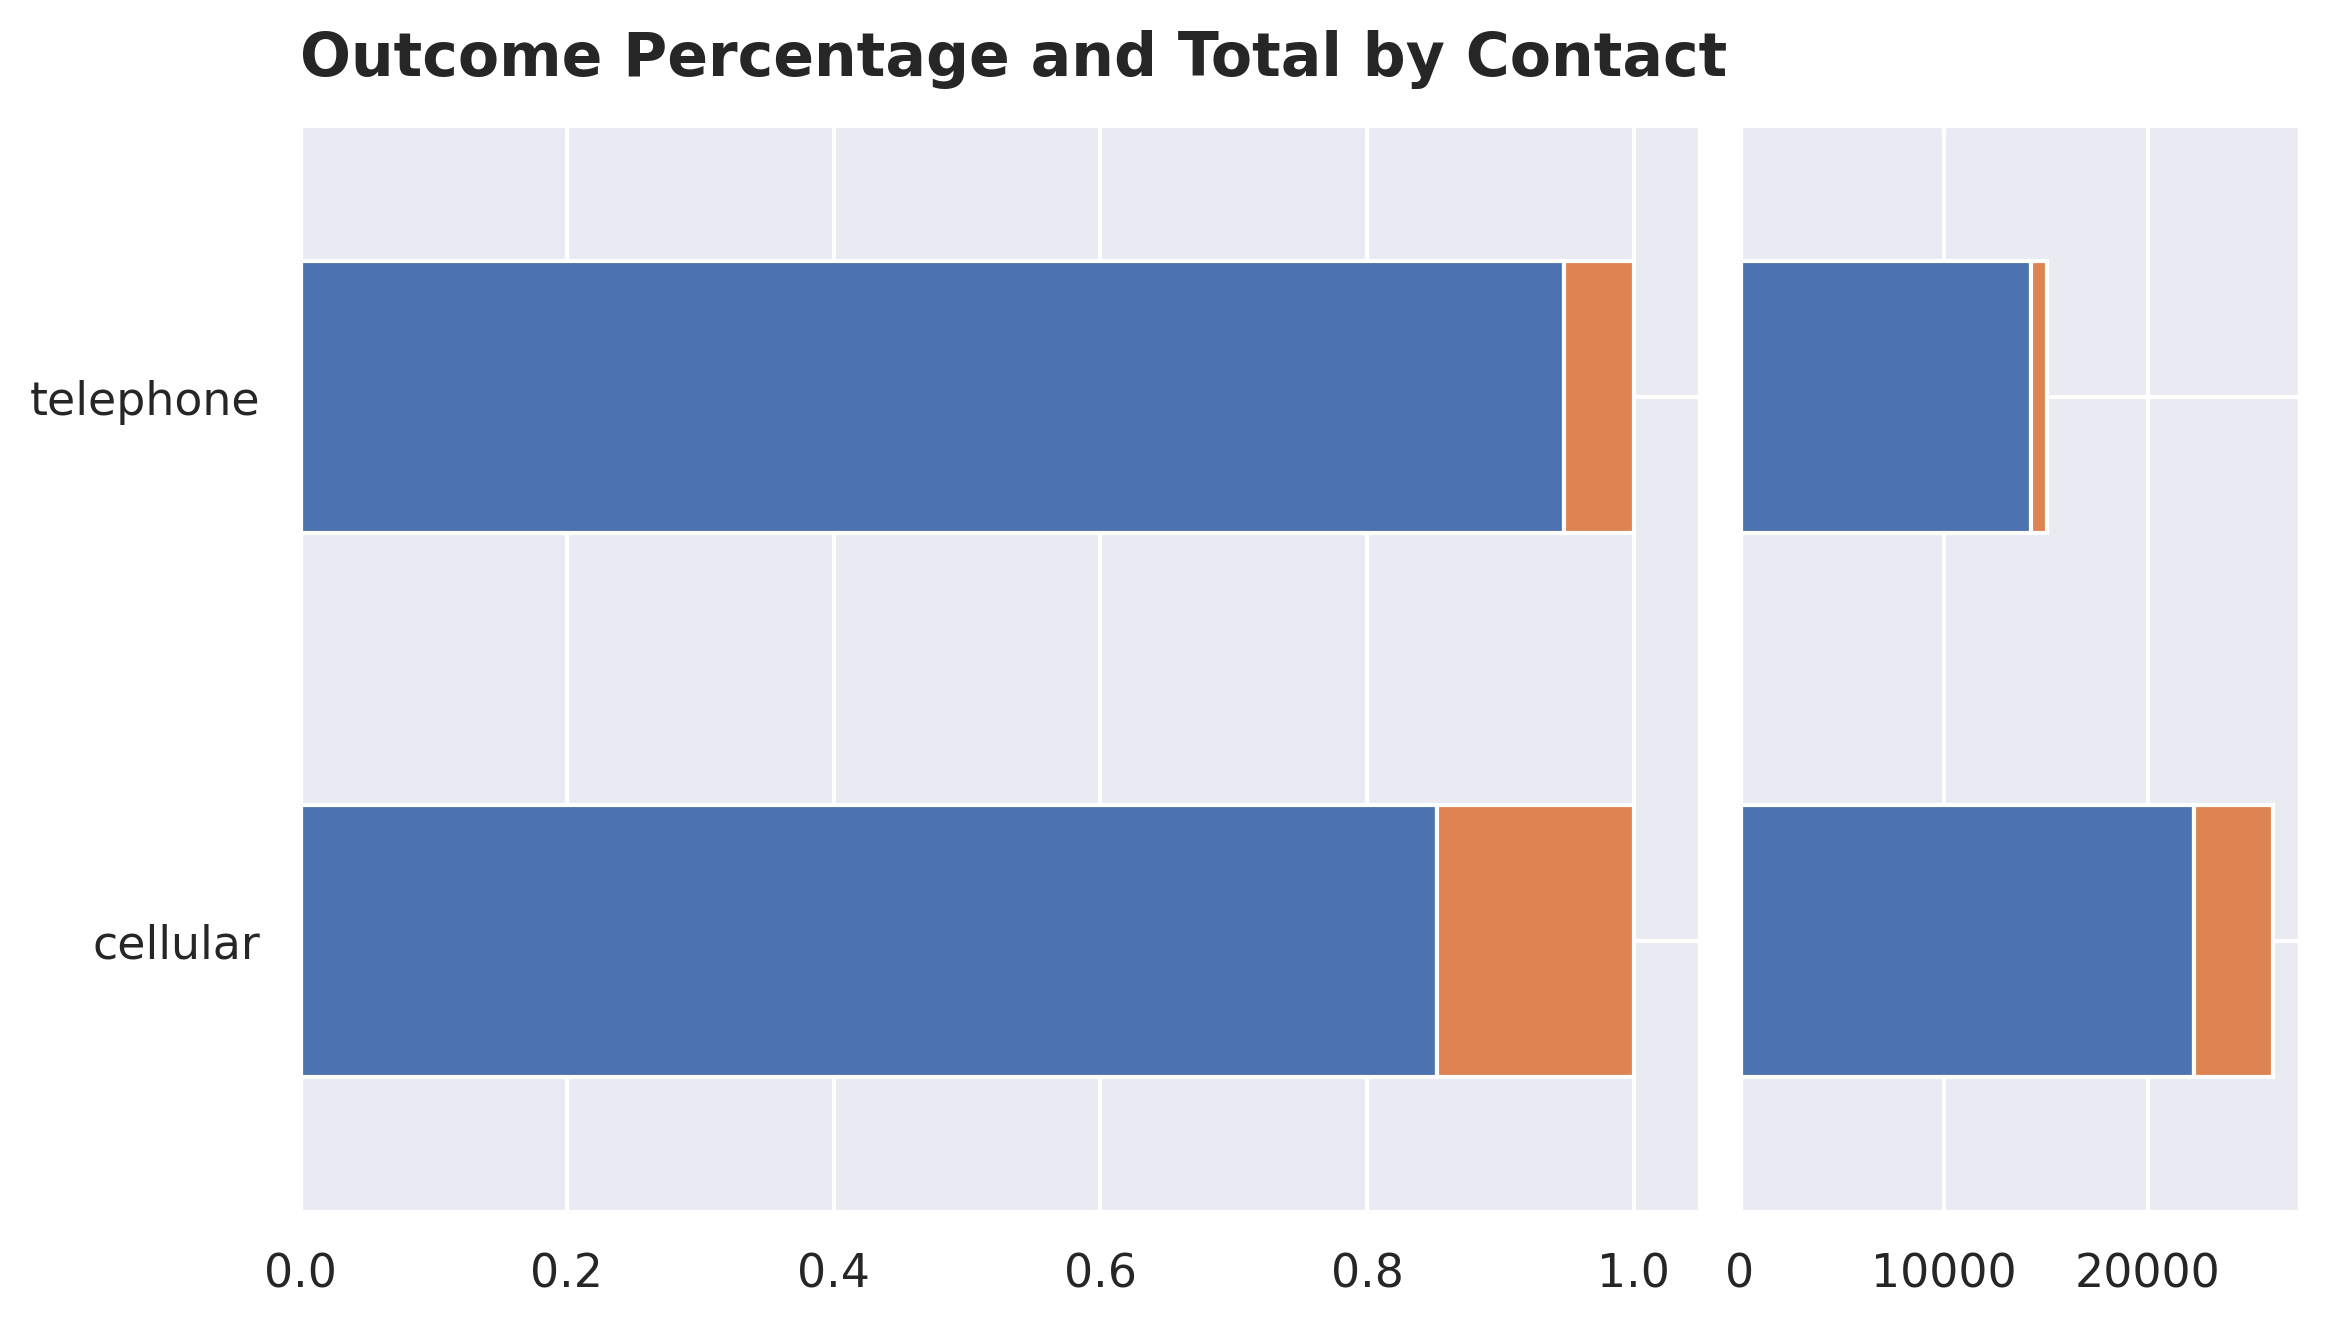

In [ ]:
contact_outcome = cat_outcome(bank_mkt, "contact")

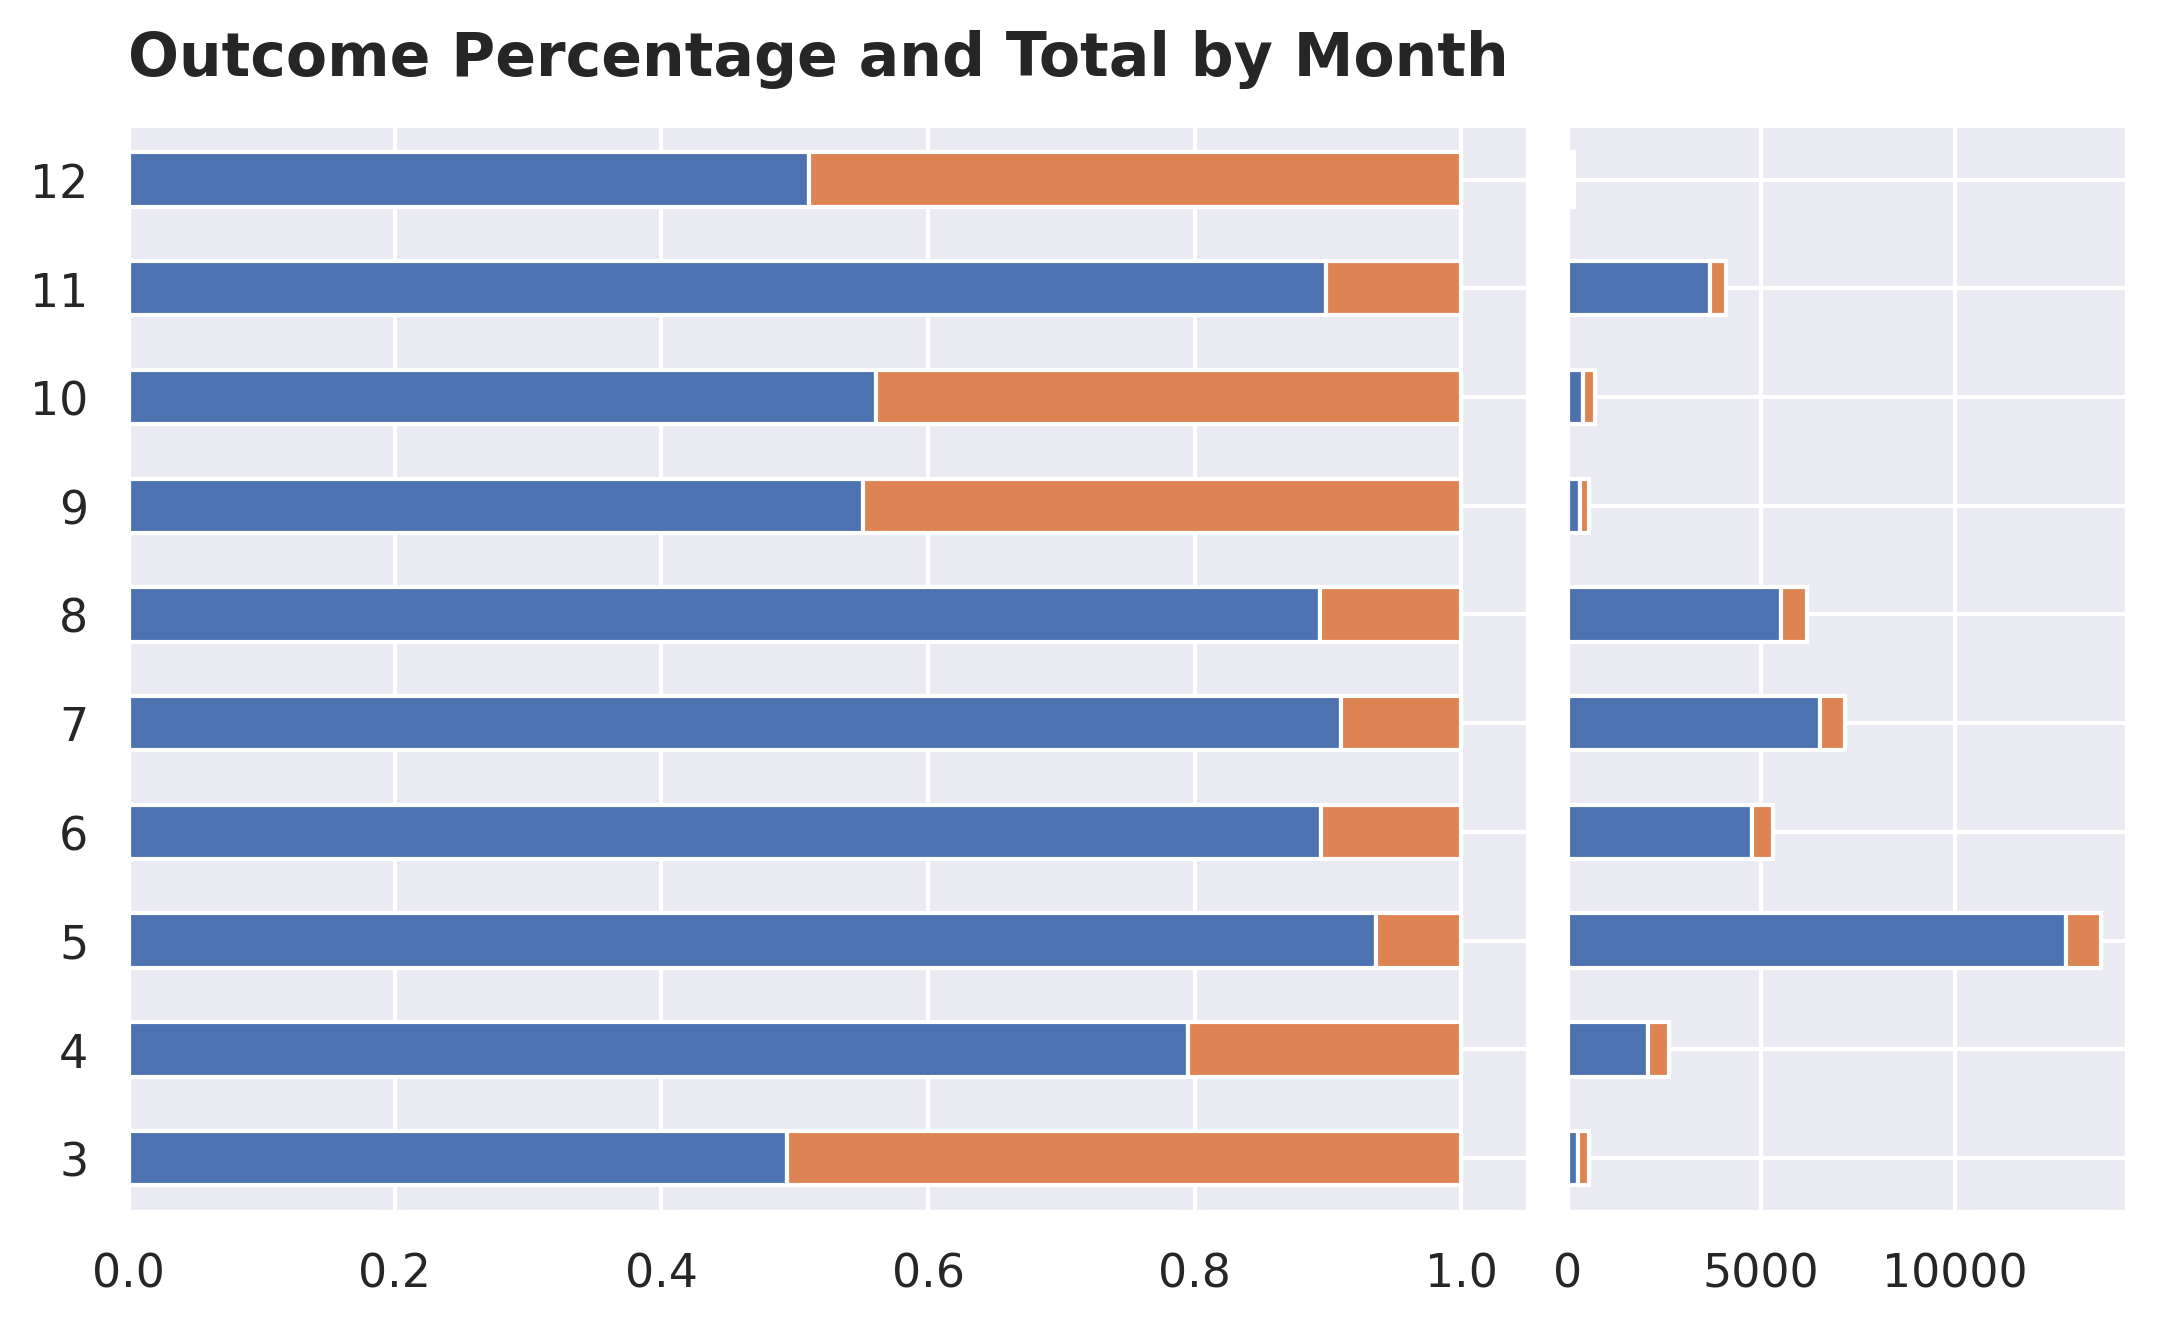

In [ ]:
month_outcome = cat_outcome(bank_mkt, "month")

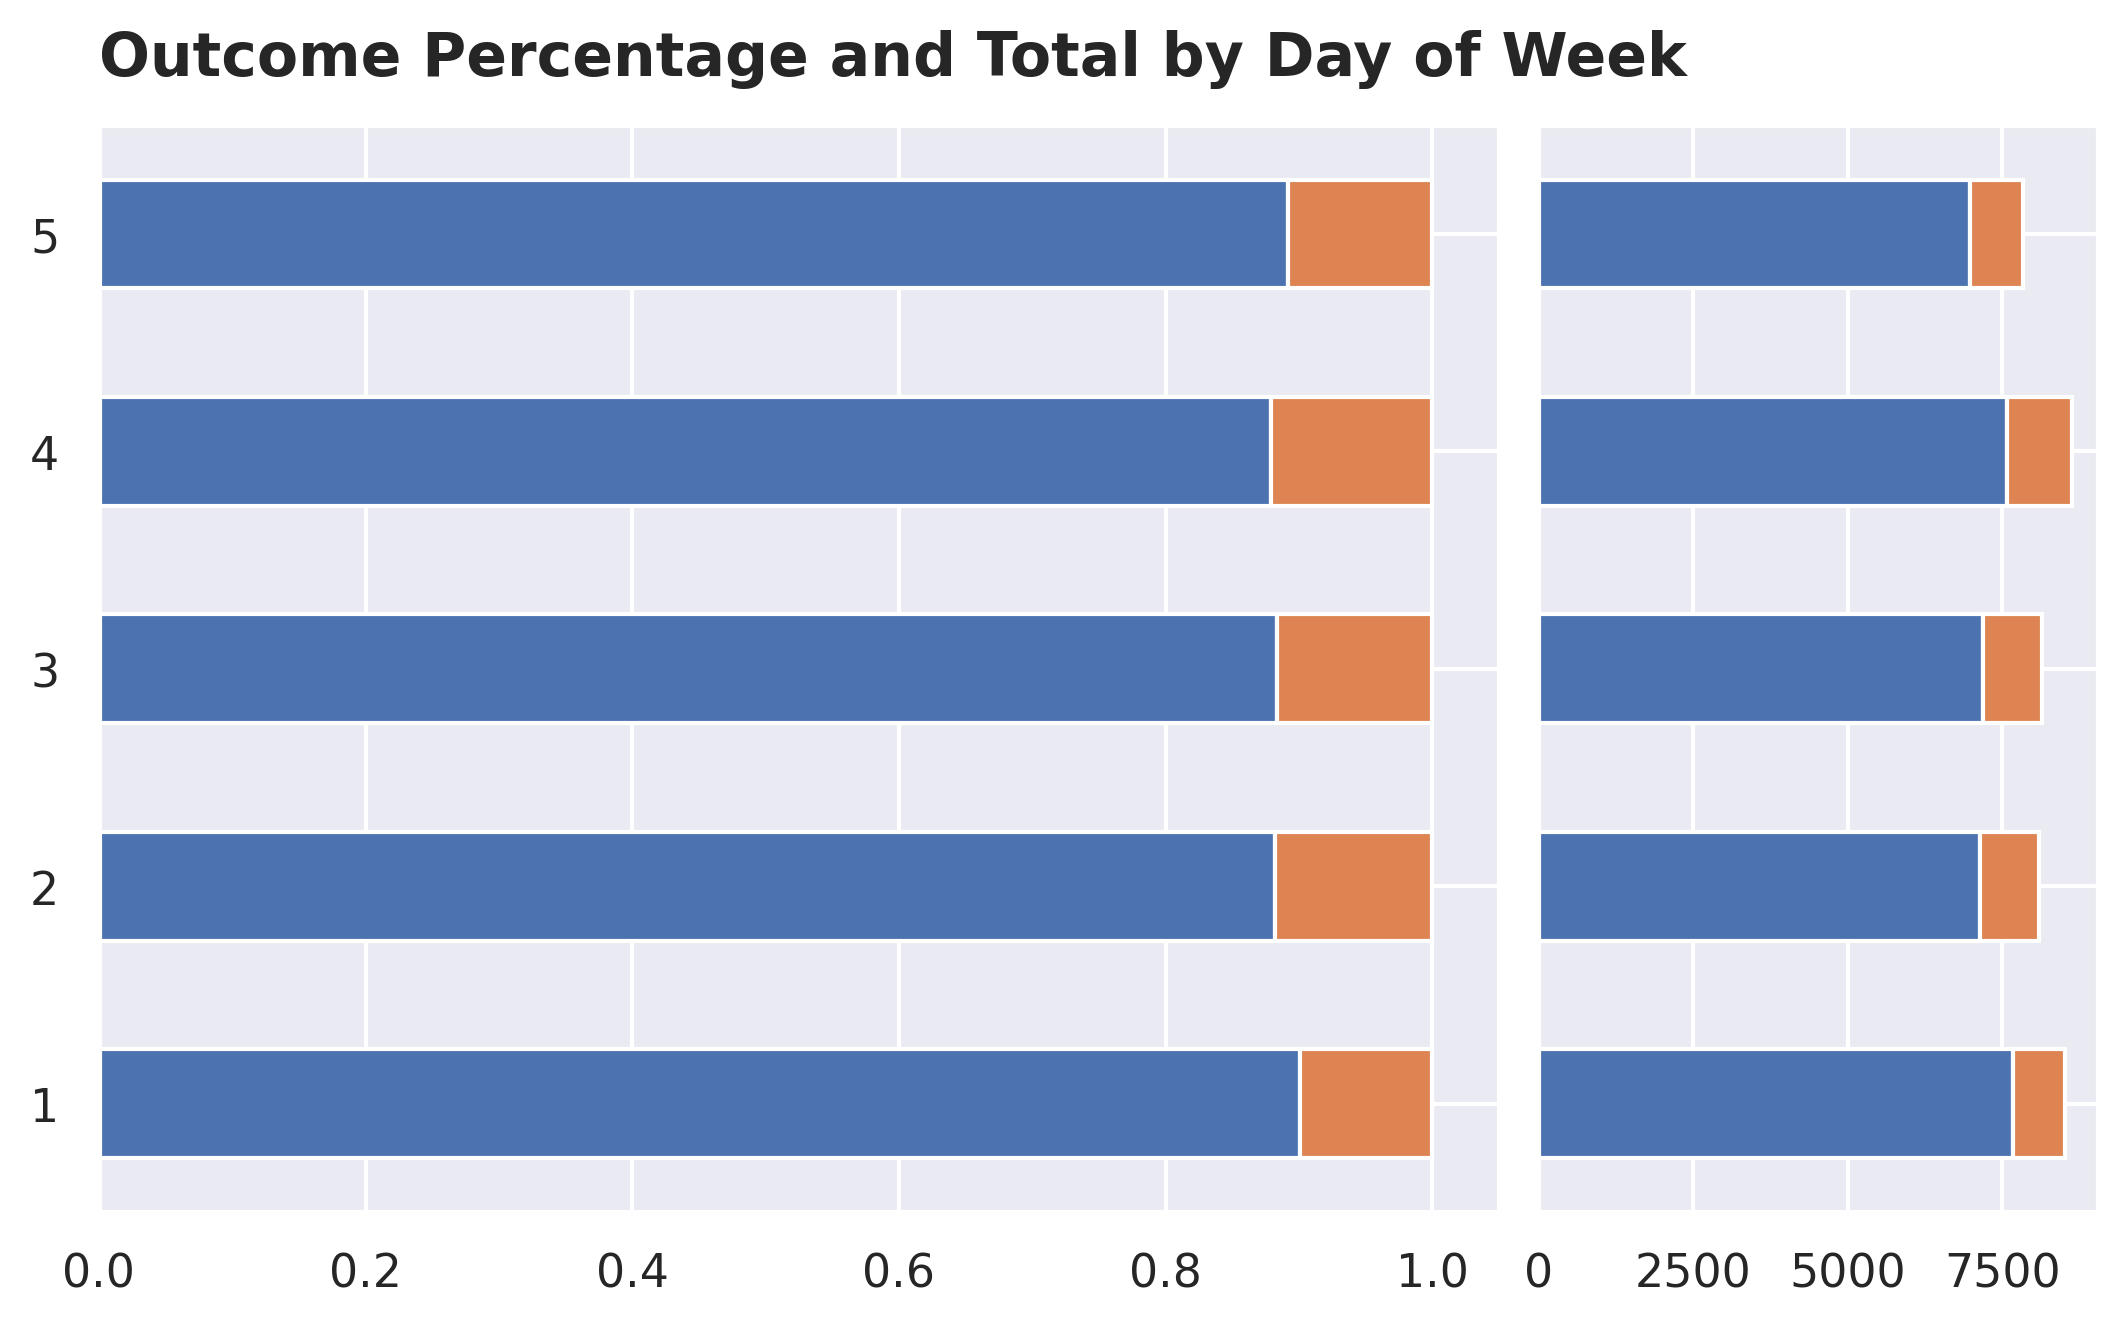

In [ ]:
day_outcome = cat_outcome(bank_mkt, "day_of_week")

### Previous Campaign

We can plot the dirstribution of `pdays` and `previous`. As we can see, most of the client with `pdays` has been contacted 3 to 6 days before and peaked at 3 and 6 days.

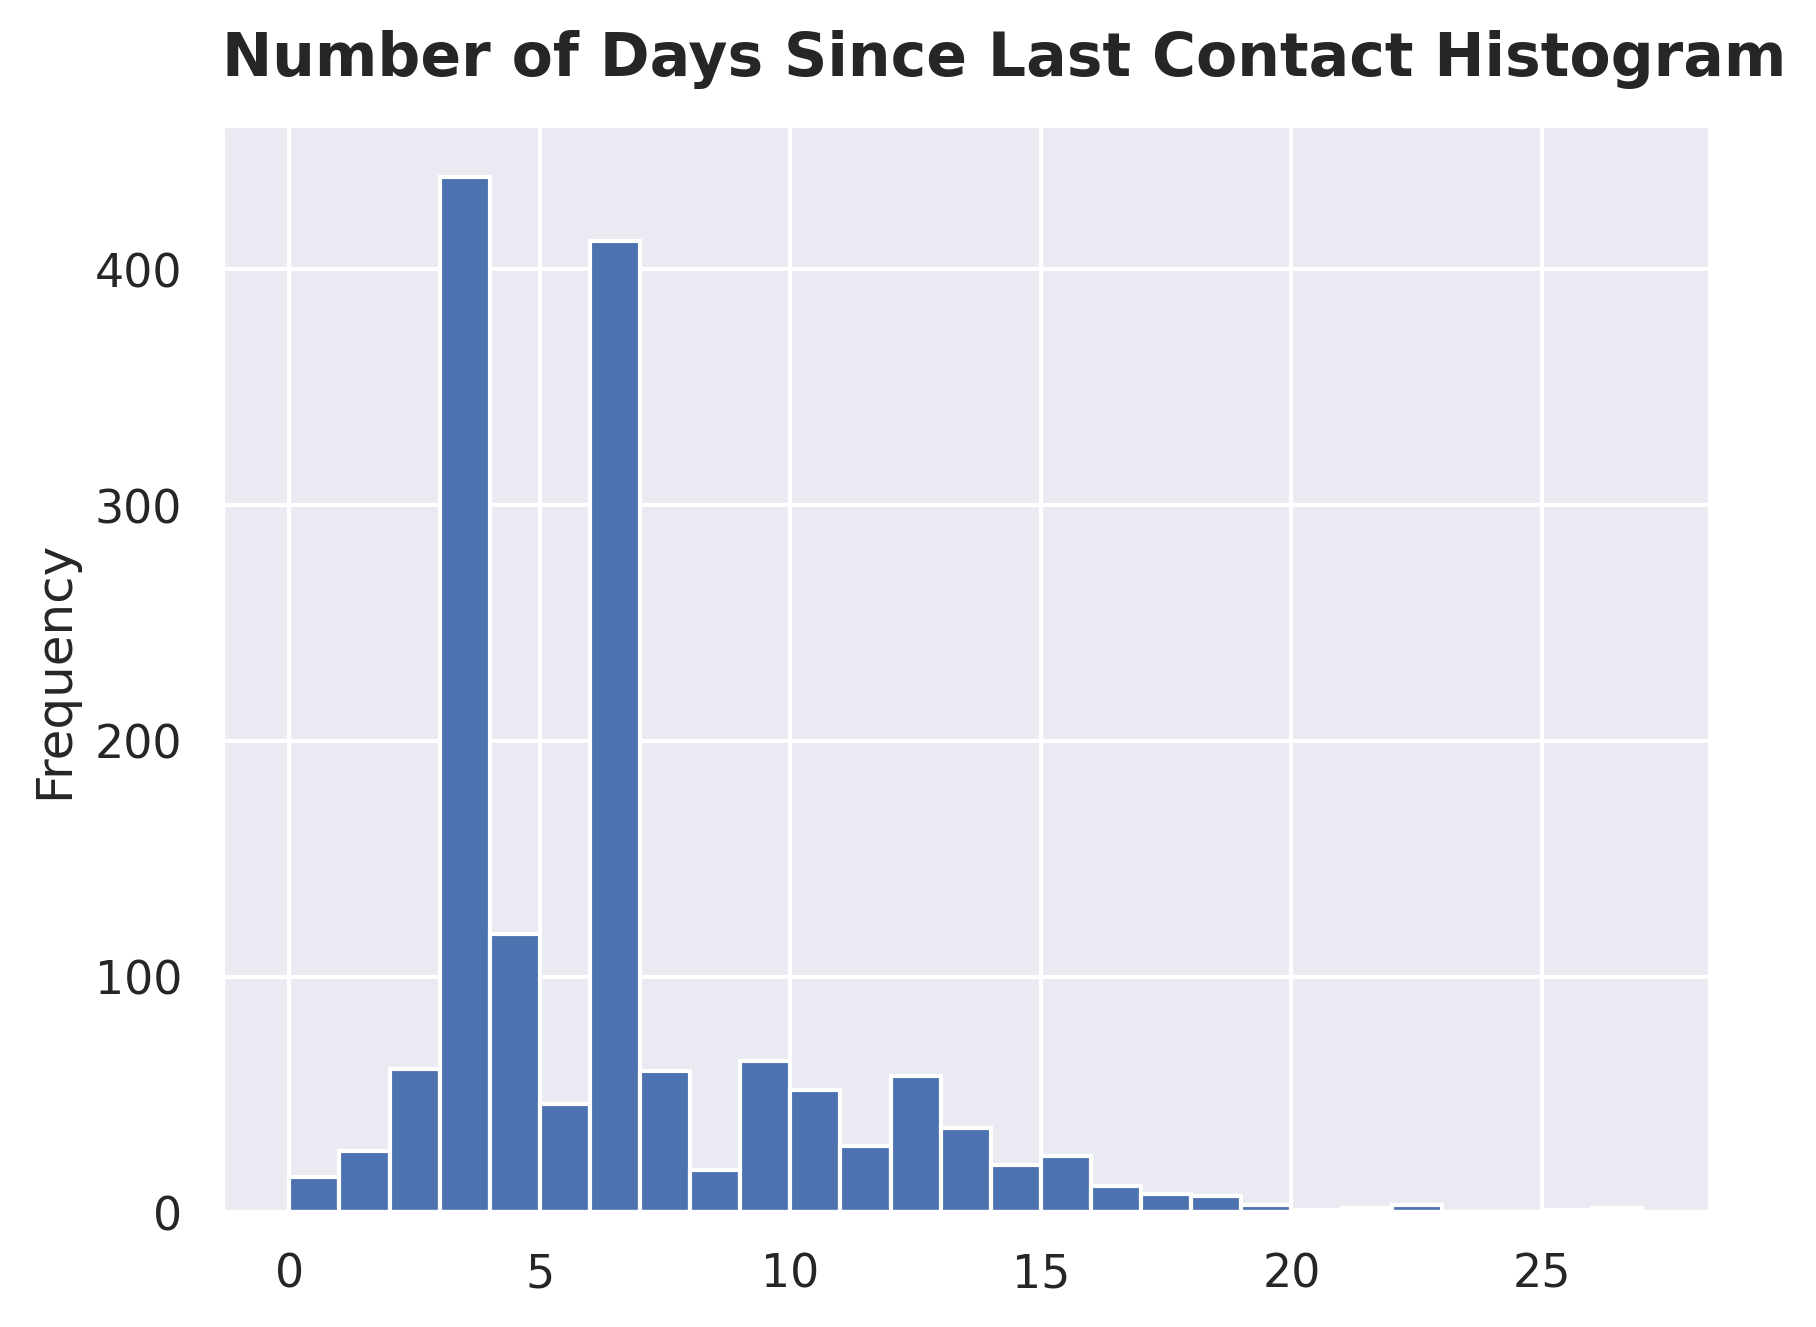

In [ ]:
pdays_hist = bank_mkt["pdays"].plot.hist(bins=27, title="Number of Days Since Last Contact Histogram")

Most of the client has never been contacted before.

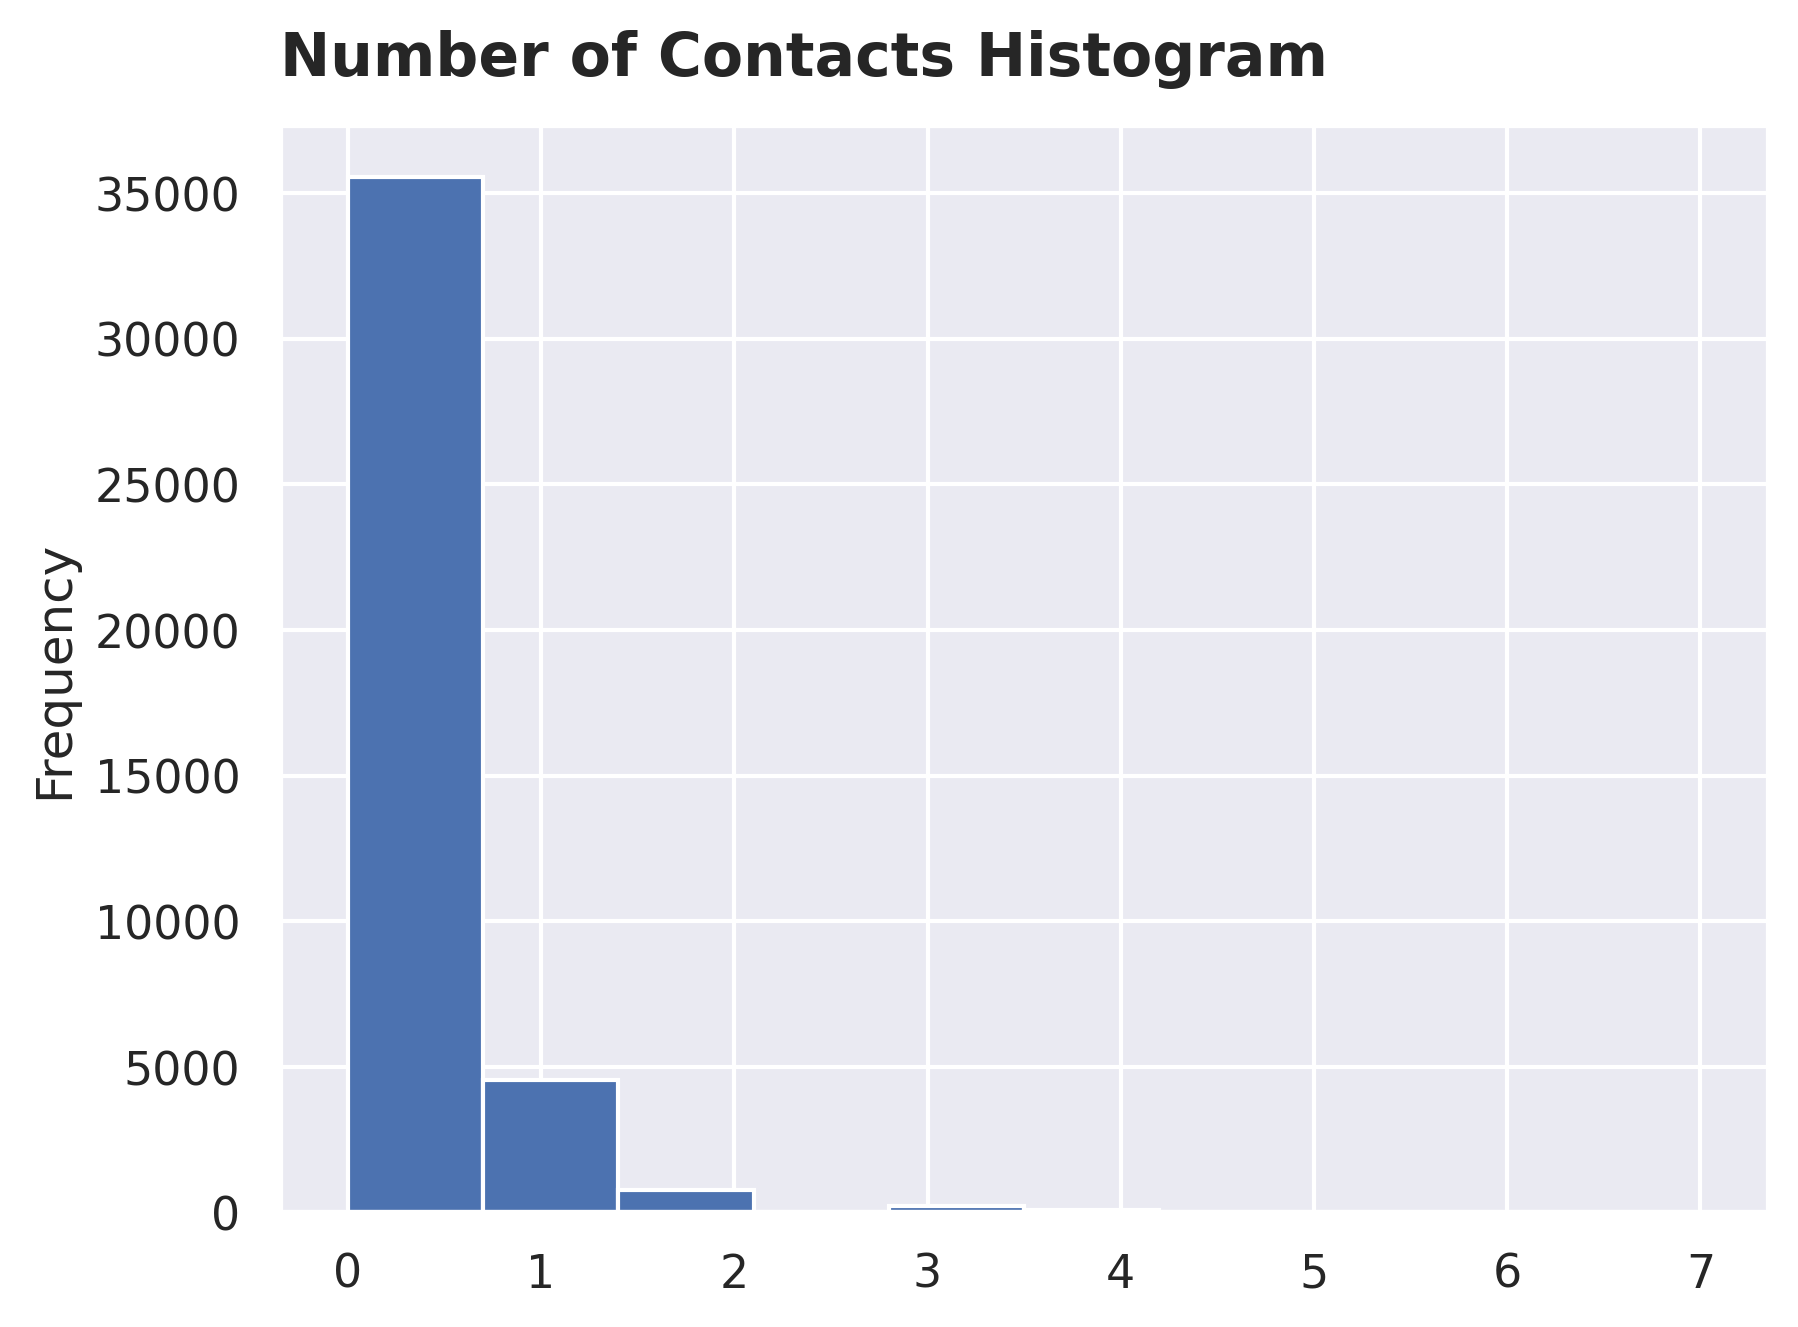

In [ ]:
previous_hist = bank_mkt["previous"].plot.hist(title="Number of Contacts Histogram")

If `pdays` is missing value, that means that the client was not previously contacted and therefore should not have `poutcome`. But `poutcome` column has less missing values than `pdays`. 

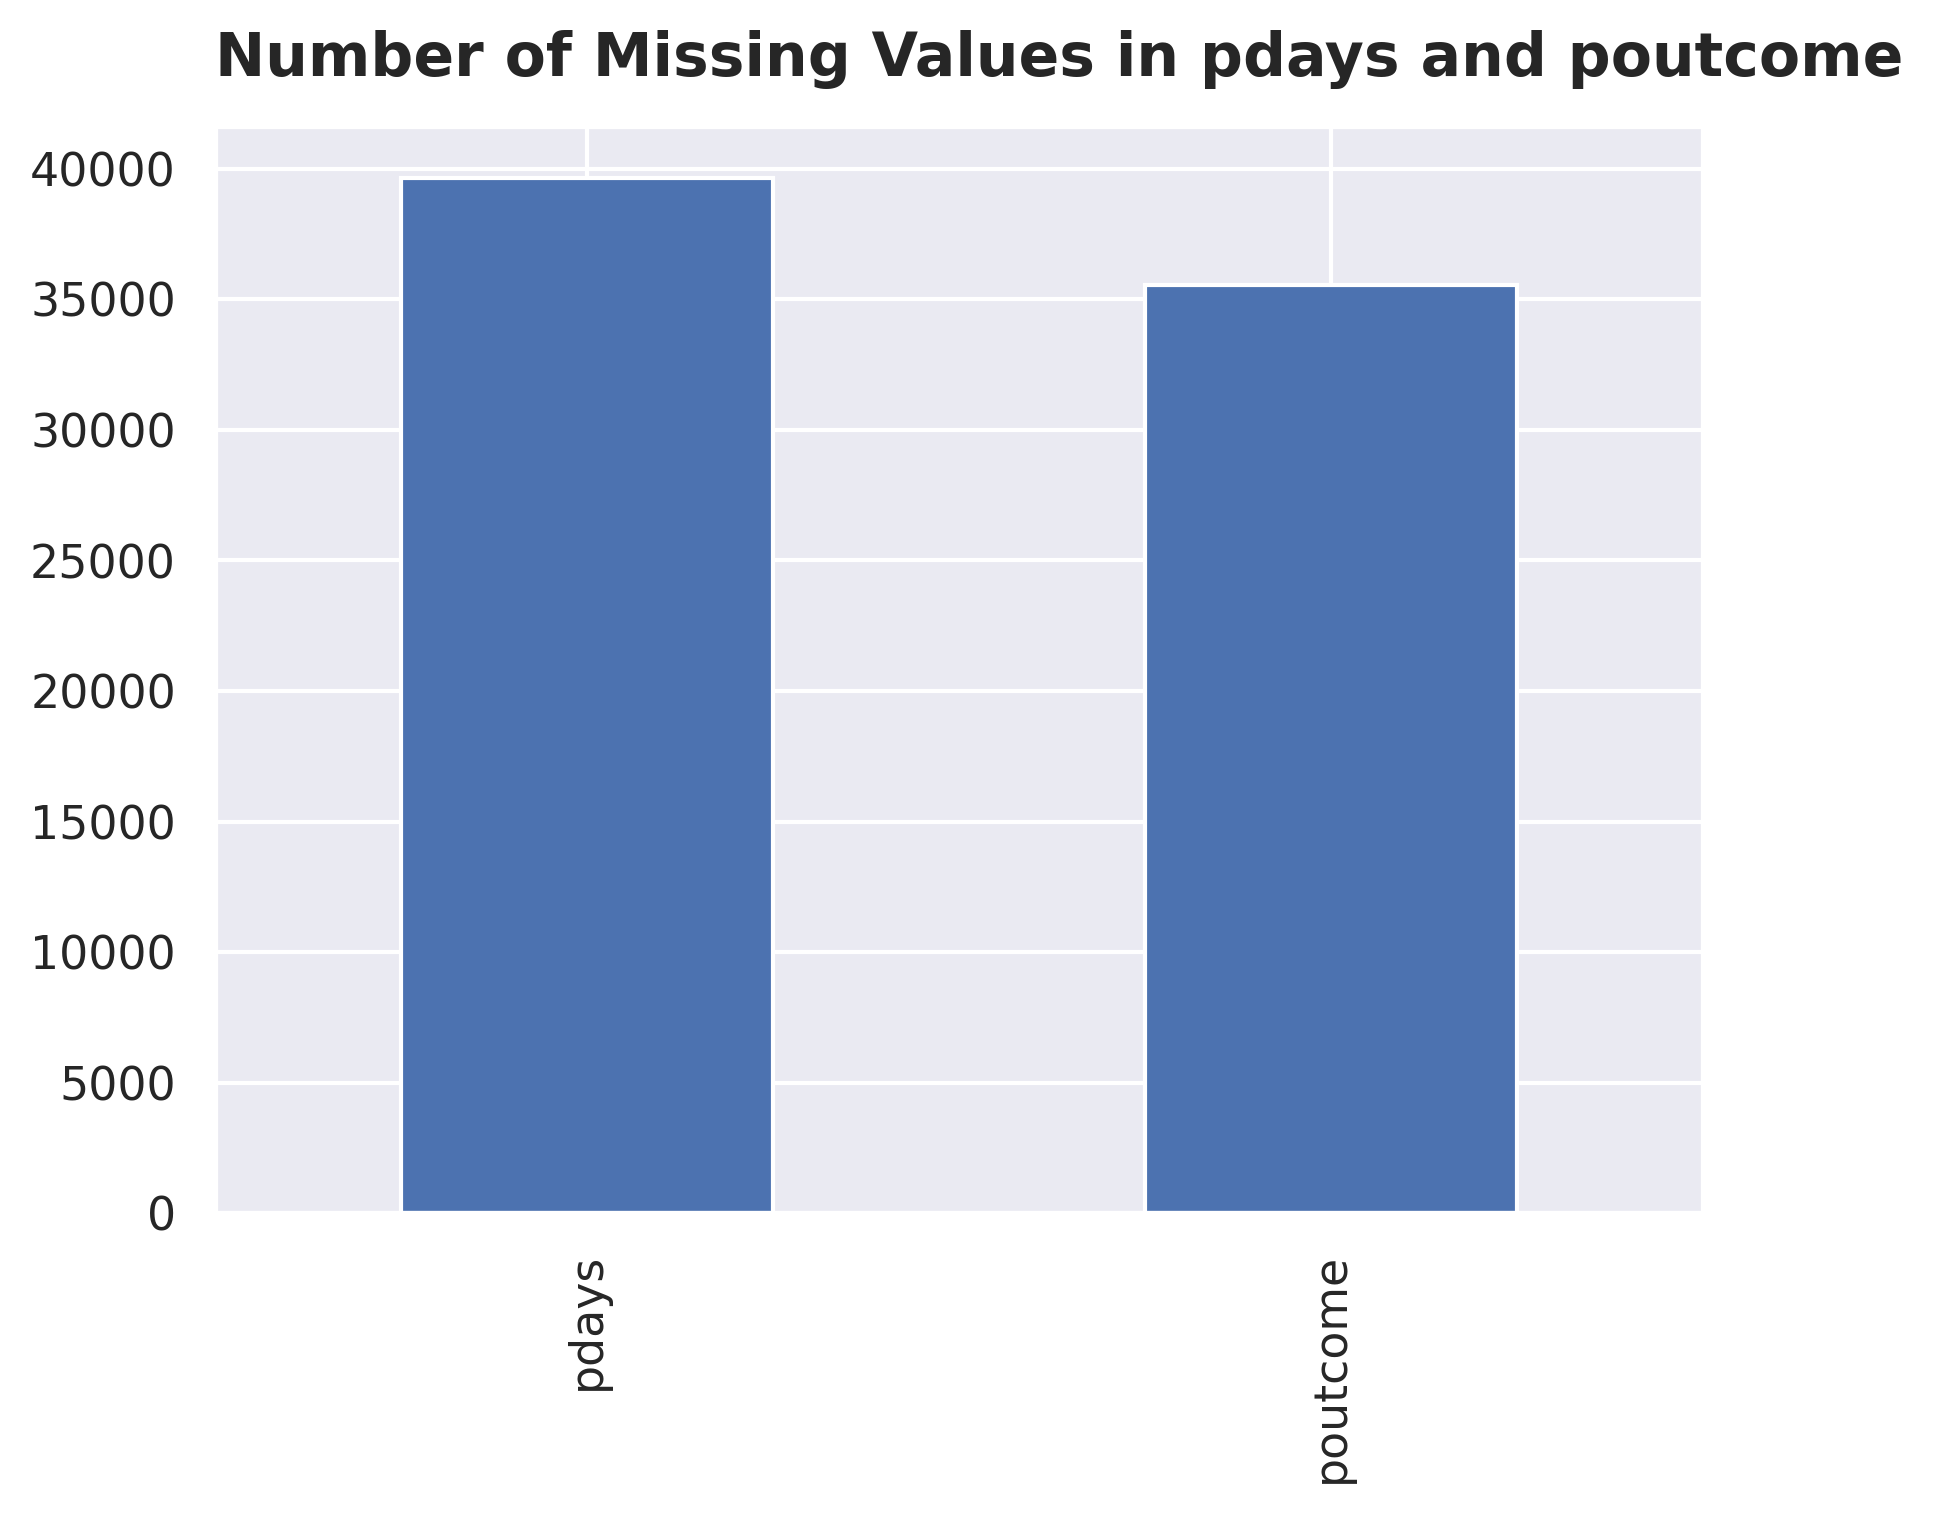

In [ ]:
previous_na = bank_mkt[["pdays", "poutcome"]].isna().sum()
previous_na_ax = previous_na.plot.bar(title="Number of Missing Values in pdays and poutcome")

We can print out the 4110 rows where the client is not contacted but have `poutcome` and see how many times they have been contacted before. The figures suggest that maybe these clients has been actually contacted but it was more than 30 days ago so the contact date was not recorded. This leaves us plenty room for feature engineering.

In [ ]:
previous = bank_mkt[["campaign", "pdays", "previous", "poutcome", "y"]]
previous = previous[previous["pdays"].isna() & previous["poutcome"].notna()].reset_index(drop=True)
previous

campaign  pdays  previous  poutcome      y
0            1   <NA>         1     False  False
1            1   <NA>         1     False   True
2            1   <NA>         1     False  False
3            1   <NA>         1     False   True
4            1   <NA>         1     False  False
...        ...    ...       ...       ...    ...
4105         1   <NA>         1     False   True
4106         2   <NA>         4     False  False
4107         1   <NA>         2     False   True
4108         1   <NA>         2     False  False
4109         3   <NA>         1     False  False

[4110 rows x 5 columns]

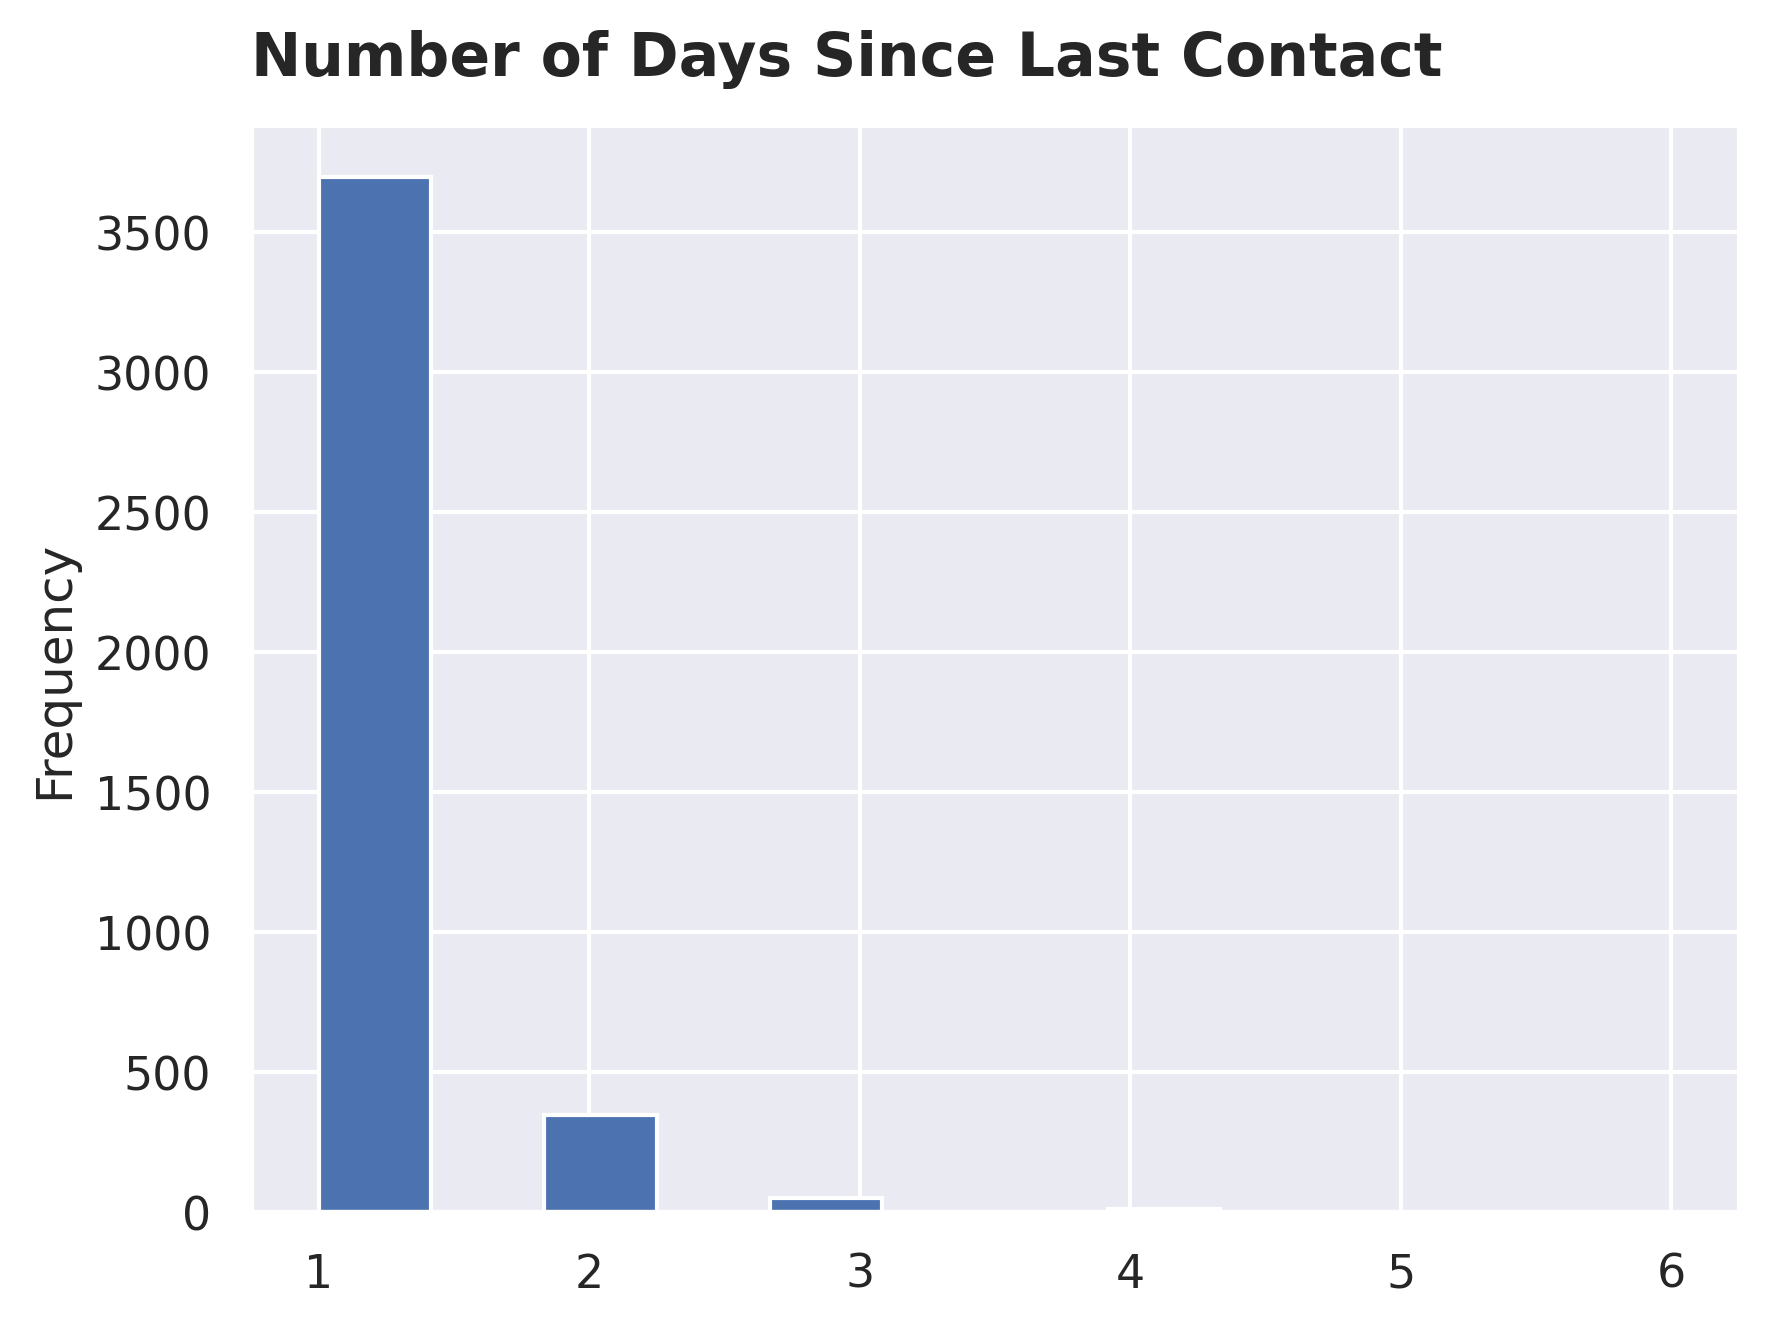

In [ ]:
previous_ax = previous["previous"].plot.hist(bins=12, title="Number of Days Since Last Contact")

In [ ]:
bank_mkt[bank_mkt["pdays"].isna() & bank_mkt["poutcome"].isna()]

age          job  marital            education  default  housing  \
0       56    housemaid  married             basic.4y    False    False   
1       57     services  married          high.school     <NA>    False   
2       37     services  married          high.school    False     True   
3       40       admin.  married             basic.6y    False    False   
4       56     services  married          high.school    False    False   
...    ...          ...      ...                  ...      ...      ...   
41169   37       admin.  married    university.degree    False     True   
41171   73      retired  married  professional.course    False     True   
41172   46  blue-collar  married  professional.course    False    False   
41173   56      retired  married    university.degree    False     True   
41174   44   technician  married  professional.course    False    False   

        loan    contact  month  day_of_week  duration  campaign  pdays  \
0      False  telephone      5            1       261         1   <NA>   
1      False  telephone      5            1       149         1   <NA>   
2      False  telephone      5            1       226         1   <NA>   
3      False  telephone      5            1       151         1   <NA>   
4       True  telephone      5            1       307         1   <NA>   
...      ...        ...    ...          ...       ...       ...    ...   
41169  False   cellular     11            5       281         1   <NA>   
41171  False   cellular     11            5       334         1   <NA>   
41172  False   cellular     11            5       383         1   <NA>   
41173  False   cellular     11            5       189         2   <NA>   
41174  False   cellular     11            5       442         1   <NA>   

       previous  poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  \
0             0      <NA>           1.1          93.994          -36.4   
1             0      <NA>           1.1          93.994          -36.4   
2             0      <NA>           1.1          93.994          -36.4   
3             0      <NA>           1.1          93.994          -36.4   
4             0      <NA>           1.1          93.994          -36.4   
...         ...       ...           ...             ...            ...   
41169         0      <NA>          -1.1          94.767          -50.8   
41171         0      <NA>          -1.1          94.767          -50.8   
41172         0      <NA>          -1.1          94.767          -50.8   
41173         0      <NA>          -1.1          94.767          -50.8   
41174         0      <NA>          -1.1          94.767          -50.8   

       euribor3m  nr.employed      y  
0          4.857       5191.0  False  
1          4.857       5191.0  False  
2          4.857       5191.0  False  
3          4.857       5191.0  False  
4          4.857       5191.0  False  
...          ...          ...    ...  
41169      1.028       4963.6   True  
41171      1.028       4963.6   True  
41172      1.028       4963.6  False  
41173      1.028       4963.6  False  
41174      1.028       4963.6   True  

[35551 rows x 21 columns]

### Correlation Heatmap

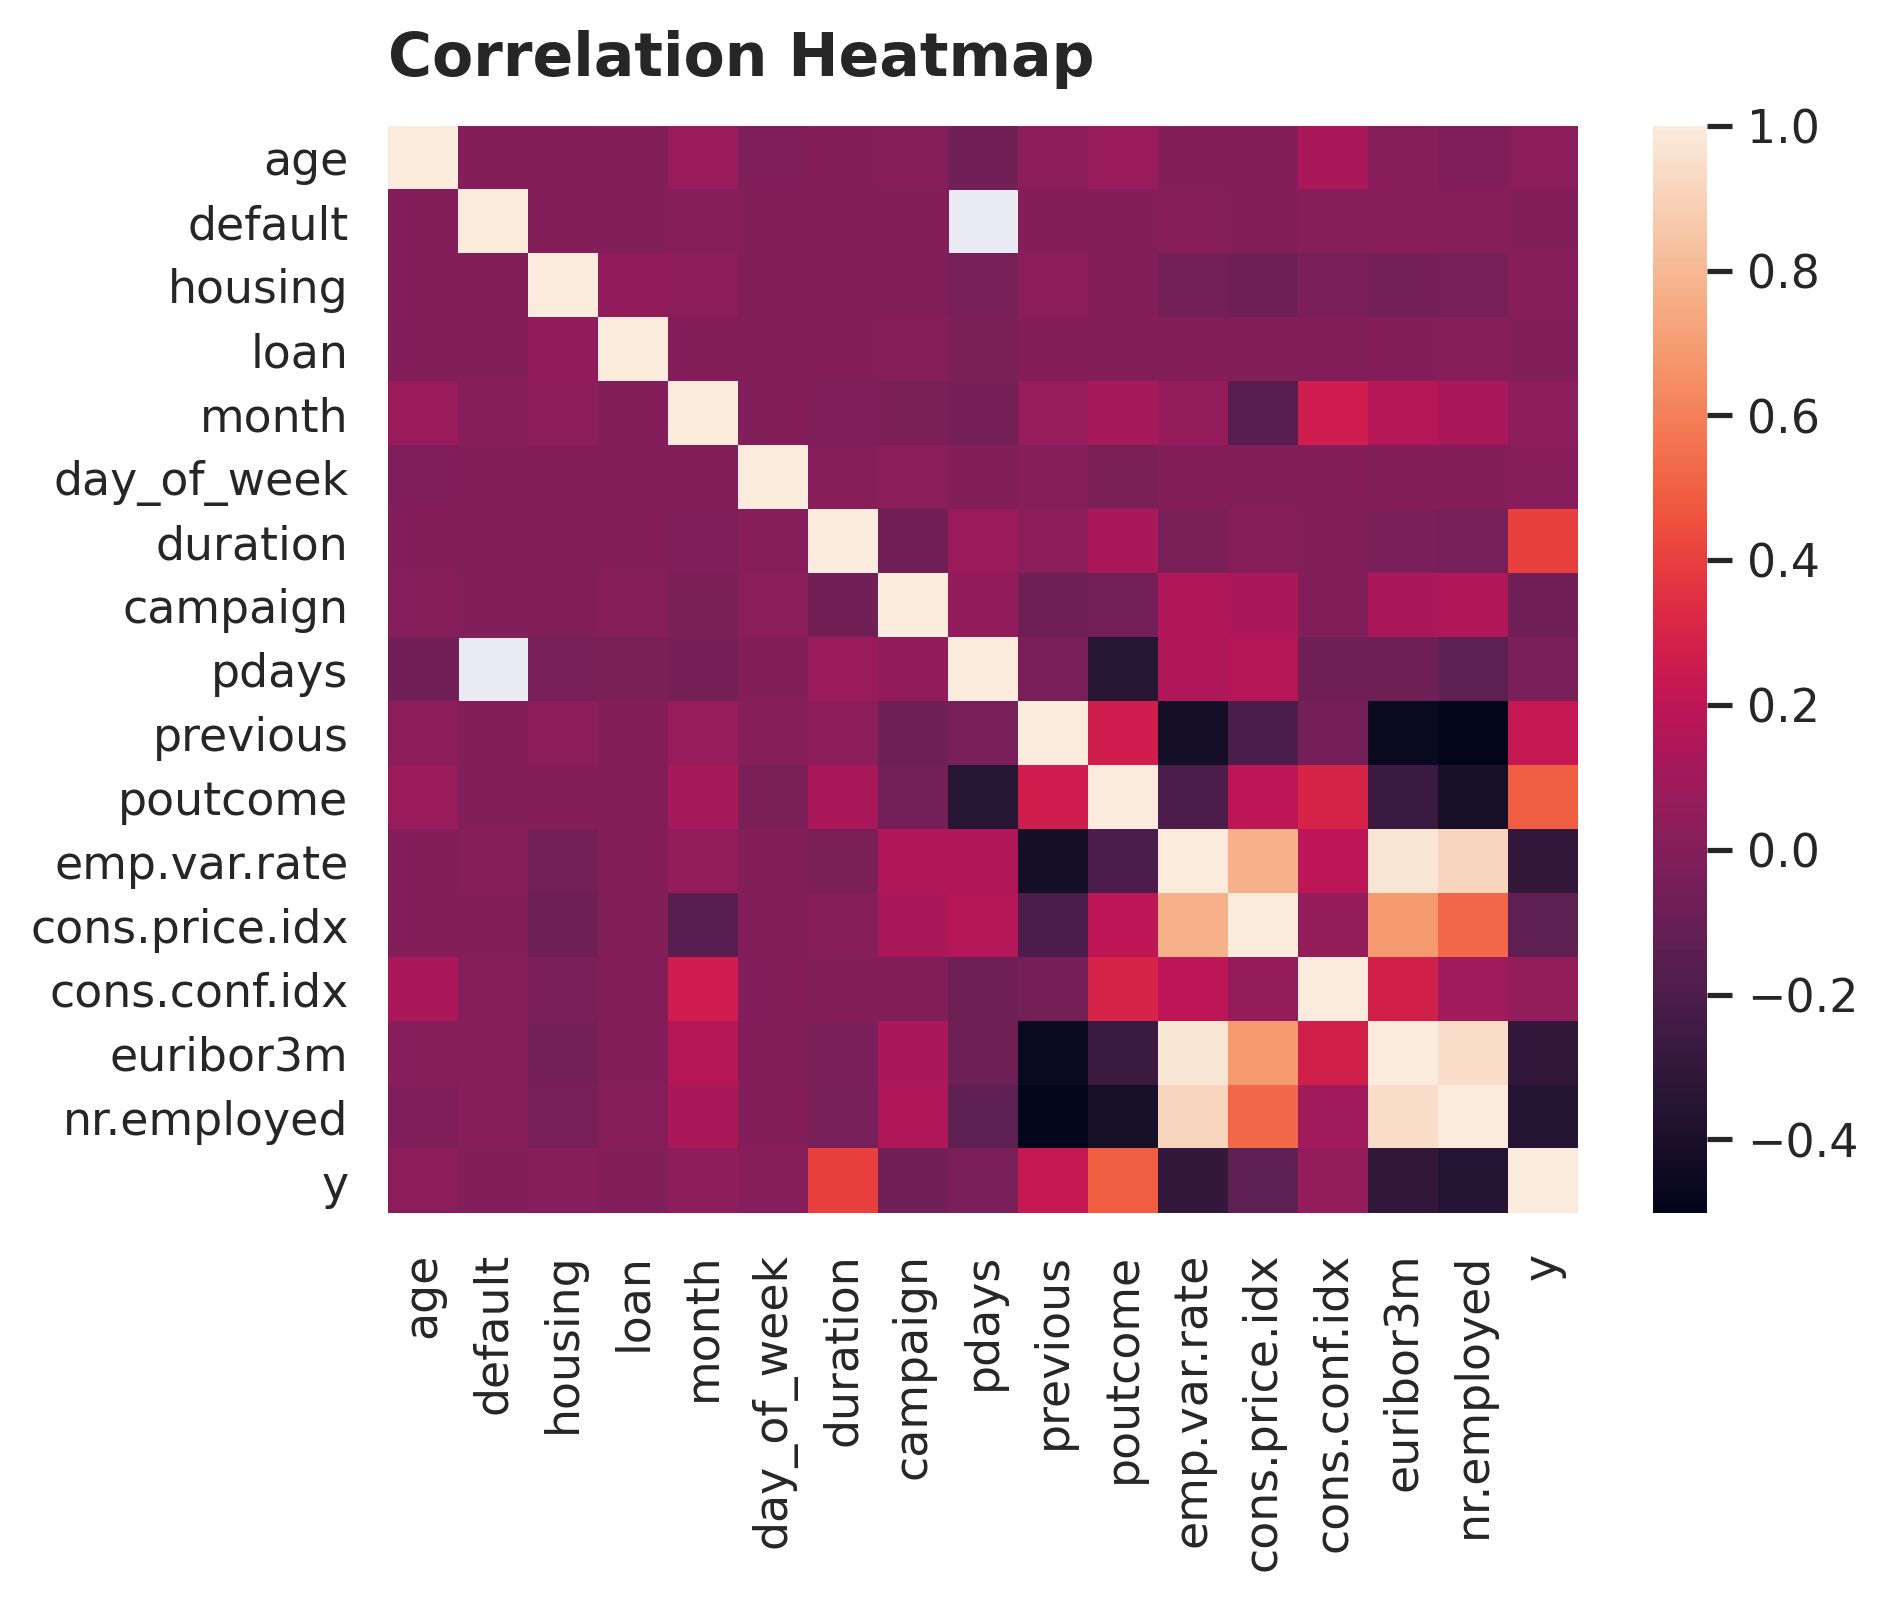

In [ ]:
corr_heatmap = sns.heatmap(data=bank_mkt.corr(method="pearson")).set_title("Correlation Heatmap")

# Evaluation

2 min, by Jiawei Li

In [ ]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [ ]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt,
                                                              FunctionTransformer(cat_encode))

In [ ]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

In [ ]:
y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

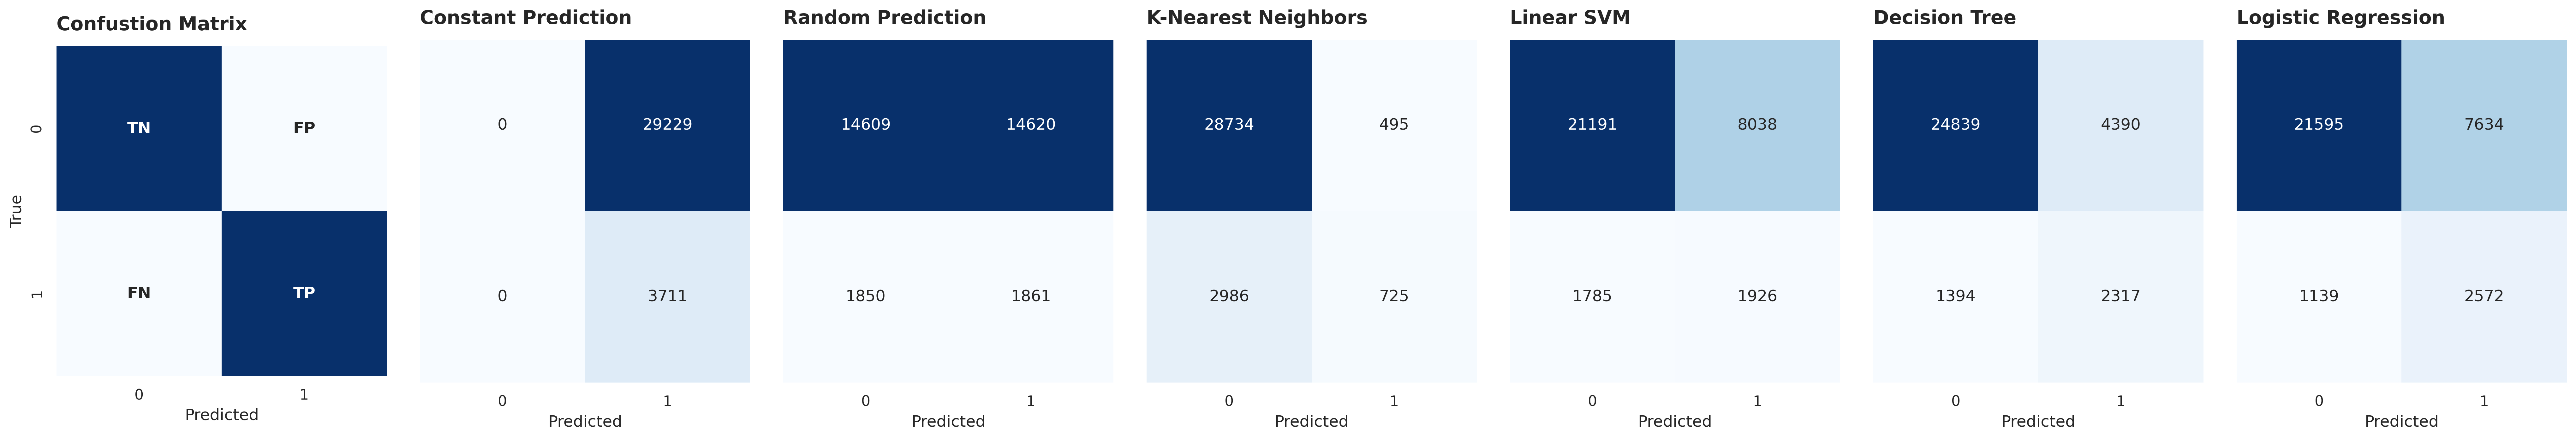

In [ ]:
f, axs = plt.subplots(1, n+1, figsize=(4.8*(n+1)+0.1*n, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1))

conf_mat = np.array([[100, 30], [30, 100]])
conf_label = np.array([["TN", "FP"], ["FN", "TP"]])
conf_ax = sns.heatmap(conf_mat,
                      ax=axs[0],
                      annot=conf_label,
                      annot_kws={"fontweight": "bold"},
                      fmt="",
                      square=True,
                      cmap=plt.cm.Blues, 
                      cbar=False)
conf_ax.set_xlabel("Predicted")
conf_ax.set_ylabel("True")
conf_ax.set_title("Confustion Matrix")

for i, name in zip(range(1, n+1), names):
    conf_mat = confusion_matrix(y_train, y_pred[name])
    conf_ax = sns.heatmap(conf_mat, 
                          ax=axs[i], 
                          annot=True, 
                          fmt="", 
                          cmap=plt.cm.Blues, 
                          cbar=False)
    conf_ax.set(xlabel="Predicted", title=name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics. The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

The true negative rate (TNR) measures the accuracy rate for the negative outcomes:

$$
TNR = \frac{TP}{N} = \frac{TN}{TN+FP} = 1 - FPR
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes:

$$
TPR = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

Balanced accuracy is the average of true positive rate and true negative rate:

$$
bACC = \frac{TPR+TNR}{2}
$$

True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

In [ ]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "REC", "PRE", "F1"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.500188             0.016935    0.275001   
TNR              0.000000           0.499812             0.983065    0.724999   
TPR              1.000000           0.501482             0.195365    0.518998   
bACC             0.500000           0.500647             0.589215    0.621998   
REC              1.000000           0.501482             0.195365    0.518998   
PRE              0.112659           0.112918             0.594262    0.193296   
F1               0.202505           0.184330             0.294058    0.281682   

      Decision Tree  Logistic Regression  
FPR        0.150193             0.261179  
TNR        0.849807             0.738821  
TPR        0.624360             0.693075  
bACC       0.737083             0.715948  
REC        0.624360             0.693075  
PRE        0.345460             0.252009  
F1         0.444807             0.369620

## Receiver Operating Characteristic

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings.

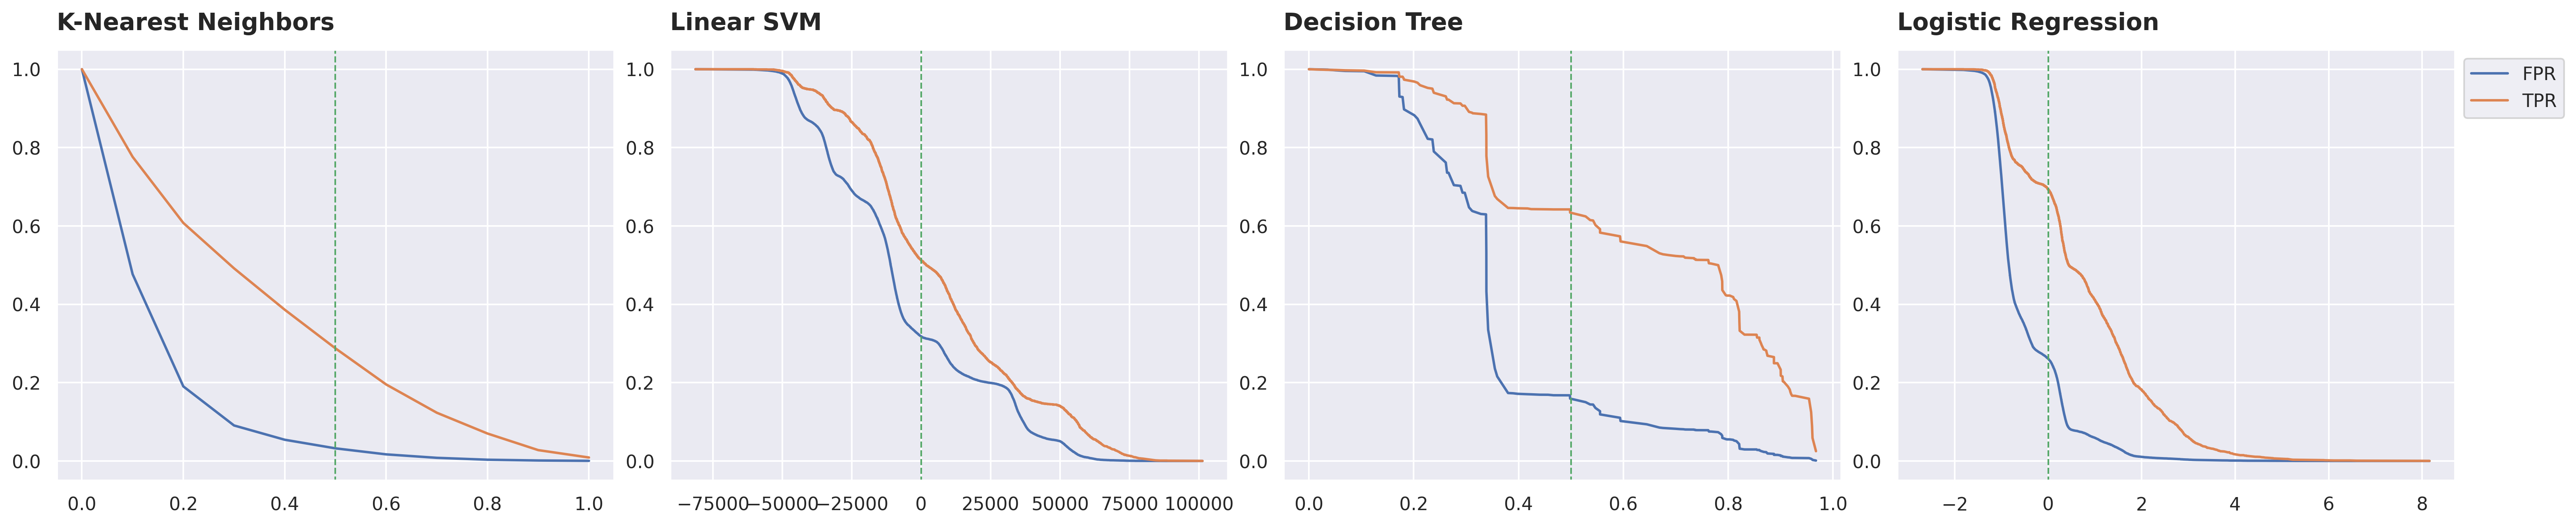

In [ ]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    fprs, tprs, thresholds = roc_curve(y_train, y_score[name])
    roc_df = pd.DataFrame({"FPR": fprs[1:], "TPR": tprs[1:]}, index=thresholds[1:])
    ax = roc_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
#     tnrs = 1 - fprs
#     ax.plot(thresholds[1:], tnrs[1:], color="k", label="TNR")
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

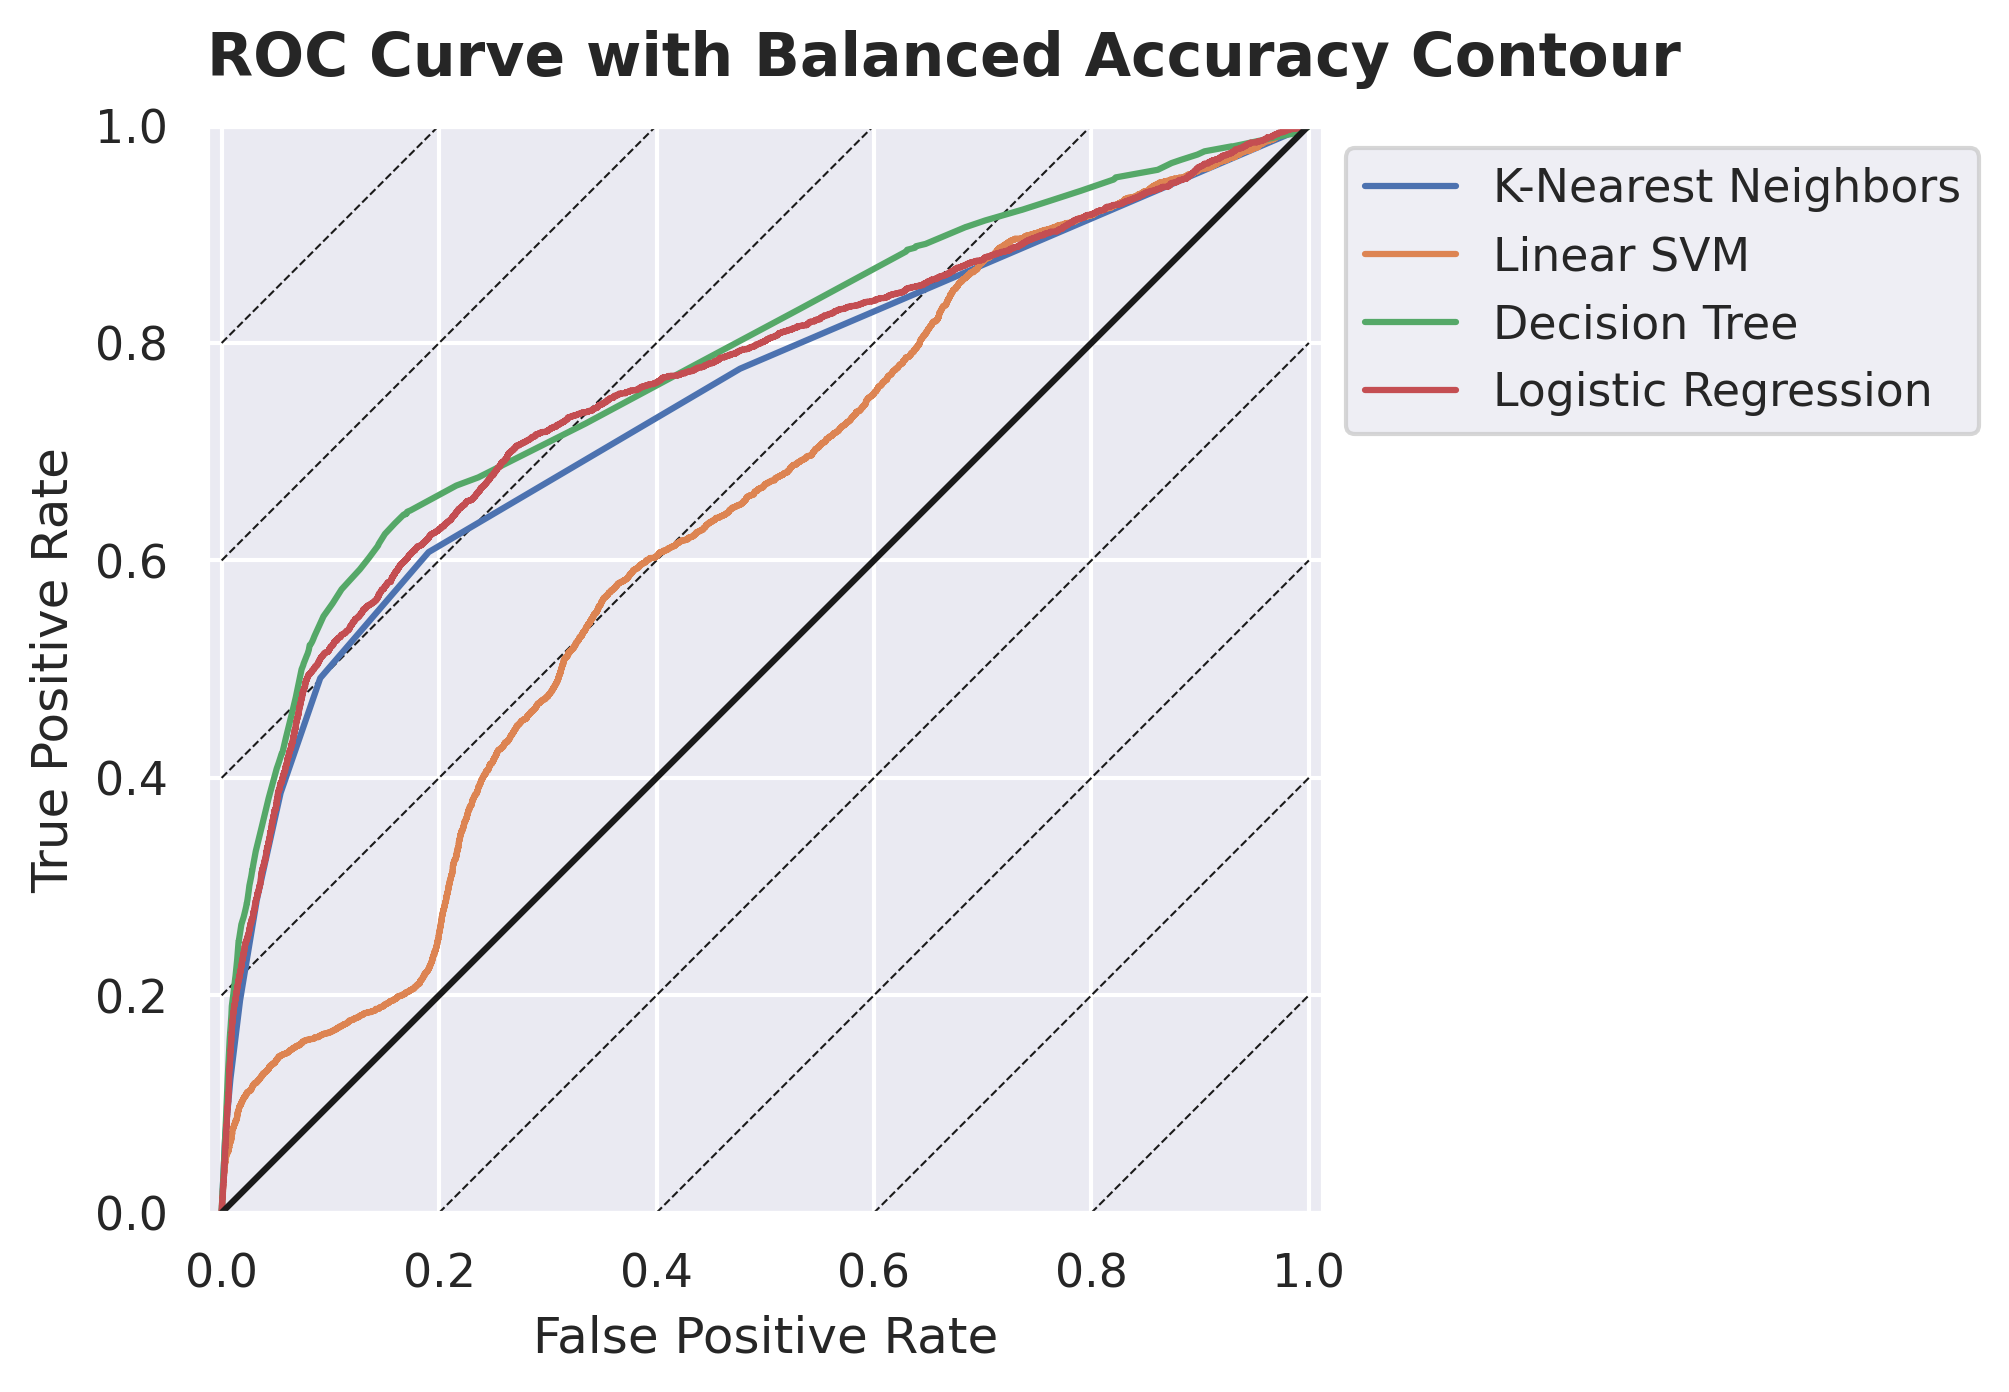

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

## Precision-Recall Curve

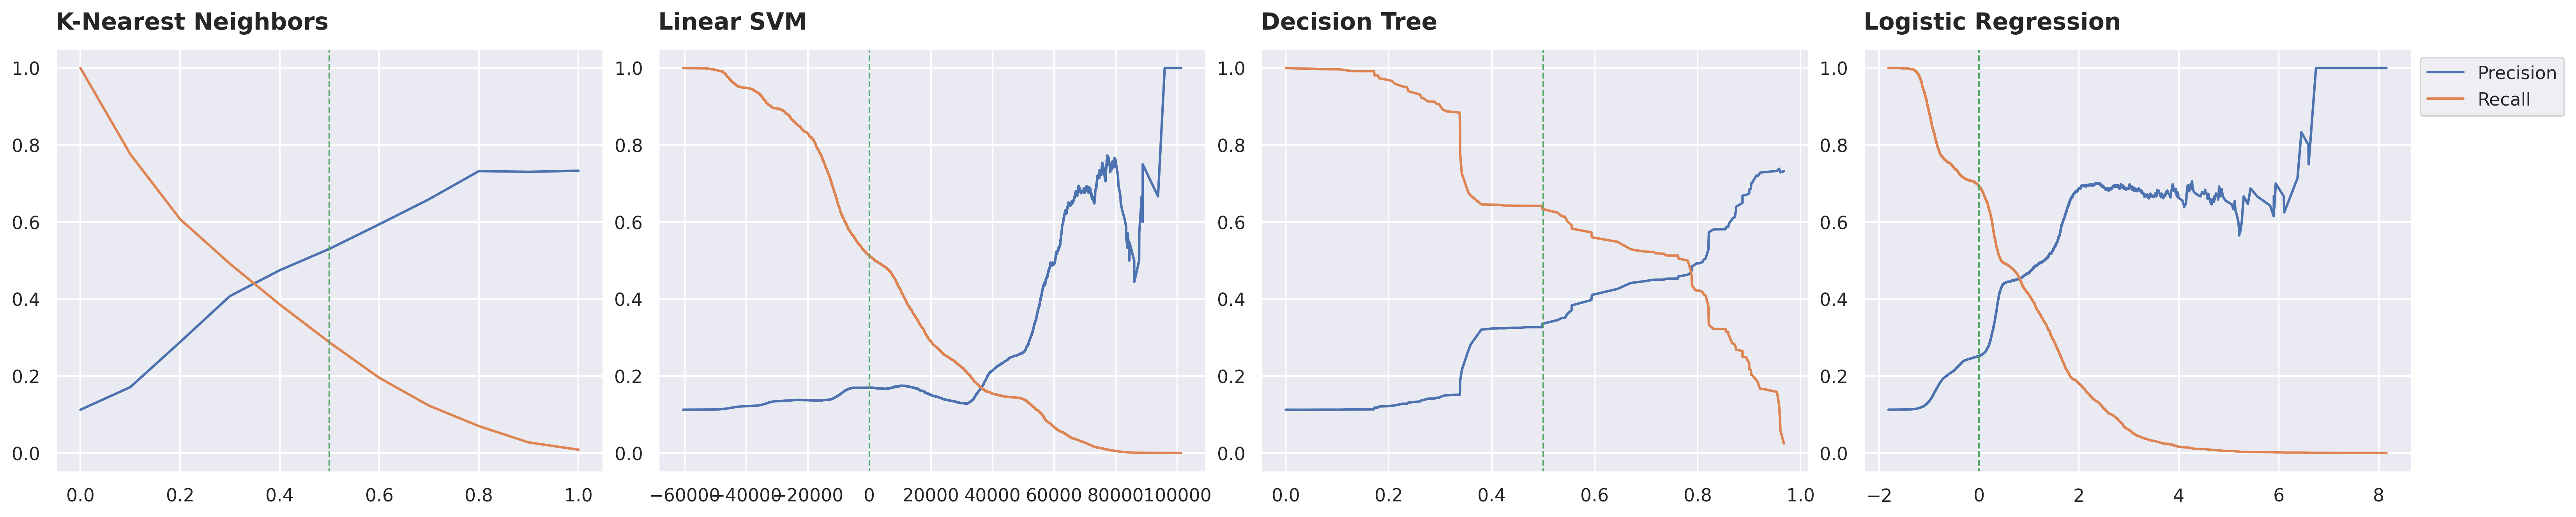

In [ ]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precision_recall_df = pd.DataFrame({"Precision": precisions[:-1], "Recall": recalls[:-1]}, index=thresholds)
    ax = precision_recall_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

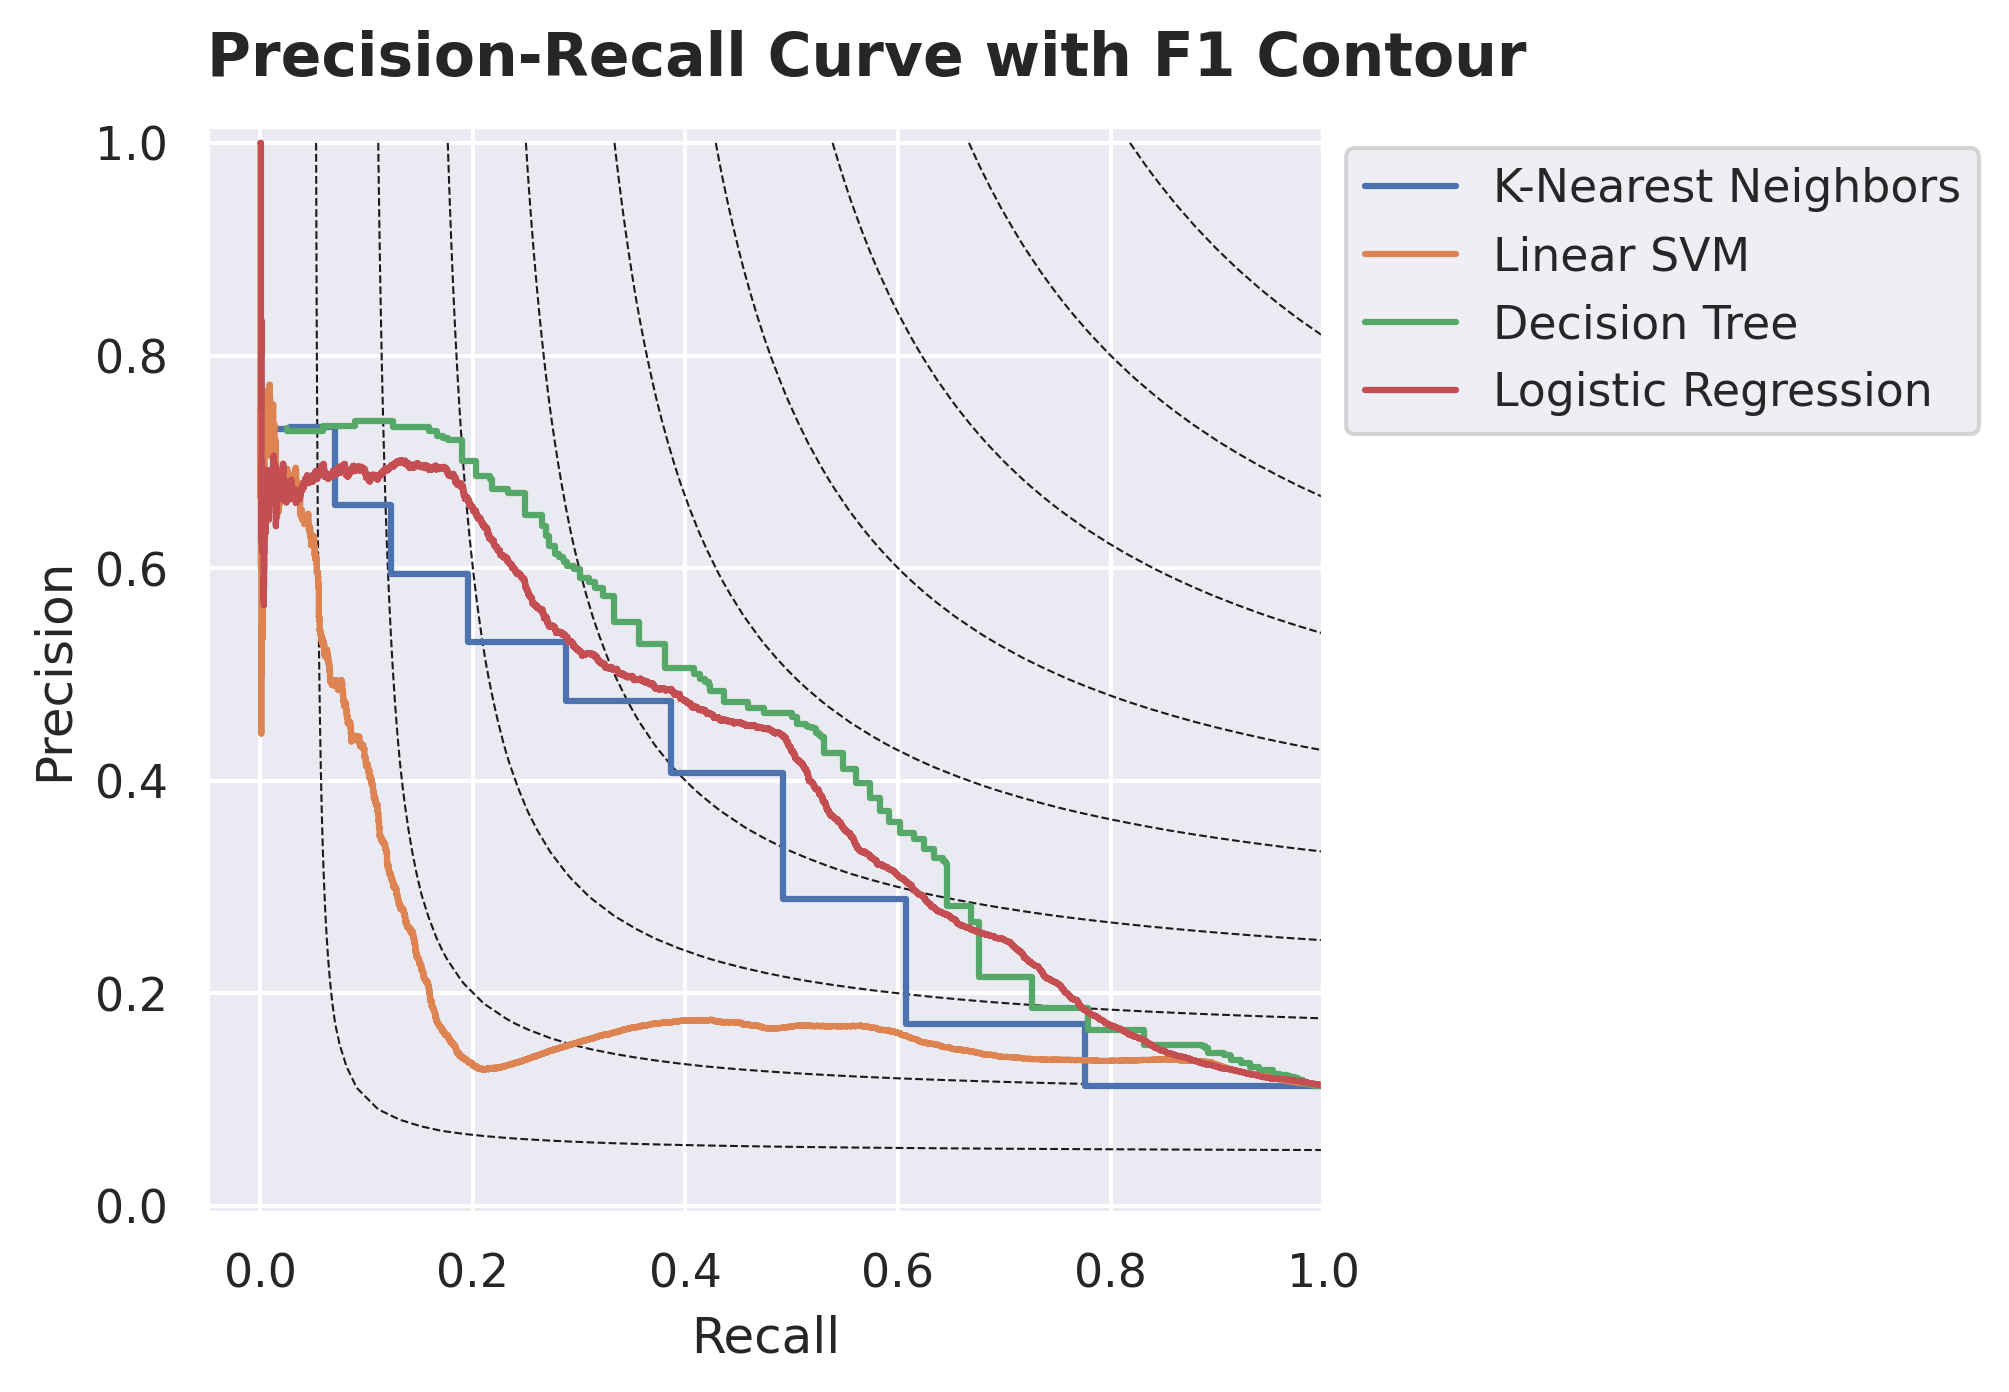

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

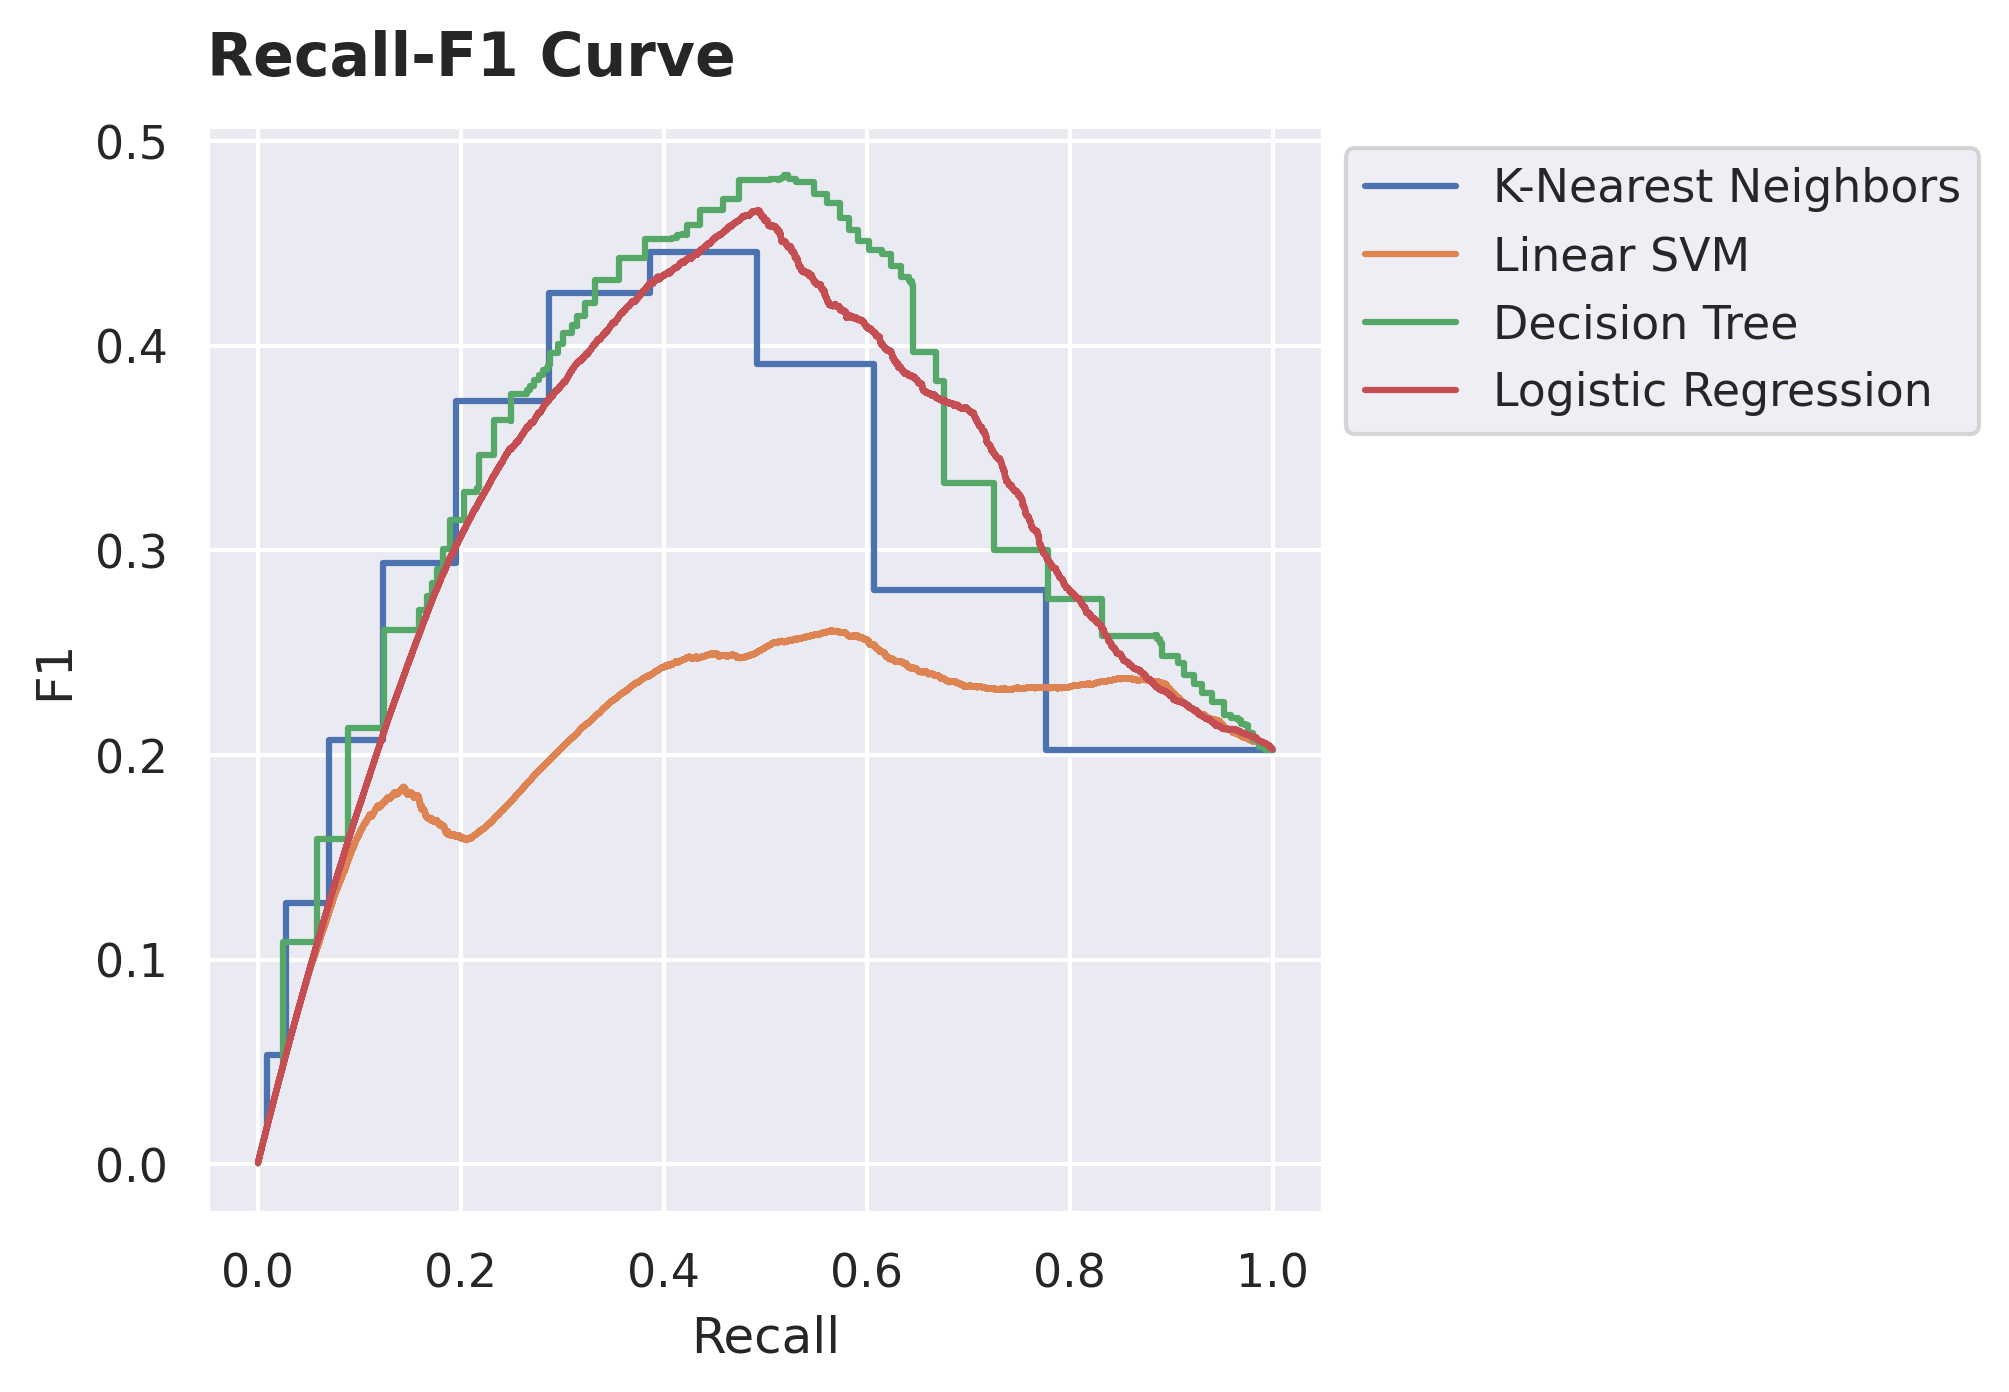

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, 2*recalls*precisions/(recalls+precisions), drawstyle="steps-post", label=name)
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="F1", title="Recall-F1 Curve")

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

In [ ]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               roc_auc_score(y_train, y_score[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name]),
               average_precision_score(y_train, y_score[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.500188             0.016935    0.275001   
TNR              0.000000           0.499812             0.983065    0.724999   
TPR              1.000000           0.501482             0.195365    0.518998   
bACC             0.500000           0.500647             0.589215    0.621998   
ROC              0.500000           0.500000             0.746779    0.625345   
REC              1.000000           0.501482             0.195365    0.518998   
PRE              0.112659           0.112918             0.594262    0.193296   
F1               0.202505           0.184330             0.294058    0.281682   
AP               0.112659           0.112659             0.355513    0.201832   

      Decision Tree  Logistic Regression  
FPR        0.150193             0.261179  
TNR        0.849807             0.738821  
TPR        0.624360             0.693075  
bACC       0.737083             0.715948  
ROC        0.781195             0.763161  
REC        0.624360             0.693075  
PRE        0.345460             0.252009  
F1         0.444807             0.369620  
AP         0.431446             0.402509

# Data Preparation and Feature Engineering

6 min, by Jiawei Li

## Import Dataset

In [ ]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    bank_mkt["month"] = bank_mkt["month"].replace(month_map)
    # `day_of_week` will be encoded to the corresponding number, e.g. "wed" -> 3
    dow_map = {"mon":1,
               "tue":2,
               "wed":3,
               "thu":4,
               "fri":5}
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].replace(dow_map)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "Int64",
                                      "day_of_week": "Int64",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder ordinal categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    return bank_mkt

## Partition

We need to split the dataset into trainning set and test set, then we train models on the trainning set and only use test set for final validation purposes. However, simply sampling the dataset may lead to unrepresenatative partition given that our dataset is imbalanced and clients have different features. To solve this problem, `scikit-learn` provides a useful function to select representative data as test data.

In [ ]:
def split_dataset(data, preprocessor, random_state=82):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.iloc[ttrain_index]
        validate_set = train_set.iloc[validate_index]
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

## Pipelines

Even though `sklearn` can process `pd.DataFrame`, more complicated data transformation can only be well processed when the dataframe is encoded in numbers. Missing values will be encoded as `-1`. All boolean and categorical values need to be converted to integers first. For ordinal data like `education`, `month` and `day_of_week` , we can say `basic.6y` is more "advanced" than `basic.4y` for example. Therefore, we should encode `education` into ordinal values or transform them into years of `education`. The same logic also goes for `month` and `day_of_week`.

As discussed above, some clients do not have `pdays` but have `poutcome`, which implies that they may have been contacted before but the `pdays` is not inluded. We use `pdays=999` for this kind of clients. `pdays` can also be cut into different categories which is known as the discretization process.

We create a function `cat_encode()` to allow us to do such transformations in pandas then we use pipelines to wrap different transformers.

In [ ]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               external=None,
               cyclic=None,
               target=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        external : list
        
        cyclic : list
        
        target : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()

    # Clients who have been contacted but do not have pdays record,
    # should be encoded as 999
    X["pdays"] = X["pdays"].fillna(-1)
    X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
    
    if cut != None:
        if "pdays" in cut:
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    
    if external != None:
        if "year" in external or "econ" in external:
            X.loc[X.index < 27682, "year"] = 2008
            X.loc[(27682<=X.index) & (X.index<39118), "year"] = 2009
            X.loc[39118<=X.index, "year"] = 2010
            X["year"] = X["year"].astype("int")
        if "econ" in external:
            X["date"] = pd.to_datetime(X[["month", "year"]].assign(day=1))
            econ = pd.read_csv("../data/Econ.csv")
            econ["date"] = pd.to_datetime(econ["date"])
            X = X.merge(econ, how="left", on="date")
            X = X.drop("date", axis=1)

    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
            
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [ ]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test" and not isinstance(clf, CatBoostClassifier):
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X)

        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

## Feature Engineering

### Baseline

In [ ]:
cat_encoder = FunctionTransformer(cat_encode)
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1, 8])
cat_baseline = benchmark(bank_mkt, cat_encoder, cat_clf)
cat_baseline

Train  Validate      Test
TNR   0.865244  0.876668  0.863848
TPR   0.667902  0.638814  0.642241
bACC  0.766573  0.757741  0.753045
ROC   0.854778  0.808203  0.799534
REC   0.667902  0.638814  0.642241
PRE   0.386249  0.396653  0.374607
AP    0.538459  0.494672  0.448463

In [ ]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

cat_transformer = make_pipeline(cat_encoder, hot_scaler)

In [ ]:
logit_clf = LogisticRegression(penalty="none", class_weight="balanced", max_iter=1000)
logit_baseline = benchmark(bank_mkt, cat_transformer, logit_clf)
logit_baseline

Train  Validate      Test
TNR   0.808493  0.799350  0.807471
TPR   0.661839  0.657682  0.665948
bACC  0.735166  0.728516  0.736710
ROC   0.789063  0.772515  0.781732
REC   0.661839  0.657682  0.665948
PRE   0.304982  0.293799  0.305185
AP    0.445361  0.431799  0.425098

In [ ]:
rbf_clf = Pipeline([
    ("rbf", RBFSampler(gamma=0.001, random_state=42)),
    ("svm", LinearSVC(C=1, loss="squared_hinge", dual=False, class_weight="balanced", max_iter=1000))
])
rbf_baseline = benchmark(bank_mkt, cat_transformer, rbf_clf)
rbf_baseline

Train  Validate      Test
TNR   0.785913  0.806363  0.795567
TPR   0.670259  0.699461  0.677802
bACC  0.728086  0.752912  0.736684
ROC   0.785004  0.795443  0.785237
REC   0.670259  0.699461  0.677802
PRE   0.284448  0.314355  0.296279
AP    0.439358  0.465723  0.418256

In [ ]:
sum_baseline = pd.concat([cat_baseline, logit_baseline, rbf_baseline], keys=["CatBoost", "Logistic", "RBF SVM"], axis=1)
sum_baseline

CatBoost                      Logistic                       RBF SVM  \
         Train  Validate      Test     Train  Validate      Test     Train   
TNR   0.865244  0.876668  0.863848  0.808493  0.799350  0.807471  0.785913   
TPR   0.667902  0.638814  0.642241  0.661839  0.657682  0.665948  0.670259   
bACC  0.766573  0.757741  0.753045  0.735166  0.728516  0.736710  0.728086   
ROC   0.854778  0.808203  0.799534  0.789063  0.772515  0.781732  0.785004   
REC   0.667902  0.638814  0.642241  0.661839  0.657682  0.665948  0.670259   
PRE   0.386249  0.396653  0.374607  0.304982  0.293799  0.305185  0.284448   
AP    0.538459  0.494672  0.448463  0.445361  0.431799  0.425098  0.439358   

                          
      Validate      Test  
TNR   0.806363  0.795567  
TPR   0.699461  0.677802  
bACC  0.752912  0.736684  
ROC   0.795443  0.785237  
REC   0.699461  0.677802  
PRE   0.314355  0.296279  
AP    0.465723  0.418256

### Drop Client Data

In [ ]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default",
                 "duration",
                 "y"]

drop_encoder = FunctionTransformer(cat_encode, kw_args={"drop": drop_features})

In [ ]:
cat_drop = benchmark(bank_mkt, drop_encoder, cat_clf)
pd.concat([cat_baseline, cat_drop], keys=["Catboost Baseline", "Catboost Drop"], axis=1)

Catboost Baseline                     Catboost Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.865244  0.876668  0.863848      0.853868  0.856654  0.851806
TPR           0.667902  0.638814  0.642241      0.654766  0.661725  0.643319
bACC          0.766573  0.757741  0.753045      0.754317  0.759190  0.747563
ROC           0.854778  0.808203  0.799534      0.827541  0.815285  0.807268
REC           0.667902  0.638814  0.642241      0.654766  0.661725  0.643319
PRE           0.386249  0.396653  0.374607      0.362619  0.369451  0.355357
AP            0.538459  0.494672  0.448463      0.514197  0.503827  0.458815

In [ ]:
cat_features = ["poutcome"]

num_features =  ["campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

drop_transformer = make_pipeline(drop_encoder, hot_scaler)

In [ ]:
logit_drop = benchmark(bank_mkt, drop_transformer, logit_clf)
pd.concat([logit_baseline, logit_drop], keys=["Logistic Baseline", "Logistic Drop"], axis=1)

Logistic Baseline                     Logistic Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.808493  0.799350  0.807471      0.791986  0.792850  0.795703
TPR           0.661839  0.657682  0.665948      0.667902  0.634771  0.664871
bACC          0.735166  0.728516  0.736710      0.729944  0.713810  0.730287
ROC           0.789063  0.772515  0.781732      0.784415  0.763938  0.782902
REC           0.661839  0.657682  0.665948      0.667902  0.634771  0.664871
PRE           0.304982  0.293799  0.305185      0.289616  0.280024  0.292417
AP            0.445361  0.431799  0.425098      0.441491  0.413736  0.414384

In [ ]:
rbf_drop = benchmark(bank_mkt, drop_transformer, rbf_clf)
pd.concat([rbf_baseline, rbf_drop], keys=["RBF Baseline", "RBF Drop"], axis=1)

RBF Baseline                      RBF Drop                    
            Train  Validate      Test     Train  Validate      Test
TNR      0.785913  0.806363  0.795567  0.783518  0.781389  0.786672
TPR      0.670259  0.699461  0.677802  0.668238  0.698113  0.674569
bACC     0.728086  0.752912  0.736684  0.725878  0.739751  0.730621
ROC      0.785004  0.795443  0.785237  0.788912  0.790958  0.785012
REC      0.670259  0.699461  0.677802  0.668238  0.698113  0.674569
PRE      0.284448  0.314355  0.296279  0.281578  0.288419  0.286499
AP       0.439358  0.465723  0.418256  0.436431  0.448641  0.415289

### Use Most Frequent Values to Impute Missing Values

We have several strategies to handle the missing values. For categorical data, we can treat missing value as a different category (-1), which is done by `cat_encode`.

`SimpleImputer` allows us to use simple strategies, such as mean value, to fill the missing values. In our case, because most of our missing values are categorical, it makes more sense to use the most frequent values. This strategy and the feature engineering on `pdays` will be applied on the `freq_preprocessor`.

In [ ]:
freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)

In [ ]:
cat_freq = benchmark(bank_mkt, freq_encoder, cat_clf)
pd.concat([cat_baseline, cat_freq], keys=["Catboost Baseline", "Catboost Frequent"], axis=1)

Catboost Baseline                     Catboost Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.865244  0.876668  0.863848          0.870119  0.870168   
TPR           0.667902  0.638814  0.642241          0.660155  0.653639   
bACC          0.766573  0.757741  0.753045          0.765137  0.761903   
ROC           0.854778  0.808203  0.799534          0.854200  0.811373   
REC           0.667902  0.638814  0.642241          0.660155  0.653639   
PRE           0.386249  0.396653  0.374607          0.392235  0.389871   
AP            0.538459  0.494672  0.448463          0.545838  0.475607   

                
          Test  
TNR   0.864395  
TPR   0.630388  
bACC  0.747392  
ROC   0.800065  
REC   0.630388  
PRE   0.371193  
AP    0.447111

In [ ]:
# Select "job", "marital", "education"
cat_features = [0,1,2]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [5,10,11,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

freq_transformer = make_pipeline(cat_encoder, freq_imputer, hot_scaler)


In [ ]:
logit_freq = benchmark(bank_mkt, freq_transformer, logit_clf)
pd.concat([logit_baseline, logit_freq], keys=["Logistic Baseline", "Logistic Frequent"], axis=1)

Logistic Baseline                     Logistic Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.808493  0.799350  0.807471          0.805329  0.793705   
TPR           0.661839  0.657682  0.665948          0.664534  0.649596   
bACC          0.735166  0.728516  0.736710          0.734931  0.721650   
ROC           0.789063  0.772515  0.781732          0.784865  0.772024   
REC           0.661839  0.657682  0.665948          0.664534  0.649596   
PRE           0.304982  0.293799  0.305185          0.302375  0.285545   
AP            0.445361  0.431799  0.425098          0.430666  0.391441   

                
          Test  
TNR   0.799535  
TPR   0.661638  
bACC  0.730586  
ROC   0.779692  
REC   0.661638  
PRE   0.295334  
AP    0.406844

In [ ]:
rbf_freq = benchmark(bank_mkt, freq_transformer, rbf_clf)
pd.concat([rbf_baseline, rbf_freq], keys=["RBF Baseline", "RBF Frequent"], axis=1)

RBF Baseline                     RBF Frequent                    
            Train  Validate      Test        Train  Validate      Test
TNR      0.785913  0.806363  0.795567     0.799897  0.800034  0.803093
TPR      0.670259  0.699461  0.677802     0.670596  0.659030  0.667026
bACC     0.728086  0.752912  0.736684     0.735247  0.729532  0.735059
ROC      0.785004  0.795443  0.785237     0.785590  0.773939  0.780480
REC      0.670259  0.699461  0.677802     0.670596  0.659030  0.667026
PRE      0.284448  0.314355  0.296279     0.298501  0.294934  0.300777
AP       0.439358  0.465723  0.418256     0.436411  0.405464  0.407222

### Estimate Missing Values 

In [ ]:
ite_features = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "month", "day_of_week", "pdays", "previous"]

ite_imputer = ColumnTransformer([
    ("ite_imputer",
     make_pipeline(
         IterativeImputer(max_iter=100, missing_values=-1, initial_strategy="most_frequent", random_state=42),
         FunctionTransformer(np.round)
     ),
     ite_features),
], remainder="passthrough")

ite_encoder = make_pipeline(cat_encoder, ite_imputer)

In [ ]:
cat_ite = benchmark(bank_mkt, ite_encoder, cat_clf)
pd.concat([cat_baseline, cat_ite], keys=["Catboost Baseline", "Catboost Iterative"], axis=1)

Catboost Baseline                     Catboost Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.865244  0.876668  0.863848           0.861908  0.857680   
TPR           0.667902  0.638814  0.642241           0.657124  0.656334   
bACC          0.766573  0.757741  0.753045           0.759516  0.757007   
ROC           0.854778  0.808203  0.799534           0.848593  0.816658   
REC           0.667902  0.638814  0.642241           0.657124  0.656334   
PRE           0.386249  0.396653  0.374607           0.376641  0.369219   
AP            0.538459  0.494672  0.448463           0.534588  0.484819   

                
          Test  
TNR   0.856596  
TPR   0.649784  
bACC  0.753190  
ROC   0.796796  
REC   0.649784  
PRE   0.365233  
AP    0.445365

In [ ]:
# Select "job", "marital", "education", "default", "housing", "loan", "poutcome"
cat_features = [1,2,3,4,5,13]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [0,8,9,10,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

ite_transformer = make_pipeline(cat_encoder, ite_imputer, hot_scaler)

In [ ]:
logit_ite = benchmark(bank_mkt, ite_transformer, logit_clf)
pd.concat([logit_baseline, logit_ite], keys=["Logistic Baseline", "Logistic Iterative"], axis=1)

Logistic Baseline                     Logistic Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.808493  0.799350  0.807471           0.805414  0.803626   
TPR           0.661839  0.657682  0.665948           0.660492  0.650943   
bACC          0.735166  0.728516  0.736710           0.732953  0.727285   
ROC           0.789063  0.772515  0.781732           0.787297  0.776394   
REC           0.661839  0.657682  0.665948           0.660492  0.650943   
PRE           0.304982  0.293799  0.305185           0.301183  0.296137   
AP            0.445361  0.431799  0.425098           0.442224  0.437397   

                
          Test  
TNR   0.803093  
TPR   0.662716  
bACC  0.732904  
ROC   0.782149  
REC   0.662716  
PRE   0.299416  
AP    0.424146

In [ ]:
rbf_ite = benchmark(bank_mkt, ite_transformer, rbf_clf)
pd.concat([rbf_baseline, rbf_ite], keys=["RBF Baseline", "RBF Iterative"], axis=1)

RBF Baseline                     RBF Iterative                    
            Train  Validate      Test         Train  Validate      Test
TNR      0.785913  0.806363  0.795567      0.797545  0.791652  0.790367
TPR      0.670259  0.699461  0.677802      0.666218  0.659030  0.675647
bACC     0.728086  0.752912  0.736684      0.731881  0.725341  0.733007
ROC      0.785004  0.795443  0.785237      0.787292  0.781471  0.783208
REC      0.670259  0.699461  0.677802      0.666218  0.659030  0.675647
PRE      0.284448  0.314355  0.296279      0.294696  0.286467  0.290412
AP       0.439358  0.465723  0.418256      0.442005  0.416586  0.429849

### Cut `pdays`

In [ ]:
cut_encoder = FunctionTransformer(cat_encode, kw_args={"cut": ["pdays"]})

In [ ]:
cat_cut = benchmark(bank_mkt, cut_encoder, cat_clf)
pd.concat([cat_baseline, cat_cut], keys=["Catboost Baseline", "Catboost Cut"], axis=1)

Catboost Baseline                     Catboost Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.865244  0.876668  0.863848     0.862079  0.850496  0.855364
TPR           0.667902  0.638814  0.642241     0.665207  0.632075  0.641164
bACC          0.766573  0.757741  0.753045     0.763643  0.741286  0.748264
ROC           0.854778  0.808203  0.799534     0.846678  0.795422  0.800590
REC           0.667902  0.638814  0.642241     0.665207  0.632075  0.641164
PRE           0.386249  0.396653  0.374607     0.379808  0.349218  0.360169
AP            0.538459  0.494672  0.448463     0.532863  0.459283  0.441732

In [ ]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome",
                "pdays"]

num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

cut_transformer = make_pipeline(cut_encoder, hot_scaler)

In [ ]:
logit_cut = benchmark(bank_mkt, cut_transformer, logit_clf)
pd.concat([logit_baseline, logit_cut], keys=["Logistic Baseline", "Logistic Cut"], axis=1)

Logistic Baseline                     Logistic Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.808493  0.799350  0.807471     0.811615  0.805166  0.807745
TPR           0.661839  0.657682  0.665948     0.662176  0.646900  0.665948
bACC          0.735166  0.728516  0.736710     0.736896  0.726033  0.736847
ROC           0.789063  0.772515  0.781732     0.786628  0.782706  0.782057
REC           0.661839  0.657682  0.665948     0.662176  0.646900  0.665948
PRE           0.304982  0.293799  0.305185     0.308586  0.296479  0.305487
AP            0.445361  0.431799  0.425098     0.445232  0.435211  0.428071

In [ ]:
rbf_ite = benchmark(bank_mkt, ite_transformer, rbf_clf)
pd.concat([rbf_baseline, rbf_ite], keys=["RBF Baseline", "RBF Iterative"], axis=1)

RBF Baseline                     RBF Iterative                    
            Train  Validate      Test         Train  Validate      Test
TNR      0.785913  0.806363  0.795567      0.779669  0.780363  0.790367
TPR      0.670259  0.699461  0.677802      0.676659  0.667116  0.675647
bACC     0.728086  0.752912  0.736684      0.728164  0.723739  0.733007
ROC      0.785004  0.795443  0.785237      0.782354  0.778703  0.783208
REC      0.670259  0.699461  0.677802      0.676659  0.667116  0.675647
PRE      0.284448  0.314355  0.296279      0.280547  0.278246  0.290412
AP       0.439358  0.465723  0.418256      0.437005  0.425810  0.429849

# Logistic Regression

2 min, by Fan Jia

# SVM

4 min, by Qiqi Zhou

# Neural Network
2 min, by Qiqi Zhou

# Decision Tree and Its Ensembles

6 min, by Strahinja Trenkic

# Ensemble

3 min, by Jiawei Li

# Summary of Modelling

2 min, by Jiawei Li

# Conclusion

5 min, by Strahinja Trenkic